Data analysis for the pilot participants in PLEARN

# Load Libraries and Resources

In [1]:
library('readr')
library('blabr')
library('plyr')
library('dplyr')
library('ggplot2')
library('rjson')
library('parallel')
library("readxl")
library('dotwhisker')
source('PLEARN_analysis_helper.R')
source('texvars.R')
library('broom')
library('lme4')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix


In [2]:
tvc = initialize_texvar_cache()

In [3]:
item_properties = read.csv('../PLEARN_experiments/csv/plearn_receptiveTask_datasource.csv')
item_properties$AudioTarget = sapply(item_properties$AudioTarget, trimws)
length(unique(item_properties$AudioTarget))
item_properties$AudioTarget[duplicated(item_properties$AudioTarget)] #64 test items + 4 practice

[1] 68

[1] "65.wav" "71.wav" "66.wav" "72.wav"

In [4]:
# audio timings for the version with the background ("bg_")
bg_audio_timings = getAudioTimingsFromGlob("../PLEARN_experiments/stimuli/raw_audio2/*.cut")
bg_audio_timings_with_metadata = merge(item_properties, bg_audio_timings, by.x='AudioTarget', 
    by.y='audiotarget')
bg_audio_timings_with_metadata$plural_duration = (bg_audio_timings_with_metadata$target_noun_end_time -
    bg_audio_timings_with_metadata$begin_disambig_region) * 1000 
print(nrow(bg_audio_timings_with_metadata))

[1] 72


In [5]:
print(bg_audio_timings_with_metadata[1,])

  AudioTarget s_form novel_id background_context vowel_carrier
1      10.wav    tep 2005-600              house  in the house
               full_carrier    s_carrier s_punct s_wav_index
1 Look at the  in the house Look at the        !           2
                               s_sentence pl_form   pl_carrier pl_punct
1 2. tep... Look at the tep in the house!    teps Look at the         !
  pl_wav_index                                pl_sentence novelty   voicing
1           10 10. teps... Look at the teps in the house!   novel voiceless
      simple_pl_stim     simple_s_stim animacyStatus Trial target Practice
1 Look at the  teps! Look at the  tep!     inanimate    30     pl        n
  test_index TargetSide trial_index NovelColor order expt_index TargetLoc
1         32          r          32        red     2         34 (960,512)
  DistractorLoc           TargetImage          DistractorImage start_time
1     (320,512) 2_tep_plural_left.png 2_tep_singular_right.png      8.548
  stop_tim

In [6]:
# audio timings for the red/blue version ("rb_")
rb_audio_timings = getAudioTimingsFromGlob("../PLEARN_experiments/stimuli/raw_audio_simplified/*.cut")
rb_audio_timings_with_metadata = merge(item_properties, rb_audio_timings, by.x='AudioTarget', 
    by.y='audiotarget') 
rb_audio_timings_with_metadata$plural_duration = (rb_audio_timings_with_metadata$target_noun_end_time -
    rb_audio_timings_with_metadata$begin_disambig_region) * 1000 
print(nrow(rb_audio_timings_with_metadata))

[1] 72


In [79]:
subject_info = read.csv('subject_info.csv', stringsAsFactors=F) #No PII
subject_info$participant_name = sapply(strsplit(subject_info$filename,'_' ), function(x){x[1]})

# children without eyetracking files
for (participant in c('pl04','pl05','pl35','pl58')){
    subject_info[subject_info$id == participant,'participant_name'] = participant
}  
if (nrow(subset(subject_info, is.na(participant_name) & type == 'child')) > 0){
    stop('some children do not have participant name populated')
}
subject_info$age_in_months = subject_info$age_in_days / 30.5


subject_info$ran_participant = subject_info$expt_version %in% c('redblue', 'scene') &
(subject_info$type == 'adult' | (
    subject_info$age_in_months > 23 & 
    subject_info$age_in_months < 37 &
    subject_info$type == 'child'
))


In [80]:
ranN = nrow(subset(subject_info, type == 'child' & ran_participant)) 
tvc = update_texvar_cache(tvc, 'ranN', ranN)
ranN

[1] 53

In [84]:
subject_info$in_study = subject_info$expt_version %in% c('redblue', 'scene') &
(subject_info$type == 'adult' | (
    subject_info$age_in_months > 23 & 
    subject_info$age_in_months < 37 &
    subject_info$type == 'child' &
    (subject_info$include_storybook | subject_info$include_eyetracking)
))

subject_info = subset(subject_info, in_study)
nrow(subject_info)

[1] 76

In [86]:
if (length(subset(subject_info, filename != '')$filename) !=
length(unique(subset(subject_info, filename != '')$filename))){
    stop('Repeated filenames in the subject info file; look for repeats')
}

In [87]:
#number of total kids tested, before exclusions 
totalN = nrow(subset(subject_info, type == 'child' & in_study))
tvc = update_texvar_cache(tvc, 'totalN', totalN)
totalN

[1] 52

In [88]:
# number of kids in study 1
sceneN = nrow(subset(subject_info, expt_version == 'scene' & type == 'child'))
sceneN
tvc = update_texvar_cache(tvc, 'sceneN', sceneN)

[1] 24

In [89]:
# of kids in study 2
redblueN =  nrow(subset(subject_info, expt_version == 'redblue' & type == 'child'))
redblueN
tvc = update_texvar_cache(tvc, 'redblueN', redblueN)

[1] 28

In [90]:
# usable eyetracking
redblue_eyetracking_exclusions = subset(subject_info, type == 'child' & expt_version == 'redblue' & !include_eyetracking)
redblueNExclusions = nrow(redblue_eyetracking_exclusions)
tvc = update_texvar_cache(tvc, 'redblueNExclusions', redblueNExclusions)
redblue_eyetracking_exclusions$comment

[1] "Fussiness; production task but no receptive task"  
[2] "fussiness; production task but no receptive task"  
[3] "fussiness; Production task but no receptive task"  
[4] "eyetracker problem"                                
[5] "Squirminess; Production task but no receptive task"
[6] "eyetracking problem"

In [91]:
redblue_eyetracking_exclusions

id   include_eyetracking include_storybook filename            age_in_days
26 pl21 0                   1                 pl21_fixations.xlsx 1100       
37 pl35 0                   1                                      944       
42 pl40 0                   1                 pl40_fixations.xlsx  725       
71 pl54 0                   1                 pl54_fixations.xlsx  976       
76 pl61 0                   1                 pl61_fixations.xlsx  728       
77 pl62 0                   1                 pl62_fixations.xlsx 1038       
   gender type  expt_version comment                                           
26 F      child redblue      Fussiness; production task but no receptive task  
37 F      child redblue      fussiness; production task but no receptive task  
42 M      child redblue      fussiness; Production task but no receptive task  
71 F      child redblue      eyetracker problem                                
76 M      child redblue      Squirminess; Production task but no receptive task
77 M      child redblue      eyetracking problem                               
   participant_name age_in_months ran_participant in_study
26 pl21             36.06557      TRUE            TRUE    
37 pl35             30.95082      TRUE            TRUE    
42 pl40             23.77049      TRUE            TRUE    
71 pl54             32.00000      TRUE            TRUE    
76 pl61             23.86885      TRUE            TRUE    
77 pl62             34.03279      TRUE            TRUE

In [92]:
scene_eyetracking_exclusions = subset(subject_info, type == 'child' & expt_version == 'scene'
                                      & !include_eyetracking)
sceneNExclusions = nrow(scene_eyetracking_exclusions)
tvc = update_texvar_cache(tvc, 'sceneNExclusions', sceneNExclusions)
scene_eyetracking_exclusions$comment

[1] "Fussiness; Production task but no receptive task"  
[2] "Fussiness; Production task but no receptive task"  
[3] "Fussiness; Production task but no receptive task"  
[4] "Squirminess; Production task but no receptive task"

In [15]:
redBlueAdultN = nrow(subset(subject_info, type == 'adult' & expt_version == 'redblue'))
tvc = update_texvar_cache(tvc, 'redBlueAdultN', redBlueAdultN)
sceneAdultN = nrow(subset(subject_info, type == 'adult' & expt_version == 'scene'))
tvc = update_texvar_cache(tvc, 'sceneAdultN', sceneAdultN)

In [16]:
storybook_exclusions = subset(subject_info, type == 'child' & expt_version %in% 
                                      c('redblue','scene') & !include_storybook)
nStorybookExclusions = nrow(storybook_exclusions)
nStorybookExclusions
tvc = update_texvar_cache(tvc, 'nStorybookExclusions', nStorybookExclusions)
storybook_exclusions$comment

[1] 4

[1] "Fussiness; Receptive but not productive task"                         
[2] "fussiness in production"                                              
[3] "eyetracker problem; fussiness in production"                          
[4] "too quiet in the production task; increased the gain but hard to hear"

In [95]:
#tvc = initialize_texvar_cache()
percentFem = 100 * mean(subset(subject_info, !is.na(gender) & gender != ''
        & type == 'child' & expt_version %in% c('redblue','scene')
)$gender == 'F', na.rm=T)
tvc = update_texvar_cache(tvc, 'percentFem', percentFem)
numFem = sum(subset(subject_info, !is.na(gender) & gender != ''
        & type == 'child' & expt_version %in% c('redblue','scene')
        )$gender == 'F')
tvc = update_texvar_cache(tvc, 'numFem', numFem)
meanAge = mean(subset(subject_info, type == 'child' & type == 'child' &
                      expt_version %in% c('redblue','scene'))$age_in_months, na.rm=T)
tvc = update_texvar_cache(tvc, 'meanAge', meanAge)
sdAge = sd(subset(subject_info, type == 'child' & type == 'child' &
                      expt_version %in% c('redblue','scene'))$age_in_months, na.rm=T)
tvc = update_texvar_cache(tvc, 'sdAge', sdAge)

In [96]:
numFem
percentFem
meanAge
sdAge

[1] 29

[1] 55.76923

[1] 30.22131

[1] 3.990392

In [97]:
writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

# Choose Storybook Participants for Recoding

In [98]:
storbybook_kids = subset(subject_info, type == 'child' & include_storybook & in_study)

In [99]:
recode_df = data.frame(sample(storbybook_kids$participant_name, length(storbybook_kids$participant_name),
      replace = F))
names(recode_df) = 'participant_name'
write.csv(recode_df, 'storybook_participants_for_recoding.csv', row.names=F)

In [100]:
file_len <- function(fil) {
  if (file.info(fil)$size != 0) {
    wavHeader <- readWave(fil, header = TRUE)
    wavHeader$samples / wavHeader$sample.rate
  } else {
    0
  }
}

file_len('audio/pl52.wav')

[1] 361.0274

In [101]:
storybook_df = data.frame(file = list.files('audio'))
storybook_df$duration = sapply(storybook_df$file,
                               function(x){
                                   file_len(paste('audio',x, sep='/'))
                                   })
storybook_df$duration_in_minutes = storybook_df$duration / 60

In [102]:
storybook_df[order(storybook_df$duration_in_minutes),]

file                duration  duration_in_minutes
48 pl54_2.wav           56.77340  0.9462234         
19 pl22_2.wav           57.07816  0.9513027         
18 pl22_1.wav          134.06683  2.2344471         
32 pl38.wav            140.14755  2.3357925         
39 pl45.wav            140.61195  2.3435325         
17 pl21.wav            161.78565  2.6964274         
40 pl46.wav            162.14846  2.7024743         
13 pl17.wav            166.50220  2.7750367         
52 pl59.wav            188.14029  3.1356716         
22 pl25.wav            191.79744  3.1966240         
11 pl15.wav            196.23825  3.2706376         
51 pl57.wav            198.67635  3.3112725         
56 pl64.wav            200.92578  3.3487630         
7  pl10_audio.wav      202.10649  3.3684414         
44 pl50.wav            203.36388  3.3893980         
10 pl14.wav            206.96297  3.4493828         
21 pl24.wav            209.83644  3.4972740         
3  pl04_room.wav       211.26447  3.5210745         
27 pl31.wav            213.27590  3.5545983         
9  pl13.wav            215.33667  3.5889444         
50 pl55.wav            216.00424  3.6000707         
49 pl54.wav            218.83417  3.6472362         
33 pl39.wav            226.94664  3.7824441         
25 pl29.wav            232.57748  3.8762914         
58 pl67.wav            238.23735  3.9706224         
53 pl61.wav            244.95662  4.0826104         
41 pl47.wav            245.59517  4.0932528         
37 pl43.wav            249.58610  4.1597683         
54 pl62.wav            252.08224  4.2013707         
57 pl66.wav            253.38837  4.2231395         
31 pl37.wav            256.26184  4.2710306         
45 pl51.wav            256.29086  4.2715144         
29 pl35_audio_only.wav 256.88587  4.2814312         
20 pl23.wav            258.78701  4.3131168         
55 pl63.wav            266.20288  4.4367147         
26 pl30.wav            267.58156  4.4596927         
42 pl48.wav            268.75707  4.4792846         
15 PL19.wav            282.15209  4.7025348         
2  pl03_room.wav       285.60544  4.7600907         
24 pl28.wav            287.21694  4.7869490         
6  pl09_audio_02.wav   290.89959  4.8483265         
4  pl05_room.wav       300.74485  5.0124142         
12 pl16.wav            305.98156  5.0996927         
43 pl49.wav            310.27726  5.1712876         
23 pl27.wav            316.03871  5.2673118         
8  pl11.wav            316.62730  5.2771217         
36 pl42.wav            317.57703  5.2929505         
46 pl52.wav            361.02737  6.0171228         
34 pl40.wav            387.33848  6.4556413         
38 pl44.wav            413.31580  6.8885967         
30 pl36_book.wav       448.82782  7.4804637         
16 pl20.wav            474.58746  7.9097910         
14 pl18.wav            481.33576  8.0222627         
1  pl01_room.wav       482.41778  8.0402963         
28 pl33_take2.wav      536.72986  8.9454977         
47 pl53.wav            542.41875  9.0403125         
35 pl41.wav            655.23871 10.9206451         
5  pl09_audio_01.wav   680.25179 11.3375299

In [103]:
sum(storybook_df$duration_in_minutes) / 60

[1] 4.484062

# Audio Stimuli Properties

## Plural  Segment Duration (Background version)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


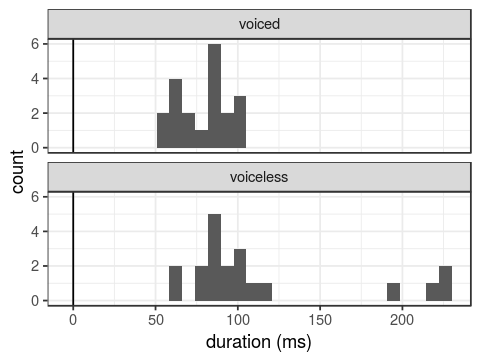

In [104]:
options(repr.plot.width=4, repr.plot.height=3)
ggplot(subset(bg_audio_timings_with_metadata, plural_duration != 0)) + geom_histogram(aes(x=plural_duration)
) + facet_wrap(~voicing, ncol=1) + theme_bw() + geom_vline(xintercept=0) +xlab('duration (ms)')

Instances of the voiceless allomorph have a longer duration than those of the voiced allomorph

## Prepositional Phrase Duration (Background version)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


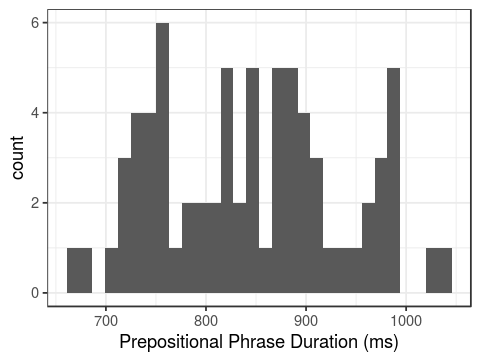

In [105]:
mean_pp_duration= mean(bg_audio_timings$pp_duration, na.rm=T) * 1000
options(repr.plot.width=4, repr.plot.height=3)
ggplot(bg_audio_timings) + geom_histogram(aes(x=pp_duration * 1000)) + theme_bw() + xlab('Prepositional Phrase Duration (ms)')

In [106]:
### Intro Phrase Durations (Background Version)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


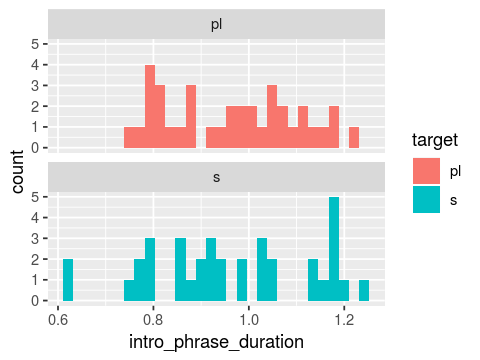

In [107]:
bg_audio_timings_with_metadata$intro_phrase_duration = bg_audio_timings_with_metadata$begin_disambig_region- bg_audio_timings_with_metadata$start_time
ggplot(bg_audio_timings_with_metadata) + geom_histogram(
    aes(x=intro_phrase_duration, fill=target)) + facet_wrap(~target, ncol=1)

In [108]:
subset(bg_audio_timings_with_metadata, intro_phrase_duration < .7)

AudioTarget s_form novel_id background_context vowel_carrier
65 6.wav       dup    2028-600 hill                on the hill 
70 7.wav       fip    2030-600 couch               on the couch
   full_carrier              s_carrier    s_punct s_wav_index
65 Look at the  on the hill  Look at the  !       6          
70 Look at the  on the couch Look at the  !       7          
   s_sentence                              ⋯ start_time stop_time
65 6. dup... Look at the dup on the hill!  ⋯ 30.937     32.578   
70 7. fip... Look at the fip on the couch! ⋯ 36.590     38.367   
   target_noun_start_time begin_disambig_region target_noun_end_time filename
65 31.565                 31.565                31.791               6.wav   
70 37.204                 37.204                37.400               7.wav   
   disambig_time pp_duration plural_duration intro_phrase_duration
65 2628          0.787       226             0.628                
70 2614          0.967       196             0.614

Followed up on these (left edge of the singulars); they are relatively high speech rate

In [109]:
wilcox.test(subset(bg_audio_timings_with_metadata, target == 's')$intro_phrase_duration,
                 subset(bg_audio_timings_with_metadata, target == 'pl')$intro_phrase_duration)

Warning message in wilcox.test.default(subset(bg_audio_timings_with_metadata, target == :
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  subset(bg_audio_timings_with_metadata, target == "s")$intro_phrase_duration and subset(bg_audio_timings_with_metadata, target == "pl")$intro_phrase_duration
W = 655.5, p-value = 0.9372
alternative hypothesis: true location shift is not equal to 0


Duration of intro phrases is not distinguished in the background version

## Plural  Segment Duration (Simplified version)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


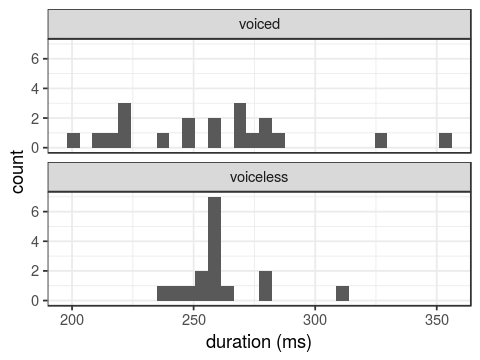

In [110]:
options(repr.plot.width=4, repr.plot.height=3)
ggplot(subset(rb_audio_timings_with_metadata, plural_duration > 0)) + geom_histogram(aes(x=plural_duration)
) + facet_wrap(~voicing, ncol=1) + theme_bw() +xlab('duration (ms)')

In [111]:
subset(rb_audio_timings_with_metadata, plural_duration > 325)

AudioTarget s_form novel_id background_context vowel_carrier
17 25.wav      kib    2039-600 house               in the house
54 59.wav      frog   !        tree                in the tree 
   full_carrier                   s_carrier         s_punct s_wav_index
17 Can you find the  in the house Can you find the  ?       17         
54 Look at the  in the tree       Look at the       !       51         
   s_sentence                                    ⋯ start_time stop_time
17 17. kib... Can you find the kib in the house? ⋯  4.649      6.500   
54 51. frog... Look at the frog in the tree!     ⋯ 14.737     16.106   
   target_noun_start_time begin_disambig_region target_noun_end_time filename
17  5.780                  6.175                 6.500               25.wav  
54 15.232                 15.752                16.106               59.wav  
   disambig_time pp_duration plural_duration intro_phrase_duration
17 3526          0           325             1.526                
54 3015          0           354             1.015

[ ] Some of the voiced items are very long durations, requiring followup

### Intro Phrase Durations (Simplified Version)

In [112]:
rb_audio_timings_with_metadata$intro_phrase_duration = rb_audio_timings_with_metadata$begin_disambig_region- rb_audio_timings_with_metadata$start_time

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


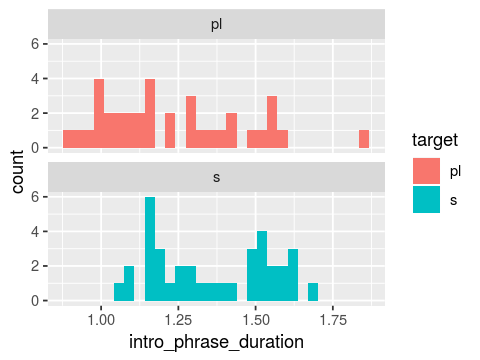

In [113]:
ggplot(rb_audio_timings_with_metadata) + geom_histogram(
    aes(x=intro_phrase_duration, fill=target)) + facet_wrap(~target, ncol=1)

In [114]:
# Plural phrase durations are substantively shorter than the singular phrase durations 

In [115]:
wilcox.test(subset(rb_audio_timings_with_metadata, target == 's')$intro_phrase_duration,
                 subset(rb_audio_timings_with_metadata, target == 'pl')$intro_phrase_duration)

Warning message in wilcox.test.default(subset(rb_audio_timings_with_metadata, target == :
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  subset(rb_audio_timings_with_metadata, target == "s")$intro_phrase_duration and subset(rb_audio_timings_with_metadata, target == "pl")$intro_phrase_duration
W = 890.5, p-value = 0.006419
alternative hypothesis: true location shift is not equal to 0


[ ] Plural intro durations are longer than the singular intro durations, necessitating followup

# Preprocess Eyetracking Data

In [116]:
source('PLEARN_analysis_helper.R')
ed = mclapply(1:nrow(subject_info), function(i){
    participant = subject_info[i,]
    print(participant)
    if (!participant$in_study |
        participant$filename == '' | is.null(participant$filename) |
        is.na(participant$filename) | participant$include_eyetracking == 0){
        print(paste0('No eyetracking data for ', participant$id,' (or excluded), skipping...'))
        return(NULL)
    } else {
        if (participant$expt_version == 'scene'){
            audio_timings = bg_audio_timings
        } else if (participant$expt_version == 'redblue') {
            audio_timings = rb_audio_timings
        } else {
            stop('expt_version not recognized')
        }        
        return(analyzeEyetrackingParticipant(
            'results/', 
            participant$filename, 
            audio_timings, 
            participant$type))
    }
}, mc.cores=24)

In [117]:
ed_df = do.call('rbind.fill', ed)

In [118]:
if (length(unique(subset(ed_df, participant_type == 'child')$filename)) !=
    nrow(subset(subject_info, type == 'child' & include_eyetracking))){
    stop('Missing child data')
}

In [119]:
ed_df = merge(ed_df, subject_info, by=c('filename'))
nrow(ed_df)
names(ed_df)

[1] 871799

[1] "filename"                        "expt_index"                     
 [3] "timeBin"                         "FixationID"                     
 [5] "CURRENT_FIX_START"               "CURRENT_FIX_END"                
 [7] "TRIAL_INDEX"                     "CURRENT_FIX_INDEX"              
 [9] "RECORDING_SESSION_LABEL"         "CURRENT_FIX_INTEREST_AREA_LABEL"
[11] "RT"                              "target"                         
[13] "s_form"                          "novelty"                        
[15] "animacystatus"                   "voicing"                        
[17] "practice"                        "Time"                           
[19] "Nonset"                          "participant_type"               
[21] "looks_to_t"                      "looks_to_d"                     
[23] "looks_to_td"                     "exclude_trial"                  
[25] "exclude_subject"                 "label_at_onset"                 
[27] "time_to_last_nonna"              "track_loss_at_0"                
[29] "id"                              "include_eyetracking"            
[31] "include_storybook"               "age_in_days"                    
[33] "gender"                          "type"                           
[35] "expt_version"                    "comment"                        
[37] "participant_name"                "age_in_months"                  
[39] "ran_participant"                 "in_study"

### Get the properties of the eyetracking participant population after data exclusion

In [120]:
# participants before exclusion
num_eyetracking_participants = aggregate(participant_name ~ expt_version + type, ed_df, function(x){length(unique(x))} )
print(num_eyetracking_participants)

  expt_version  type participant_name
1      redblue adult               15
2        scene adult                9
3      redblue child               22
4        scene child               20


In [121]:
# participants after exclusion
num_eyetracking_participants_after_exclusion =  aggregate(participant_name ~ expt_version + type, 
          subset(ed_df, exclude_subject == F), function(x){length(unique(x))} )
print(num_eyetracking_participants_after_exclusion)

  expt_version  type participant_name
1      redblue adult               15
2        scene adult                9
3      redblue child               22
4        scene child               20


No additional exclusions after this filter

# Preprocess / Plot Production Data

We preprocess the production data at this point because we want to be able to use production scores as a grouping variable in the eyetracking analysis

In [122]:
p_coded = subset(read.csv('productions_coded.csv', stringsAsFactors=F),
    !(itemId %in% c('p1','p2','p3','p4')))
# itemId is not to be trusted

p_coded$itemId = as.numeric(as.factor(as.character(p_coded$Lemma)))
print(names(p_coded))
print(nrow(p_coded))

[1] "child"         "itemId"        "Lemma"         "Singular.IPA" 
[5] "Singular.Code" "Plural.IPA"    "Plural.Code"   "Comments"     
[9] "X"            
[1] 832


In [123]:
if (length(setdiff(
    subset(subject_info, expt_version %in% c('redblue',
    'scene') & type == 'child' & include_storybook)$participant_name,
    unique(p_coded$child))) > 0){
    stop('Missing child codes')
} 

In [124]:
numTrialsPerChild = aggregate(itemId ~ child, p_coded, length)
numTrialsPerChild = numTrialsPerChild[order(numTrialsPerChild$itemId, decreasing=T),]
if (nrow(subset(numTrialsPerChild, itemId != 16)) > 0){
    stop('Coded child data is missing trials')
}

In [125]:
num_production_items = length(unique(p_coded$itemId)) #16 test x 2 + 4 shared practice
if (num_production_items != 32){
    stop('There should be 32 test production items')
}

In [126]:
codebook = c(
    'No data (0)',
    'No verbal response (1)',
    'Not identifiable/babble (2)',
    'Other word (not noun) (3)',
    'Noun from context (4)',
    'Singular form (5)',
    'Non-conventional plural form (6)',
    'Plural form, approximate articulation (7)',
    'Plural form, adult-like articulation (8)' 
)

codes = data.frame(code = seq(0,8), description = codebook)
codes$description = factor(codes$description, levels = codebook)

In [127]:
pt_ds = read.csv('../PLEARN_experiments/plearn_productiveTask_datasource.csv')
p_coded = merge(p_coded, pt_ds, by.x='Lemma', by.y='s_form')
nrow(p_coded) # the decrease is because the remainder are practice

[1] 832

In [128]:
names(p_coded)

[1] "Lemma"              "child"              "itemId"            
 [4] "Singular.IPA"       "Singular.Code"      "Plural.IPA"        
 [7] "Plural.Code"        "Comments"           "X"                 
[10] "novel_id"           "background_context" "vowel_carrier"     
[13] "full_carrier"       "s_carrier"          "s_punct"           
[16] "s_wav_index"        "s_sentence"         "pl_form"           
[19] "pl_carrier"         "pl_punct"           "pl_wav_index"      
[22] "pl_sentence"        "novelty"            "voicing"           
[25] "simple_pl_stim"     "simple_s_stim"      "animacyStatus"     
[28] "test_index"         "trial_index"        "Trial"             
[31] "Practice"           "NovelColor"         "book"

In [129]:
s_codes = aggregate(itemId ~ Singular.Code + child, p_coded, length)
names(s_codes) = c('code', 'child', 'count')
s_codes = merge(s_codes, codes, all = T)
s_codes$s_pl ='singular'
subset(s_codes, code == '')

code child count description s_pl

In [130]:
p_codes = aggregate(itemId ~ Plural.Code + child, p_coded, length)
names(p_codes) = c('code', 'child','count')
p_codes = merge(p_codes, codes, all = T)
p_codes$s_pl = 'plural'
subset(p_codes, code == '')

code child count description s_pl

In [131]:
code_counts = rbind.fill(s_codes, p_codes)
code_counts$s_pl = factor(code_counts$s_pl, levels =c('singular','plural'))
head(code_counts)

code child count description            s_pl    
1 0    pl01   1    No data (0)            singular
2 1    pl01   3    No verbal response (1) singular
3 1    pl20   5    No verbal response (1) singular
4 1    pl05  14    No verbal response (1) singular
5 1    pl24   1    No verbal response (1) singular
6 1    pl03   3    No verbal response (1) singular

In [132]:
excluded_storybook_trials = subset(code_counts, description == 'No data (0)')
numStorybookTrialsExcluded = sum(excluded_storybook_trials$count)
numStorybookTrialsExcluded
numChildrenWithTrialsExcludedFromStorybook =length(unique(excluded_storybook_trials$child))
tvc = update_texvar_cache(tvc, 'numStorybookTrialsExcluded', numStorybookTrialsExcluded)
tvc = update_texvar_cache(tvc, 'numChildrenWithTrialsExcludedFromStorybook', numChildrenWithTrialsExcludedFromStorybook)
writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

[1] 12

In [133]:
# pass a subset of participants in order to get their distribution of responses

# options(repr.plot.width=7, repr.plot.height=10)
# ggplot(code_counts) + geom_bar(aes(x=description, y=count, fill=description), stat='identity'
# ) + theme_bw() +theme(legend.position="none") + theme(axis.text.x = element_text(angle = 45, 
# hjust = 1)) + xlab('') + ylab('') + facet_grid(child~s_pl)

In [134]:
# coded trials after  singular productions, #5
# pl_codes = aggregate(itemId ~ Plural.Code + child, subset(p_coded, Singular.Code == 5), length)
# names(pl_codes) = c('code', 'child','count')
# p_codes = merge(pl_codes, codes, all.x=T)
# p_codes$type = 'plural'
# ggplot(p_codes) + geom_bar(aes(x=description, y=count, fill=description), stat='identity'
# ) + theme_bw() +theme(legend.position="none") + theme(axis.text.x = element_text(angle = 45, 
# hjust = 1)) + xlab('') + ylab(''
# ) + ggtitle('Responses for Plural Trials after Singular Production') + facet_wrap(~child)

# Compute Production Scores

In [135]:
# note that both of these are subset to singular succeses
computeProductionScores = function(codes, method = 'narrow'){    
    if (method == 'narrow'){
        # if they marked the plural in some way,was it adult-like? (i.e. the question in
        # Clark and Nikitina (2009))
        sum(codes %in% c(7,8)) / sum(codes %in% seq(6,8))
    } else if (method == 'broad') {
        # did they mark the plural?
        sum(codes %in% c(7,8)) / sum(codes %in% seq(2,8))
    }
}


In [136]:
narrow_production_scores = aggregate(Plural.Code ~ child, subset(p_coded, Singular.Code == 5), computeProductionScores)
names(narrow_production_scores) = c('participant_name', 'narrow_score')
broad_production_scores = aggregate(Plural.Code ~ child, subset(p_coded, Singular.Code == 5), function(x){computeProductionScores(x,'broad')})
names(broad_production_scores) = c('participant_name','broad_score')

In [137]:
# add the production scores to subject info
subject_info = merge(merge(subject_info, broad_production_scores, all=T), 
                     narrow_production_scores, all=T)

In [140]:
nrow(subset(subject_info, type == 'child' & expt_version %in% c('scene','redblue')))
nrow(subset(broad_production_scores, !is.nan(broad_score)))

[1] 52

[1] 50

In [141]:
# can we combine the two?
production_wt = wilcox.test(subset(subject_info, in_study & expt_version == 'redblue')$broad_score,
             subset(subject_info, in_study & expt_version == 'scene')$broad_score)

Warning message in wilcox.test.default(subset(subject_info, in_study & expt_version == :
“cannot compute exact p-value with ties”

In [142]:
productionWilcoxonStat = unname(production_wt$statistic)[1]
tvc = update_texvar_cache(tvc, 'productionWilcoxonStat', productionWilcoxonStat)
productionWilcoxonP = unname(production_wt$p.value)[1]
tvc = update_texvar_cache(tvc, 'productionWilcoxonP', productionWilcoxonP)
writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

In [143]:
tvc

$totalN
[1] 52

$sceneN
[1] 24

$redblueN
[1] 28

$redblueNExclusions
[1] 6

$sceneNExclusions
[1] 4

$redBlueAdultN
[1] 15

$sceneAdultN
[1] 9

$nStorybookExclusions
[1] 4

$percentFem
[1] 55.77

$meanAge
[1] 30.22

$sdAge
[1] 3.99

$numFem
[1] 29

$numStorybookTrialsExcluded
[1] 12

$numChildrenWithTrialsExcludedFromStorybook
[1] 8

$productionWilcoxonStat
[1] 234.5

$productionWilcoxonP
[1] 0.4

In [144]:
# add the production scores to ed_df
ed_df = merge(
    merge(ed_df, broad_production_scores, by='participant_name', all=T),
    narrow_production_scores, by='participant_name', all=T)

In [145]:
names(ed_df)
nrow(ed_df)

[1] "participant_name"                "filename"                       
 [3] "expt_index"                      "timeBin"                        
 [5] "FixationID"                      "CURRENT_FIX_START"              
 [7] "CURRENT_FIX_END"                 "TRIAL_INDEX"                    
 [9] "CURRENT_FIX_INDEX"               "RECORDING_SESSION_LABEL"        
[11] "CURRENT_FIX_INTEREST_AREA_LABEL" "RT"                             
[13] "target"                          "s_form"                         
[15] "novelty"                         "animacystatus"                  
[17] "voicing"                         "practice"                       
[19] "Time"                            "Nonset"                         
[21] "participant_type"                "looks_to_t"                     
[23] "looks_to_d"                      "looks_to_td"                    
[25] "exclude_trial"                   "exclude_subject"                
[27] "label_at_onset"                  "time_to_last_nonna"             
[29] "track_loss_at_0"                 "id"                             
[31] "include_eyetracking"             "include_storybook"              
[33] "age_in_days"                     "gender"                         
[35] "type"                            "expt_version"                   
[37] "comment"                         "age_in_months"                  
[39] "ran_participant"                 "in_study"                       
[41] "broad_score"                     "narrow_score"

[1] 871812

# Associate Participant Information With All Records

In [146]:
num_trials_per_subj = aggregate(TRIAL_INDEX ~ participant_name + exclude_trial, ed_df, function(x){length(unique(x))})

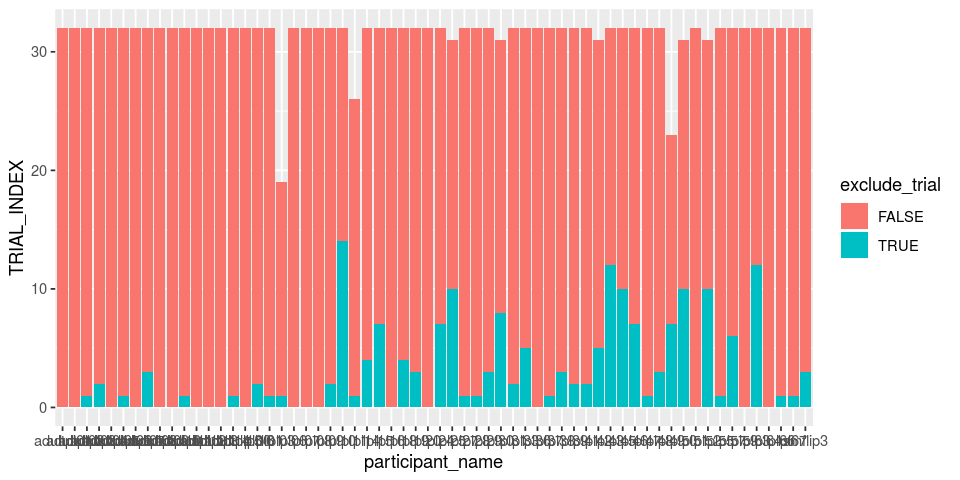

In [147]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(num_trials_per_subj) + geom_bar(aes(x=participant_name, fill=exclude_trial, 
                                           y=TRIAL_INDEX), stat='identity', position="stack")

In [148]:
# whole participants who were excluded
nChildrenWithExcludedTrials = 
length(unique(subset(ed_df, type == 'child' & exclude_trial == T )$participant_name))
nChildrenWithExcludedTrials
tvc = update_texvar_cache(tvc, 'nChildrenWithExcludedTrials', 
    nChildrenWithExcludedTrials)

[1] 36

In [149]:
ed_df$name_trial = paste0(ed_df$participant_name,'_',ed_df$expt_index)

In [150]:
# whole participants who were excluded
nTrialsExcludedByFilter = 
length(unique(subset(ed_df, type == 'child' & exclude_trial == T )$name_trial))
nTrialsExcludedByFilter
tvc = update_texvar_cache(tvc, 'nTrialsExcludedByFilter', 
    nTrialsExcludedByFilter)

[1] 170

In [151]:
percentExcludedEyetrackingTrials = 100 * length(unique(subset(ed_df, type == 'child' & exclude_trial == T )$name_trial)) / length(unique(subset(ed_df, type == 'child')$name_trial))
percentExcludedEyetrackingTrials
tvc = update_texvar_cache(tvc, 'percentExcludedEyetrackingTrials', 
    percentExcludedEyetrackingTrials, digits=0)

[1] 12.9672

In [152]:
# whole participants who were excluded
n_eyetracking_subj_excluded_by_data_filter = length(unique(subset(ed_df, exclude_subject ==T )$participant_name))
n_eyetracking_subj_excluded_by_data_filter
tvc = update_texvar_cache(tvc, 'nEyetrackingSubjExcludedByDataFilter', 
    n_eyetracking_subj_excluded_by_data_filter)
writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

[1] 0

In [153]:
# add the trial order as a grouping variable
ed_df$first3 = 'remainder'
ed_df$first3[ed_df$TRIAL_INDEX <= 7] = 'first 3 test trials'

# Aggregate Eyetracking Timecourses

## Background / PP Version

[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='adult'&expt_version=='scene'_target_.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + novelty + target"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='adult'&expt_version=='scene'_novelty_~target.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + voicing + target"


Warning message:
“Ignoring unknown parameters: shape”

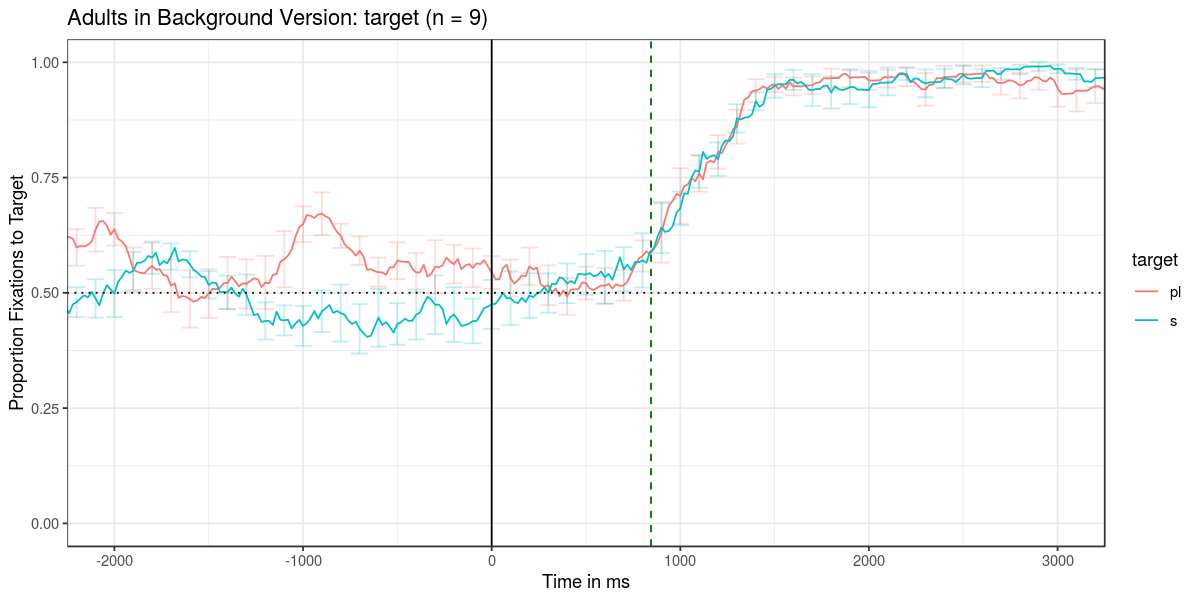

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='adult'&expt_version=='scene'_voicing_~target.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + animacystatus + target"


Warning message:
“Ignoring unknown parameters: shape”

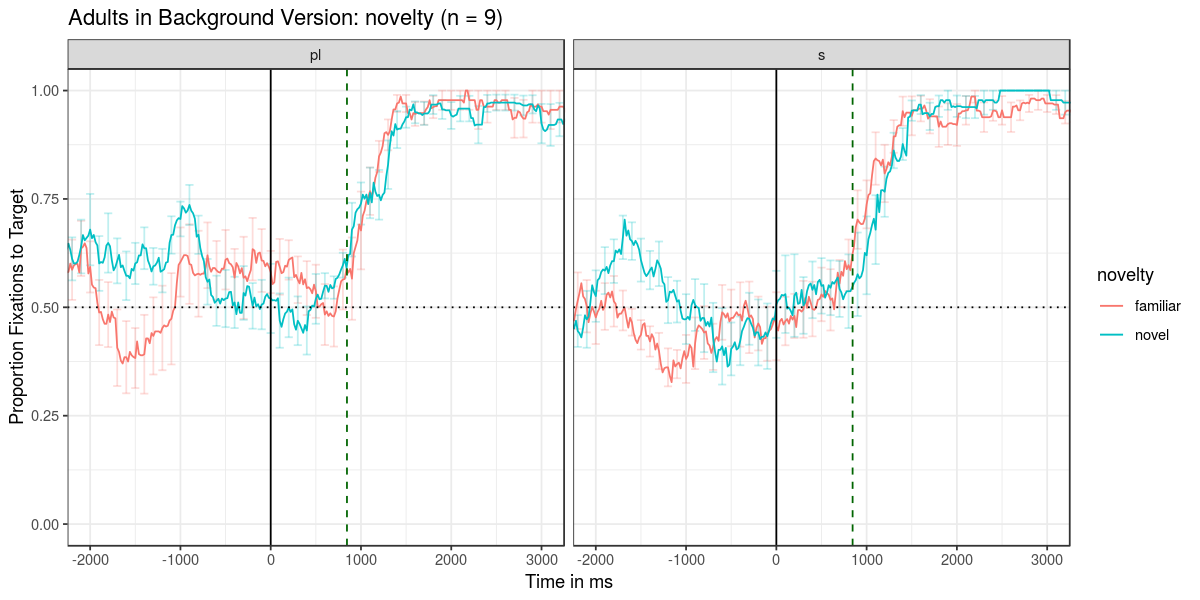

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='adult'&expt_version=='scene'_animacystatus_~target.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

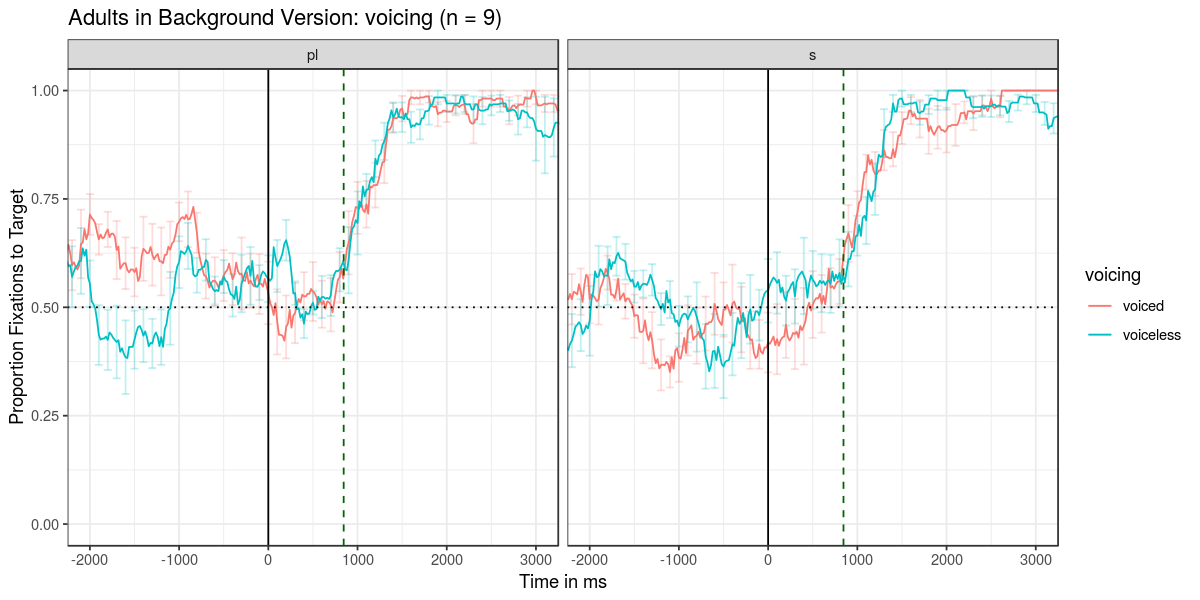

[1] "facet clause:"
[1] "~ label_at_onset"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + label_at_onset"
[1] "figures/type=='adult'&expt_version=='scene'_nullgroup_~label_at_onset.pdf"


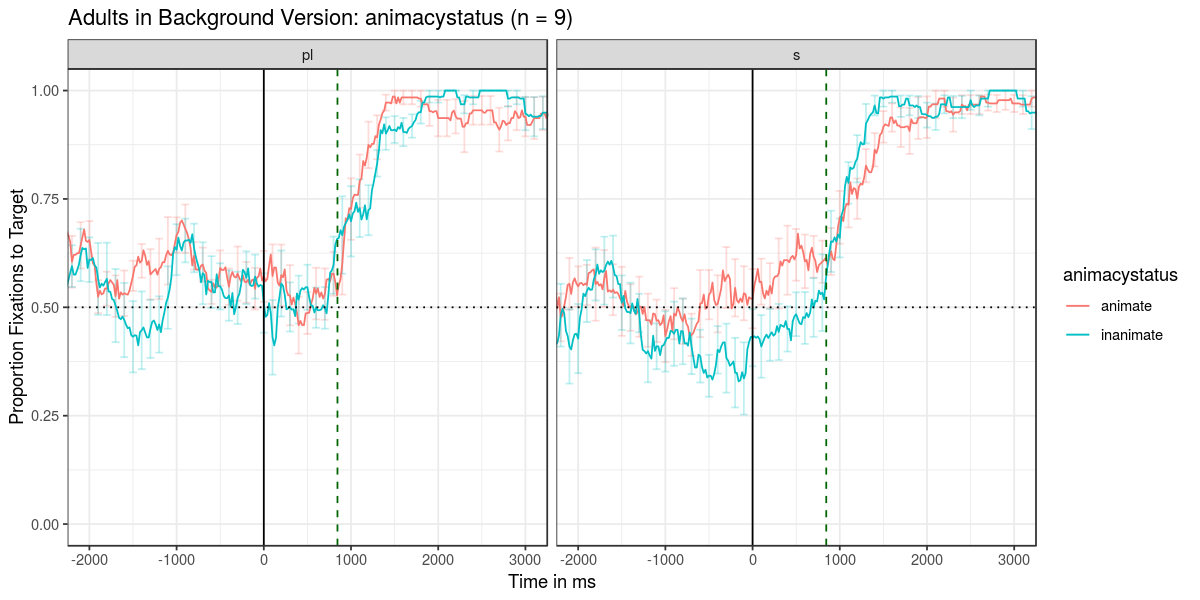

[1] "facet clause:"
[1] "~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + first3"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='adult'&expt_version=='scene'_nullgroup_~first3.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

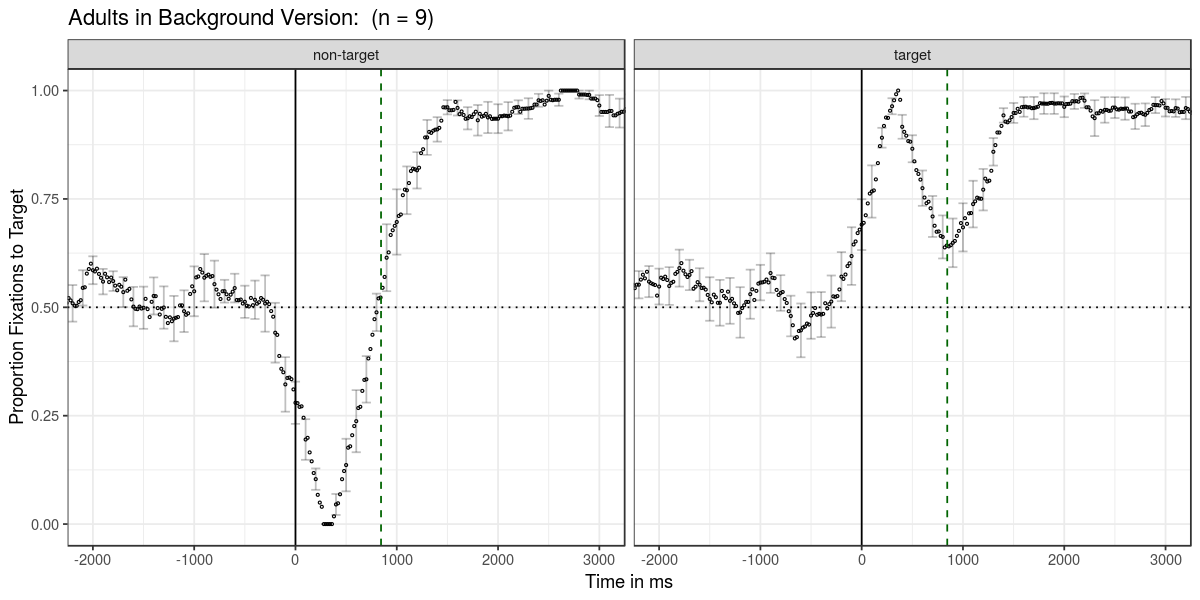

[1] "facet clause:"
[1] "target ~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target+first3"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='adult'&expt_version=='scene'_nullgroup_target~first3.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ novelty"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + novelty"


Warning message:
“Ignoring unknown parameters: shape”

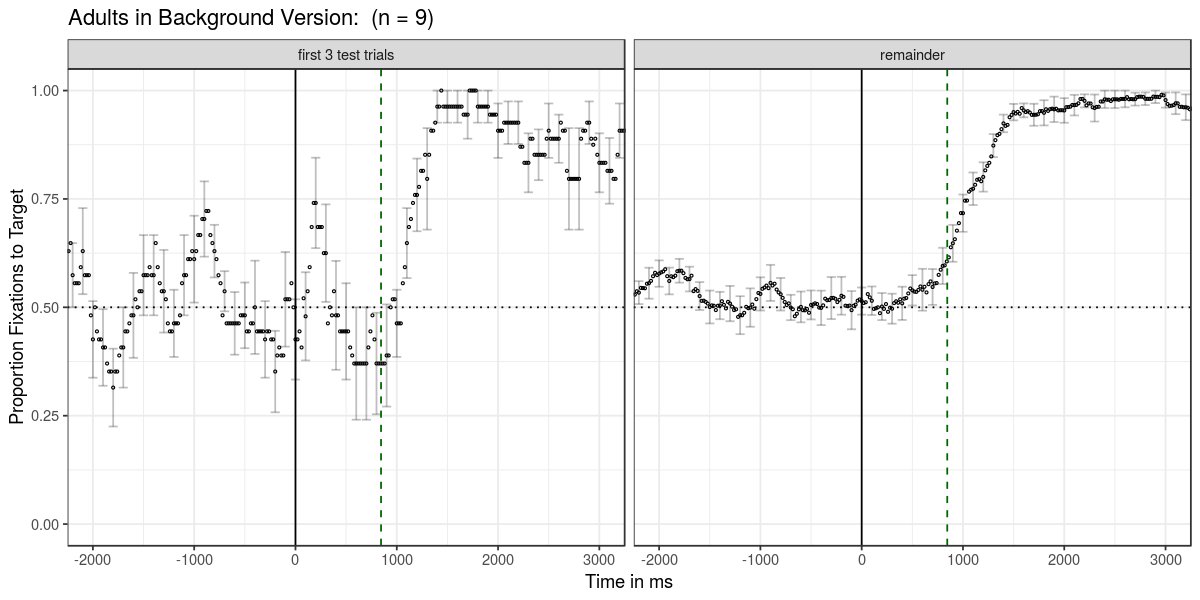

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='adult'&expt_version=='scene'_target_~novelty.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

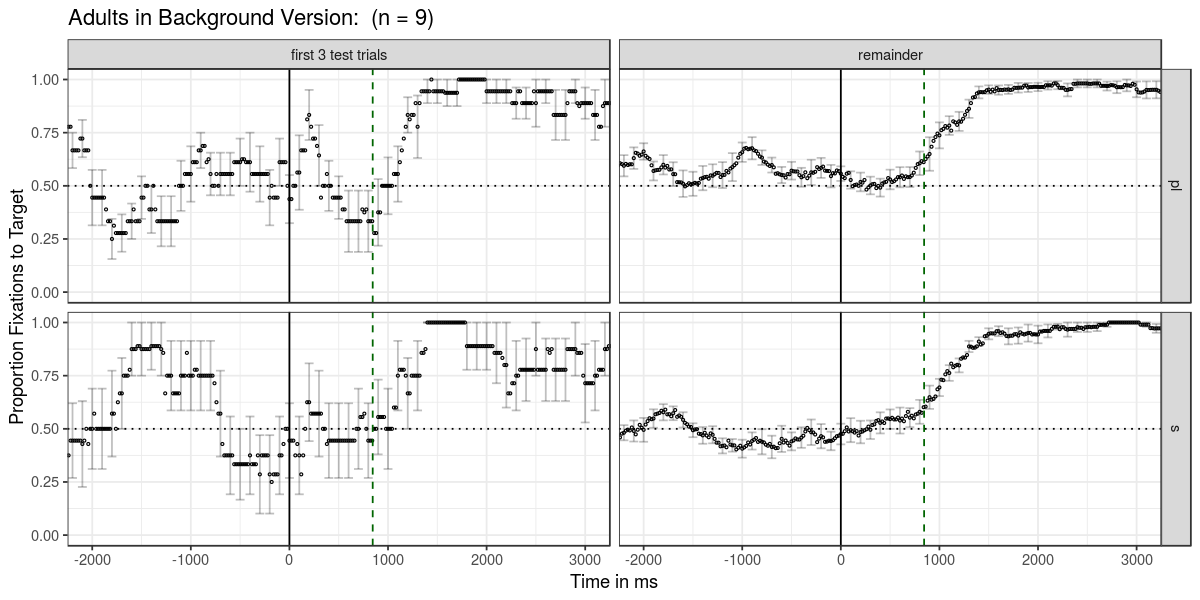

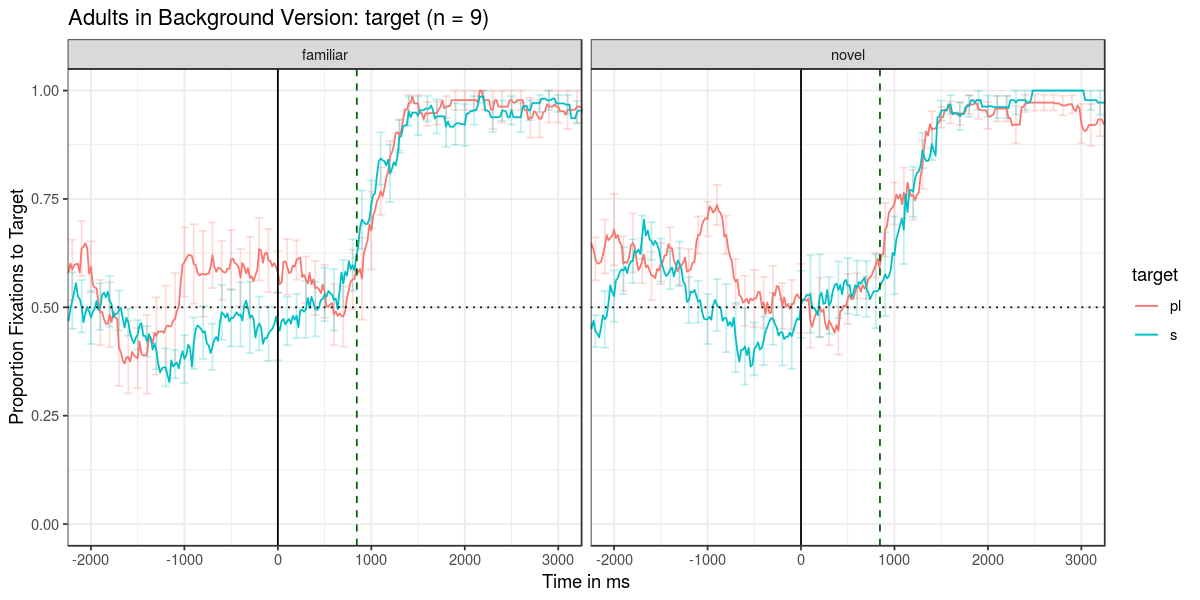

In [162]:
source('PLEARN_analysis_helper.R')
options(repr.plot.width=6, repr.plot.height=6)
getGroupPlots(ed_df, filter_clause = "type == 'adult' & expt_version == 'scene'",
    mean_pp_duration = mean_pp_duration, group_title = 'Adults in Background Version',
    save_plot=T)

[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='scene'_target_.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + novelty + target"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='scene'_novelty_~target.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + voicing + target"


Warning message:
“Ignoring unknown parameters: shape”

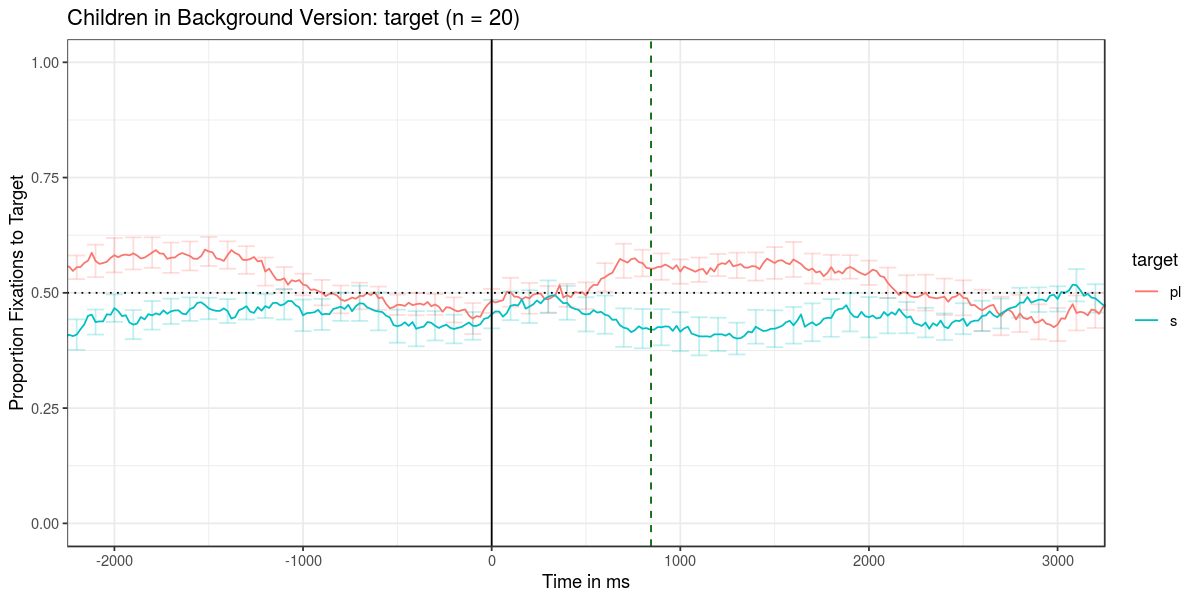

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='scene'_voicing_~target.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + animacystatus + target"


Warning message:
“Ignoring unknown parameters: shape”

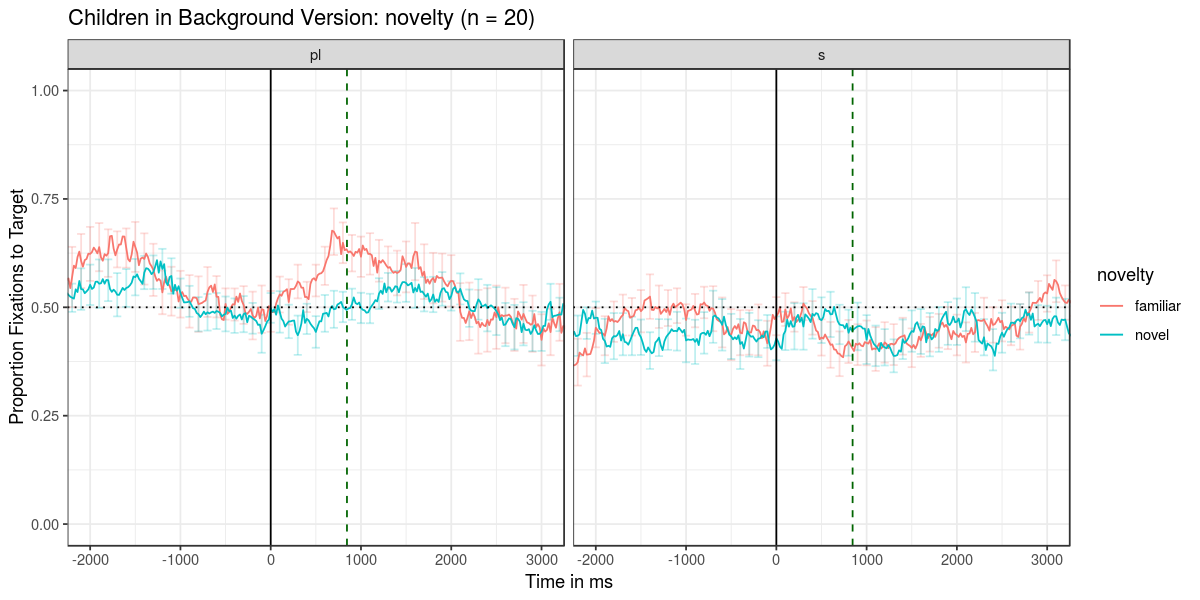

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='scene'_animacystatus_~target.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

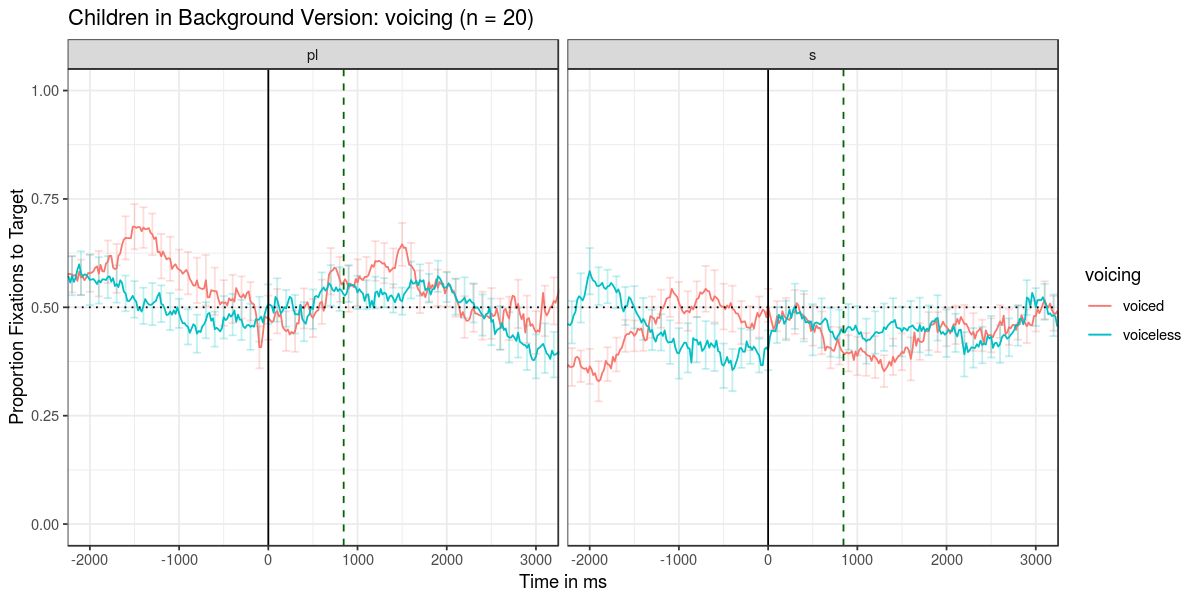

[1] "facet clause:"
[1] "~ label_at_onset"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + label_at_onset"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='scene'_nullgroup_~label_at_onset.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

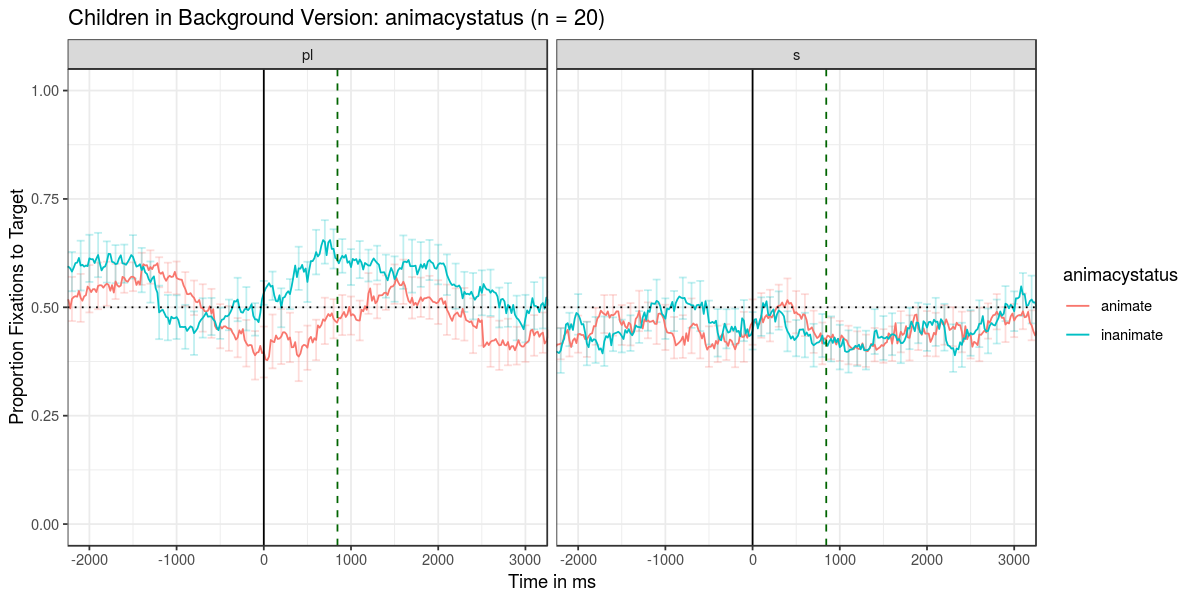

[1] "facet clause:"
[1] "~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + first3"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='scene'_nullgroup_~first3.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

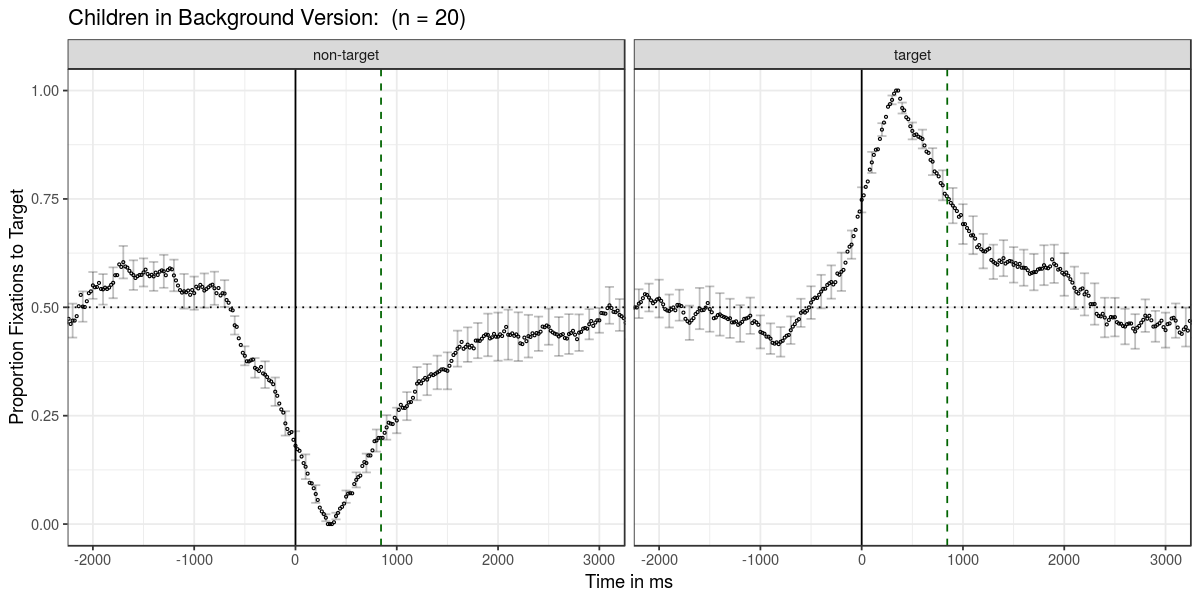

[1] "facet clause:"
[1] "target ~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target+first3"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='scene'_nullgroup_target~first3.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ novelty"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + novelty"


Warning message:
“Ignoring unknown parameters: shape”

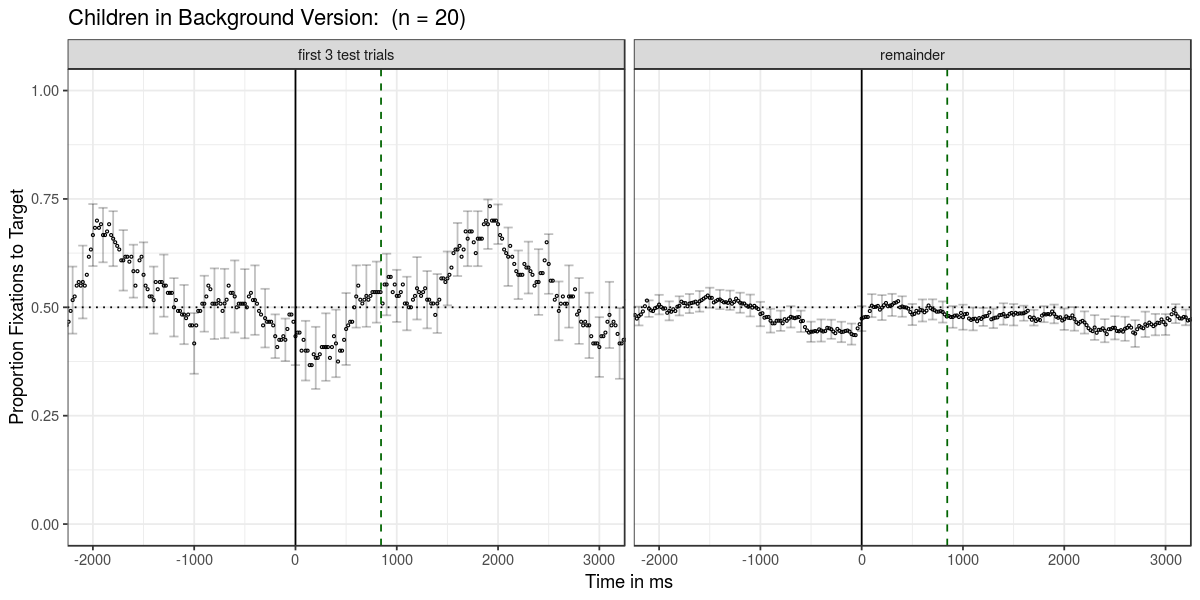

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='scene'_target_~novelty.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

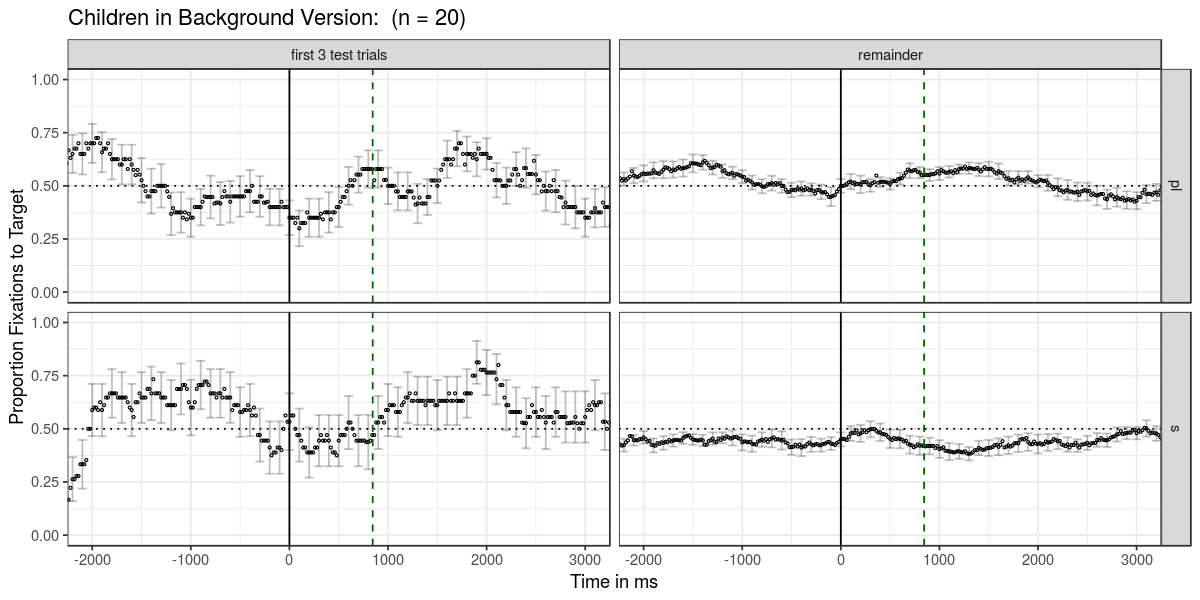

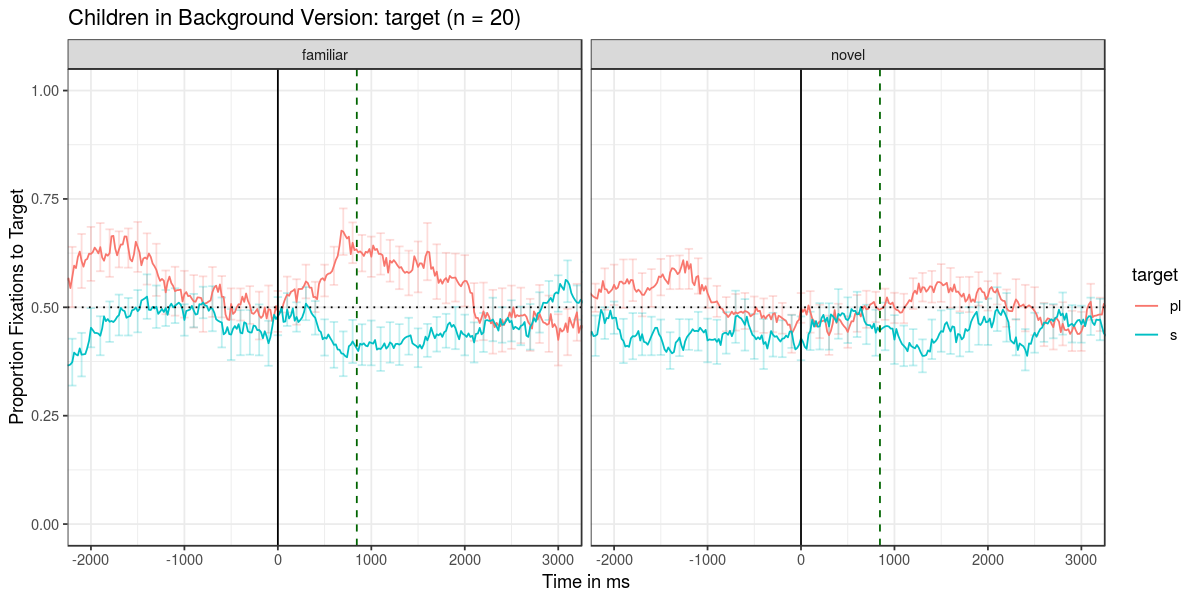

In [164]:
source('PLEARN_analysis_helper.R')
options(repr.plot.width=6, repr.plot.height=6)
getGroupPlots(ed_df, filter_clause = "type == 'child'& expt_version == 'scene'",
    mean_pp_duration = mean_pp_duration, group_title = 'Children in Background Version',
    save_plot=T)

[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target"


Warning message:
“Ignoring unknown parameters: shape”

[1] "figures/type=='child'&age_in_days>=915&expt_version=='scene'_target_.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + novelty + target"


Warning message:
“Ignoring unknown parameters: shape”

[1] "figures/type=='child'&age_in_days>=915&expt_version=='scene'_novelty_~target.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + voicing + target"


Warning message:
“Ignoring unknown parameters: shape”

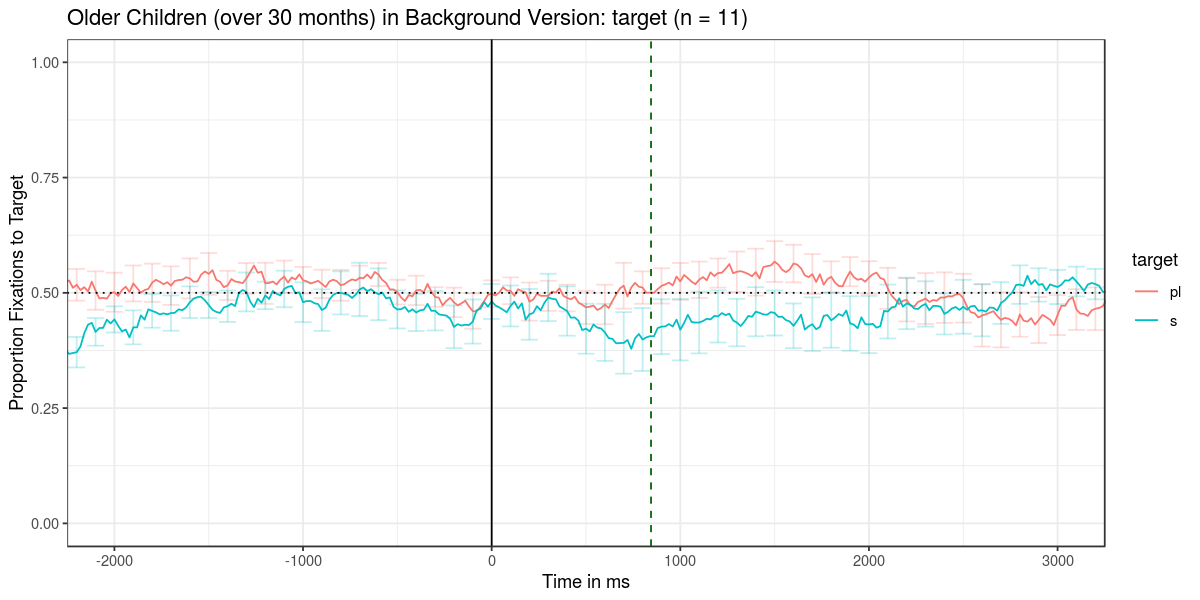

[1] "figures/type=='child'&age_in_days>=915&expt_version=='scene'_voicing_~target.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + animacystatus + target"


Warning message:
“Ignoring unknown parameters: shape”

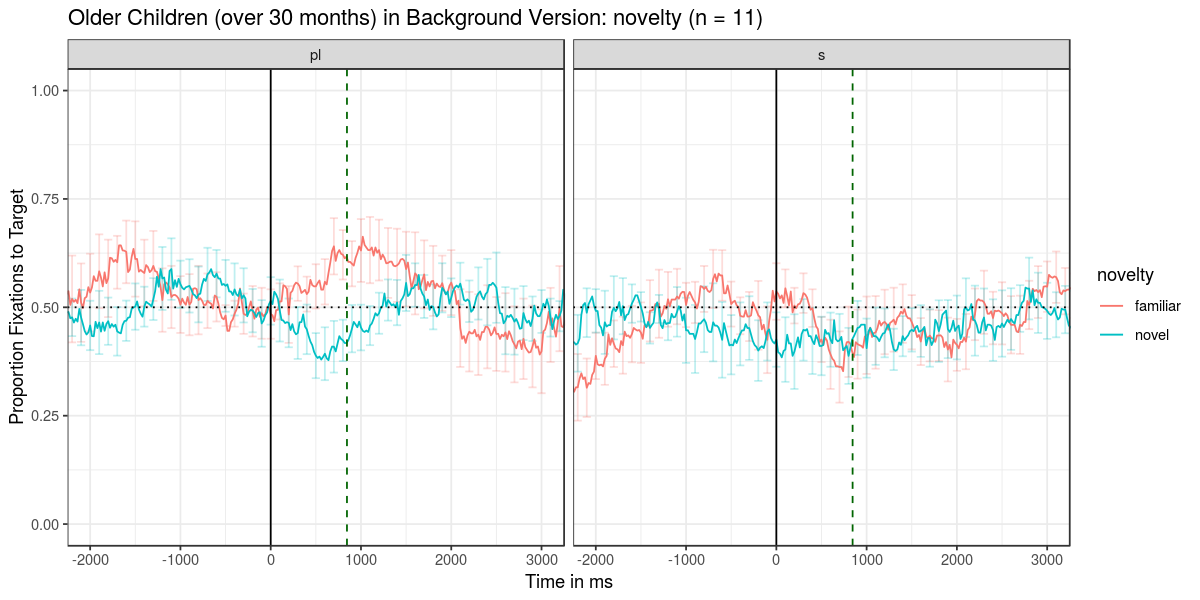

[1] "figures/type=='child'&age_in_days>=915&expt_version=='scene'_animacystatus_~target.pdf"


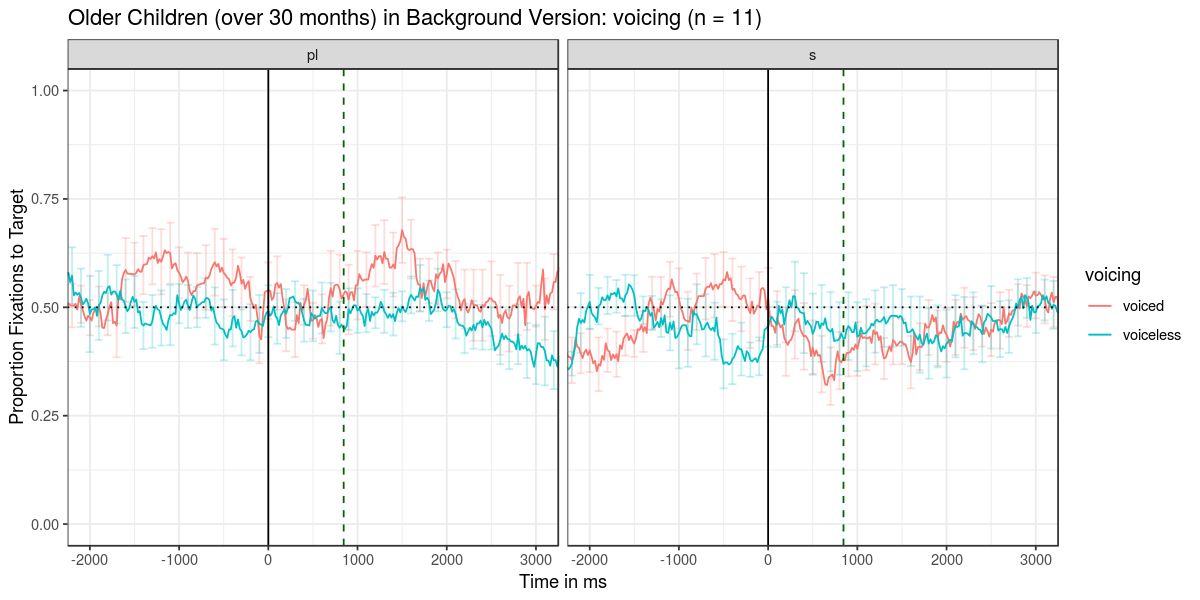

[1] "facet clause:"
[1] "~ label_at_onset"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + label_at_onset"
[1] "figures/type=='child'&age_in_days>=915&expt_version=='scene'_nullgroup_~label_at_onset.pdf"


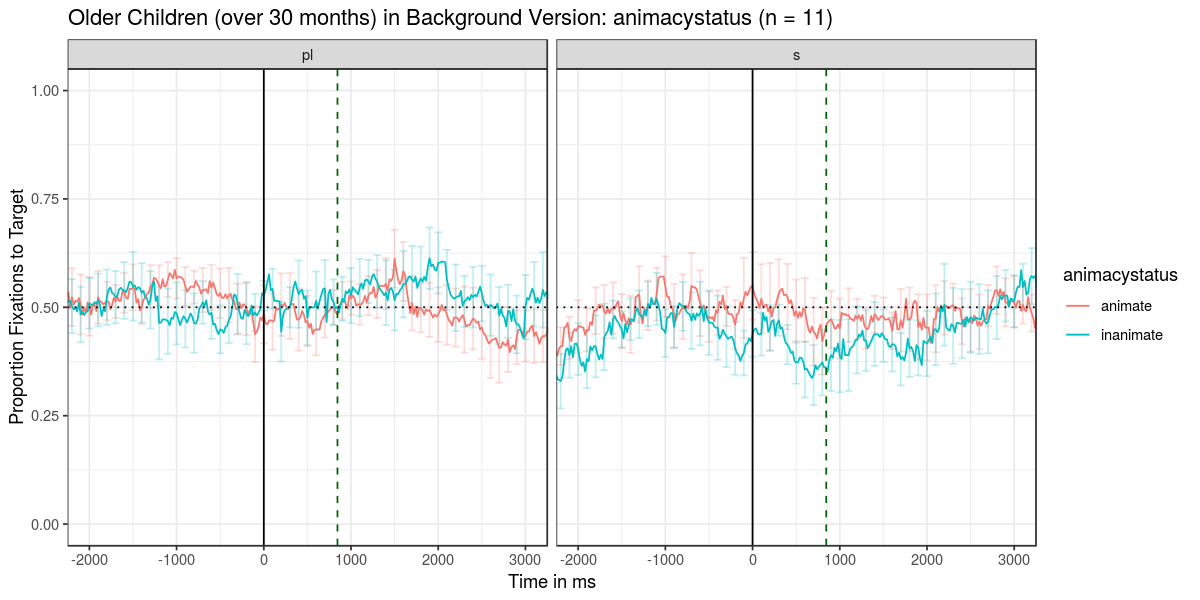

[1] "facet clause:"
[1] "~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + first3"
[1] "figures/type=='child'&age_in_days>=915&expt_version=='scene'_nullgroup_~first3.pdf"


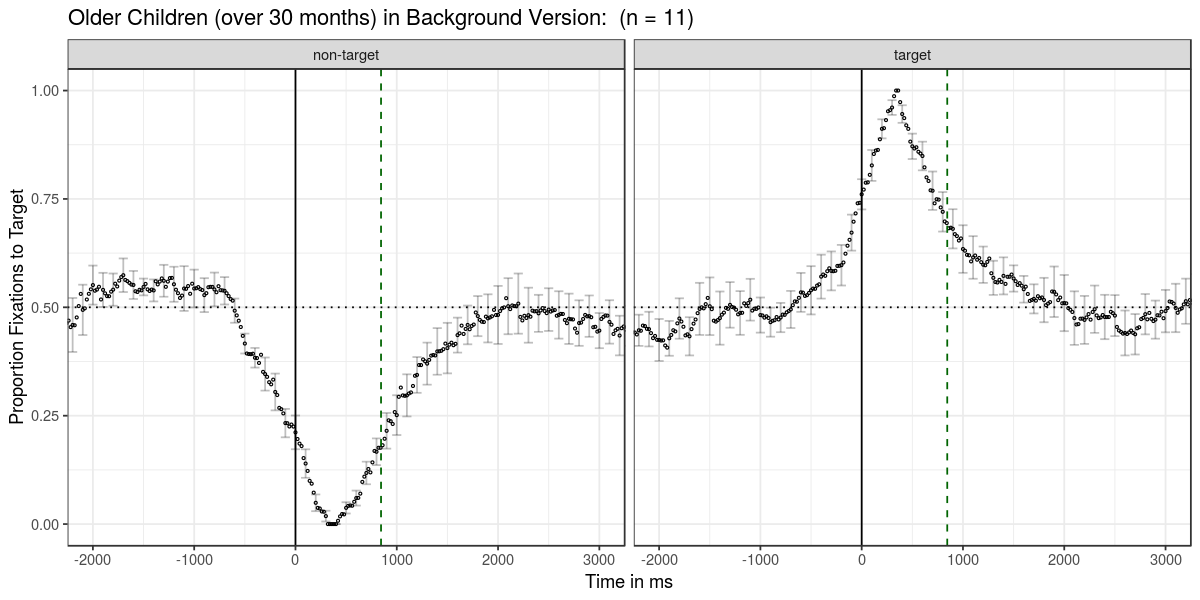

[1] "facet clause:"
[1] "target ~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target+first3"
[1] "figures/type=='child'&age_in_days>=915&expt_version=='scene'_nullgroup_target~first3.pdf"
[1] "facet clause:"
[1] "~ novelty"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + novelty"


Warning message:
“Ignoring unknown parameters: shape”

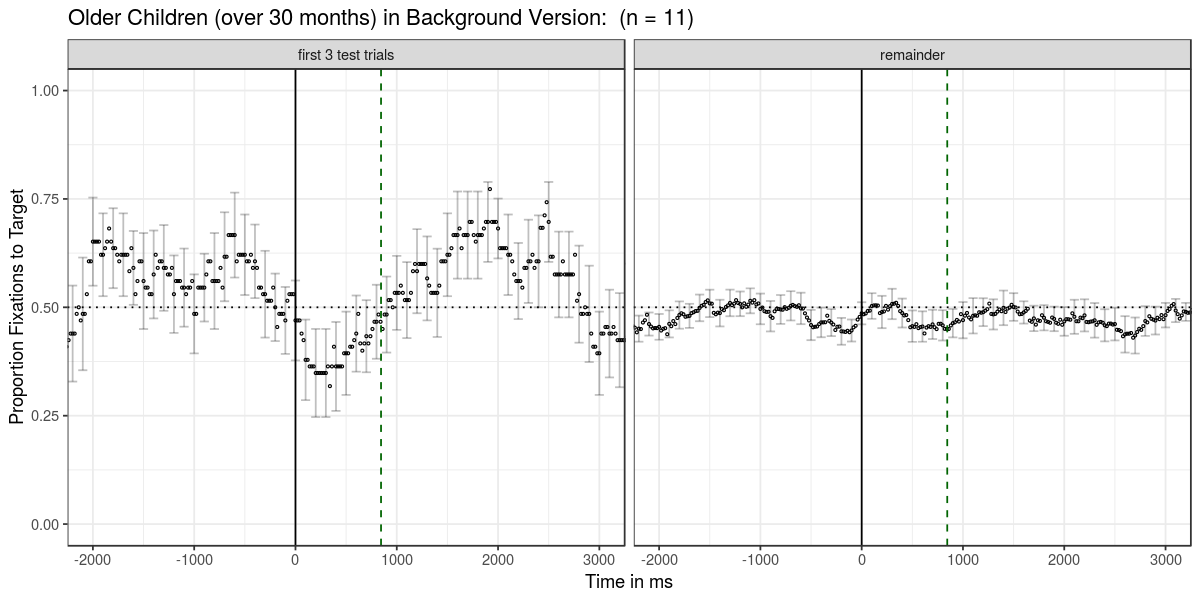

[1] "figures/type=='child'&age_in_days>=915&expt_version=='scene'_target_~novelty.pdf"


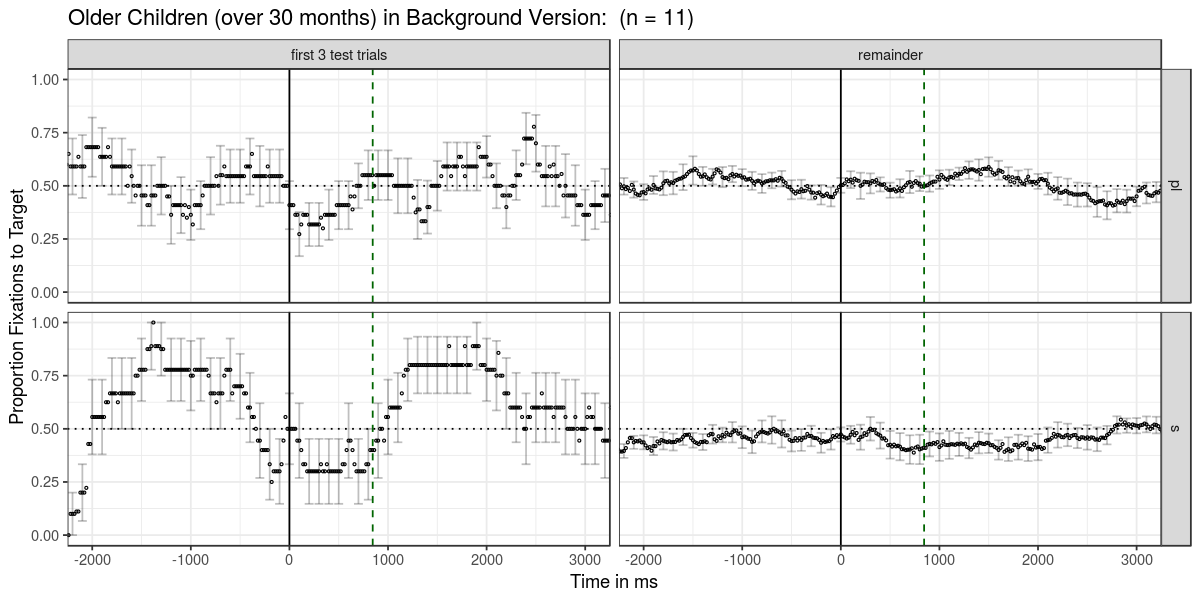

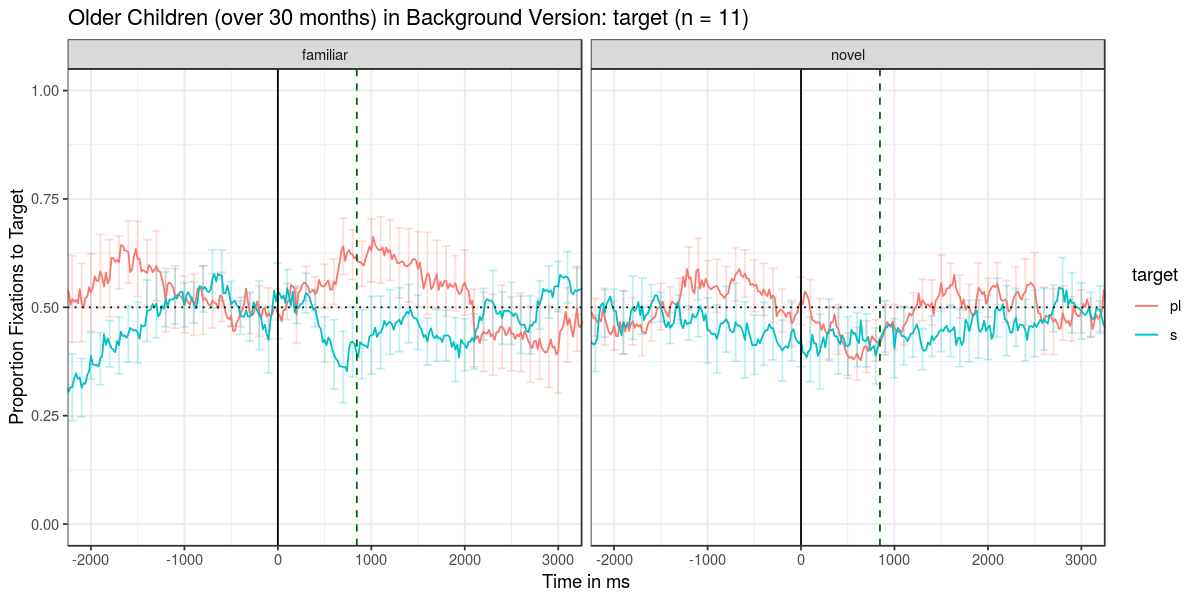

In [165]:
source('PLEARN_analysis_helper.R')
options(repr.plot.width=6, repr.plot.height=6)
getGroupPlots(ed_df, filter_clause = "type == 'child' & age_in_days >= 915 & expt_version == 'scene'",
    mean_pp_duration = mean_pp_duration, 
    group_title = 'Older Children (over 30 months) in Background Version', save_plot=T)

[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&broad_score>.5&expt_version=='scene'_target_.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + novelty + target"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&broad_score>.5&expt_version=='scene'_novelty_~target.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + voicing + target"


Warning message:
“Ignoring unknown parameters: shape”

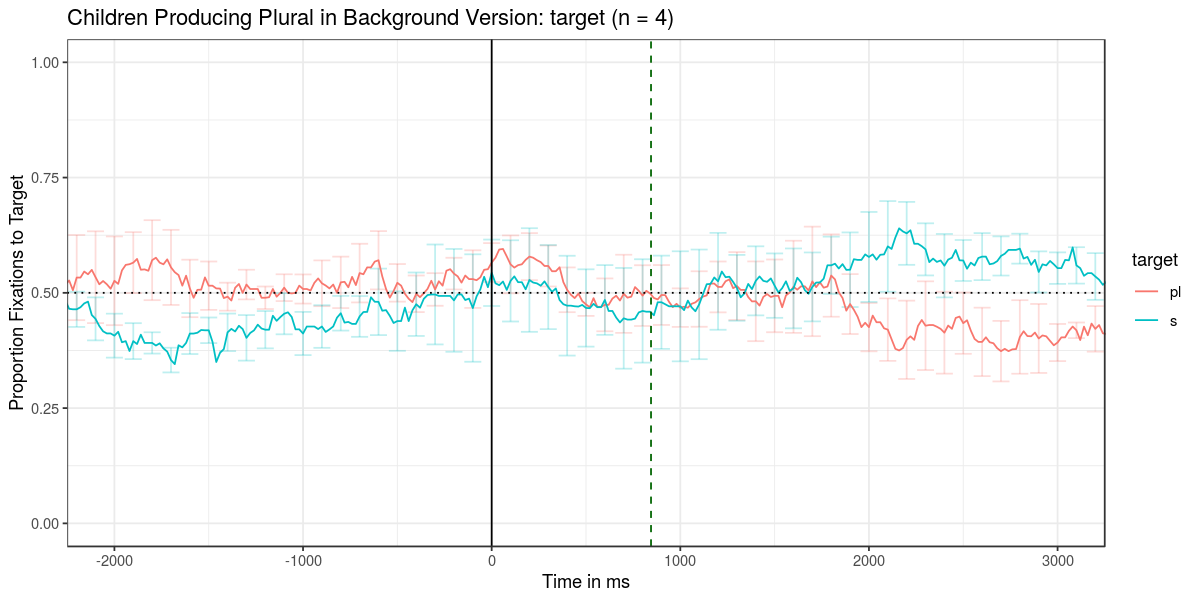

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&broad_score>.5&expt_version=='scene'_voicing_~target.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + animacystatus + target"


Warning message:
“Ignoring unknown parameters: shape”

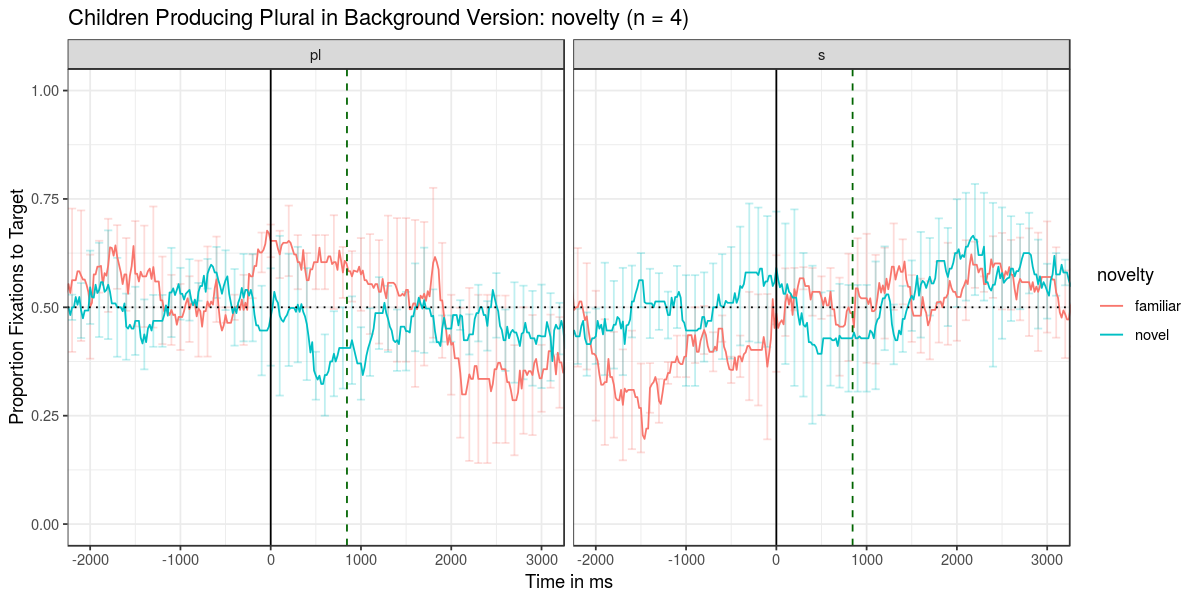

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&broad_score>.5&expt_version=='scene'_animacystatus_~target.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

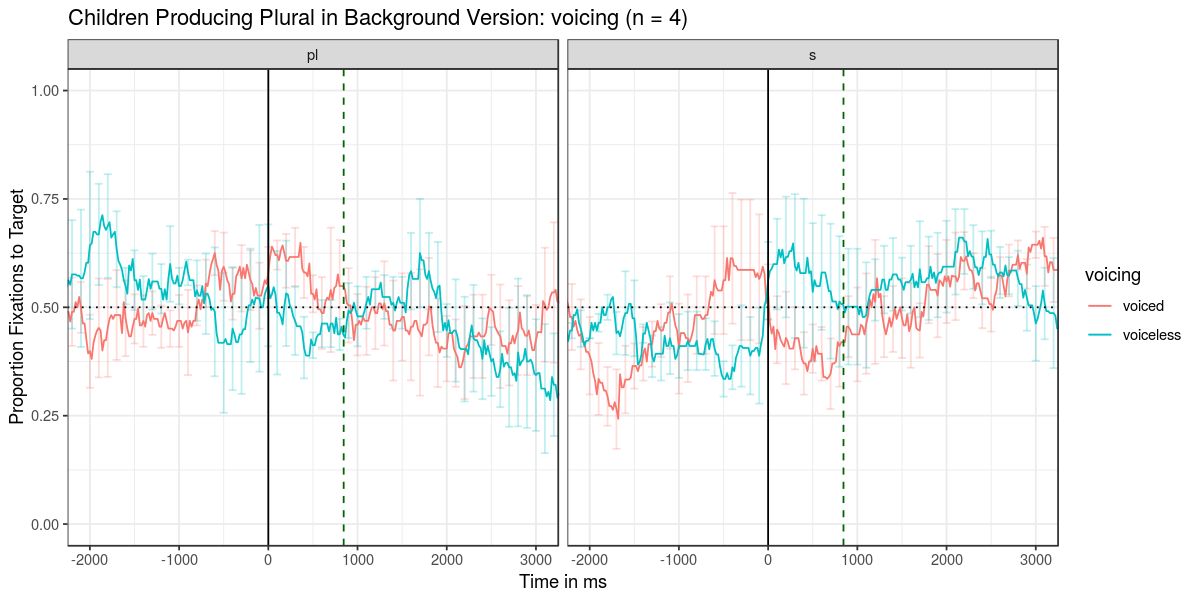

[1] "facet clause:"
[1] "~ label_at_onset"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + label_at_onset"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&broad_score>.5&expt_version=='scene'_nullgroup_~label_at_onset.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

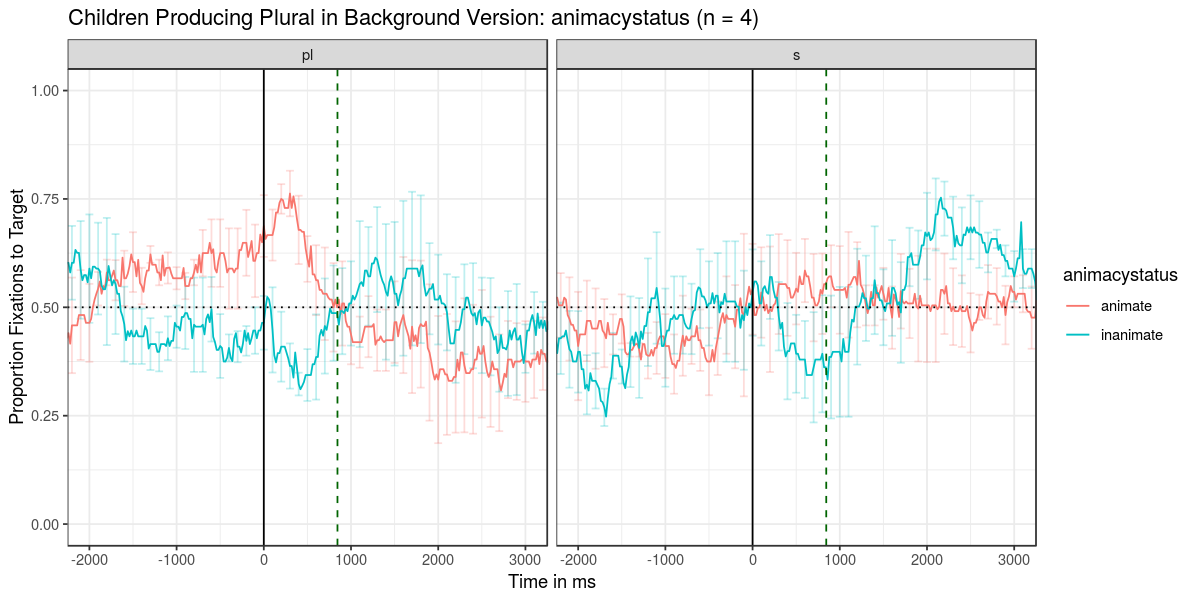

[1] "facet clause:"
[1] "~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + first3"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&broad_score>.5&expt_version=='scene'_nullgroup_~first3.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

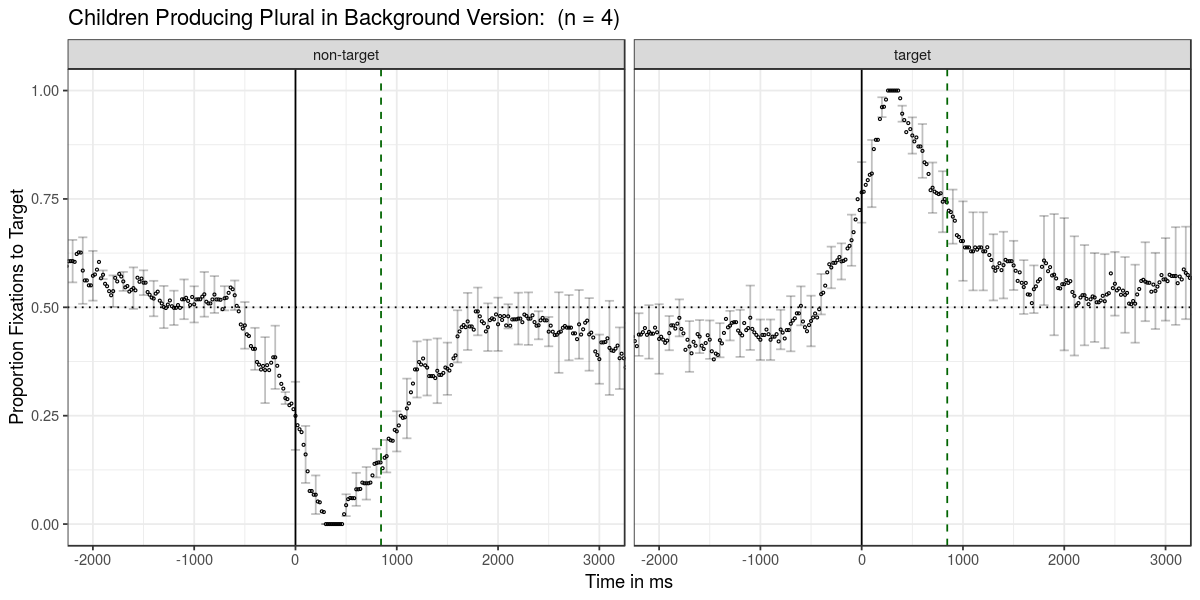

[1] "facet clause:"
[1] "target ~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target+first3"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&broad_score>.5&expt_version=='scene'_nullgroup_target~first3.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ novelty"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + novelty"


Warning message:
“Ignoring unknown parameters: shape”

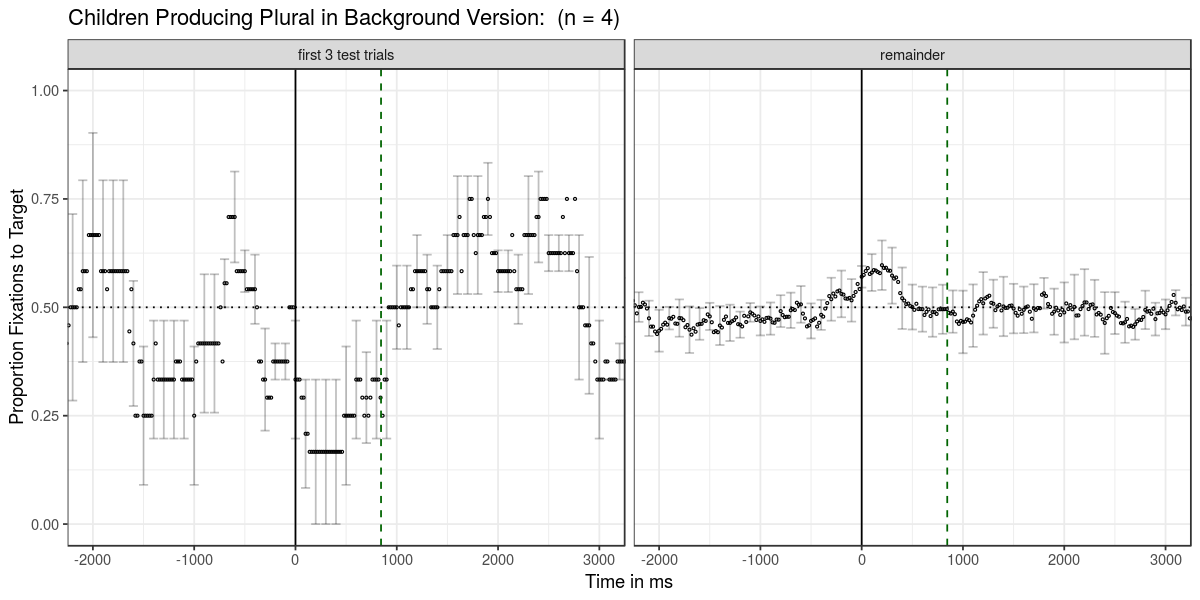

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&broad_score>.5&expt_version=='scene'_target_~novelty.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

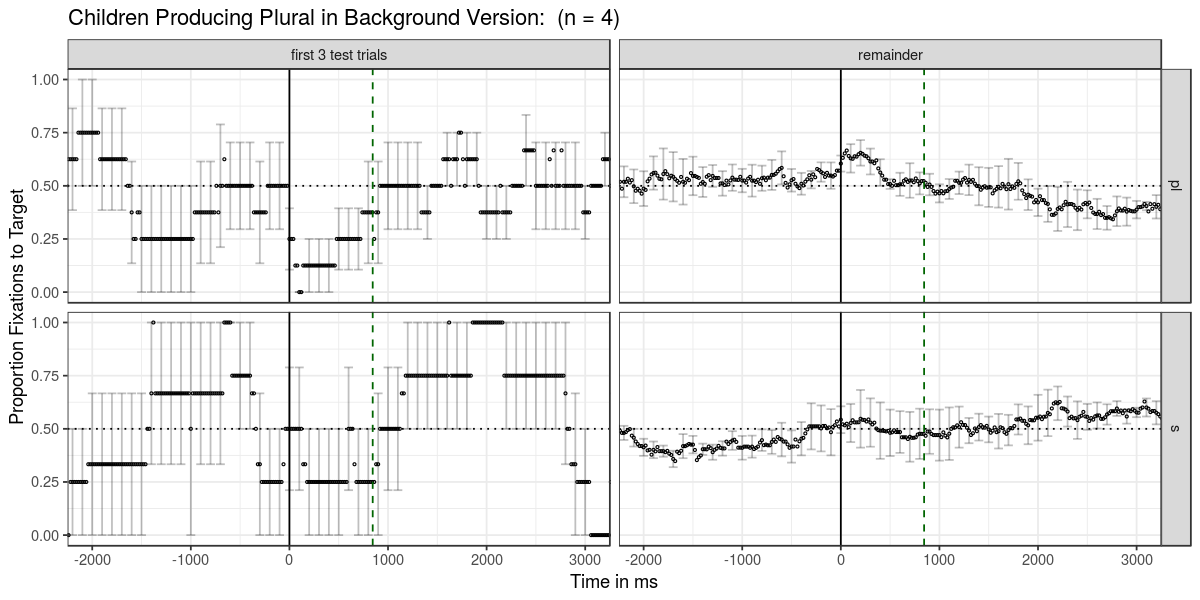

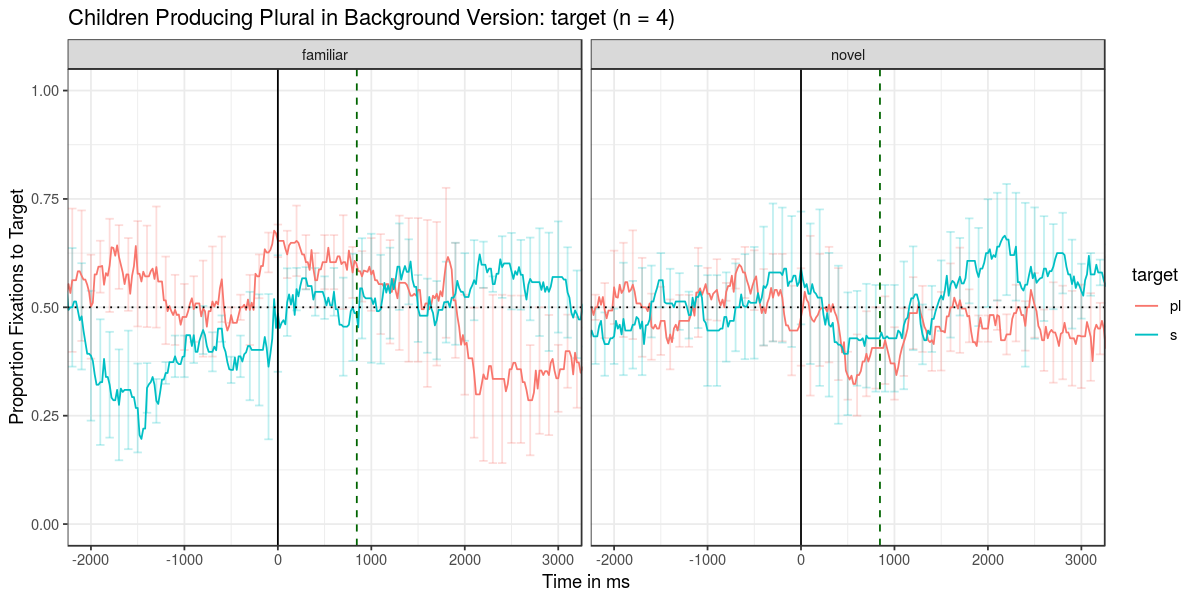

In [166]:
source('PLEARN_analysis_helper.R')
options(repr.plot.width=6, repr.plot.height=6)
getGroupPlots(ed_df, filter_clause = "type == 'child' & broad_score > .5 & expt_version == 'scene' ",
    mean_pp_duration = mean_pp_duration, 
    group_title = 'Children Producing Plural in Background Version', save_plot=T)

## Red/Blue (Simplified) Version

[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target"


Warning message:
“Ignoring unknown parameters: shape”

[1] "figures/type=='adult'&expt_version=='redblue'_target_.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + novelty + target"


Warning message:
“Ignoring unknown parameters: shape”

[1] "figures/type=='adult'&expt_version=='redblue'_novelty_~target.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + voicing + target"


Warning message:
“Ignoring unknown parameters: shape”

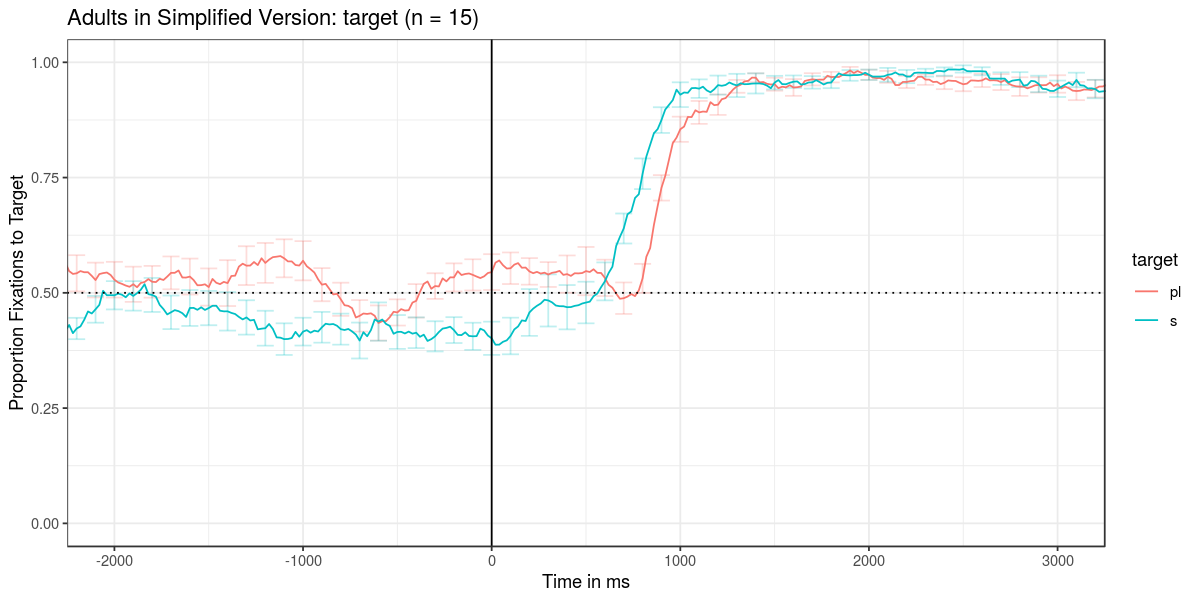

[1] "figures/type=='adult'&expt_version=='redblue'_voicing_~target.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + animacystatus + target"


Warning message:
“Ignoring unknown parameters: shape”

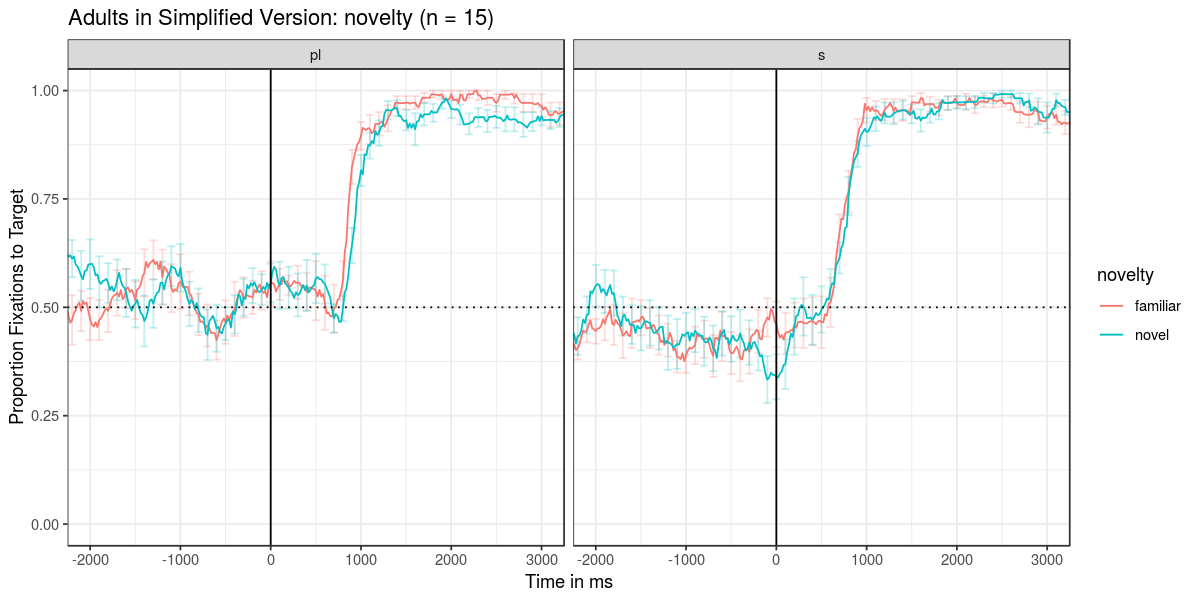

[1] "figures/type=='adult'&expt_version=='redblue'_animacystatus_~target.pdf"


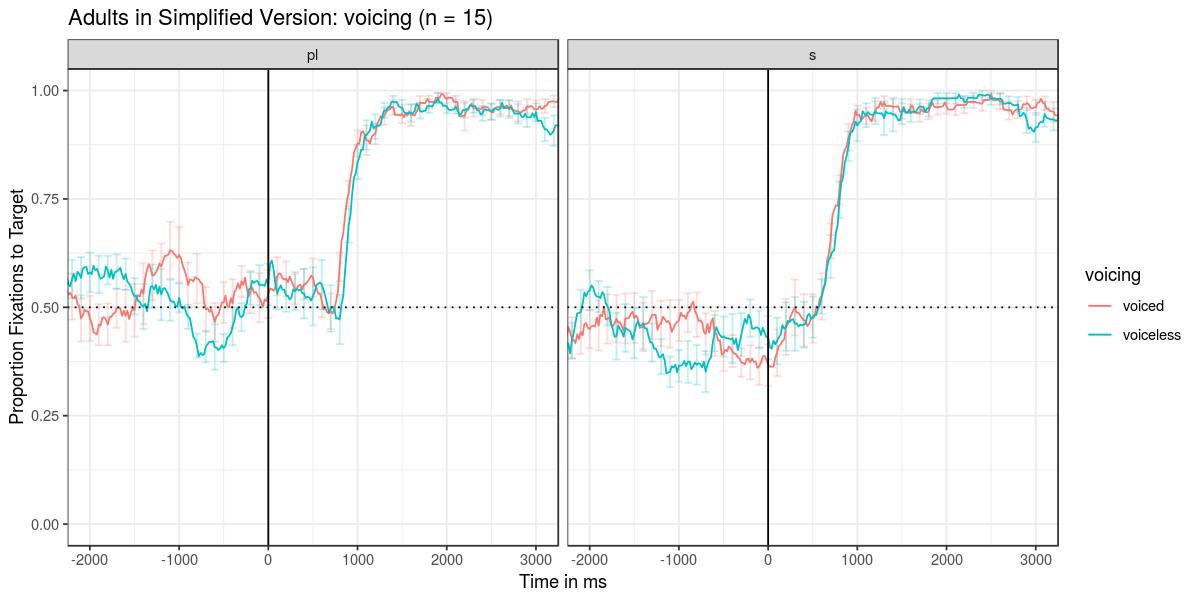

[1] "facet clause:"
[1] "~ label_at_onset"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + label_at_onset"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='adult'&expt_version=='redblue'_nullgroup_~label_at_onset.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

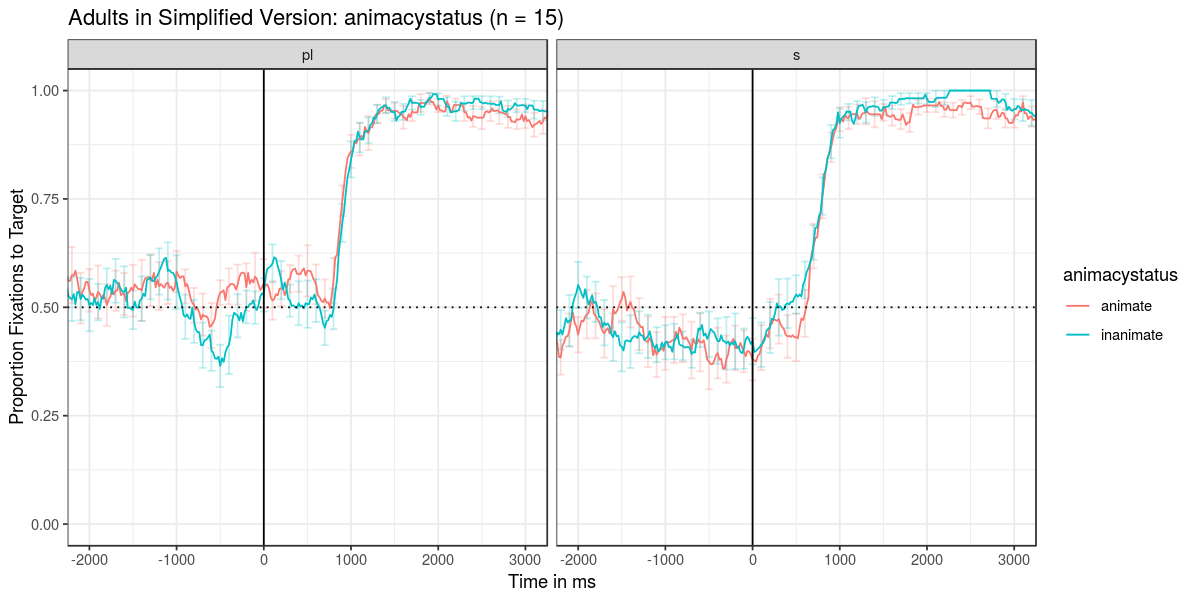

[1] "facet clause:"
[1] "~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + first3"
[1] "figures/type=='adult'&expt_version=='redblue'_nullgroup_~first3.pdf"


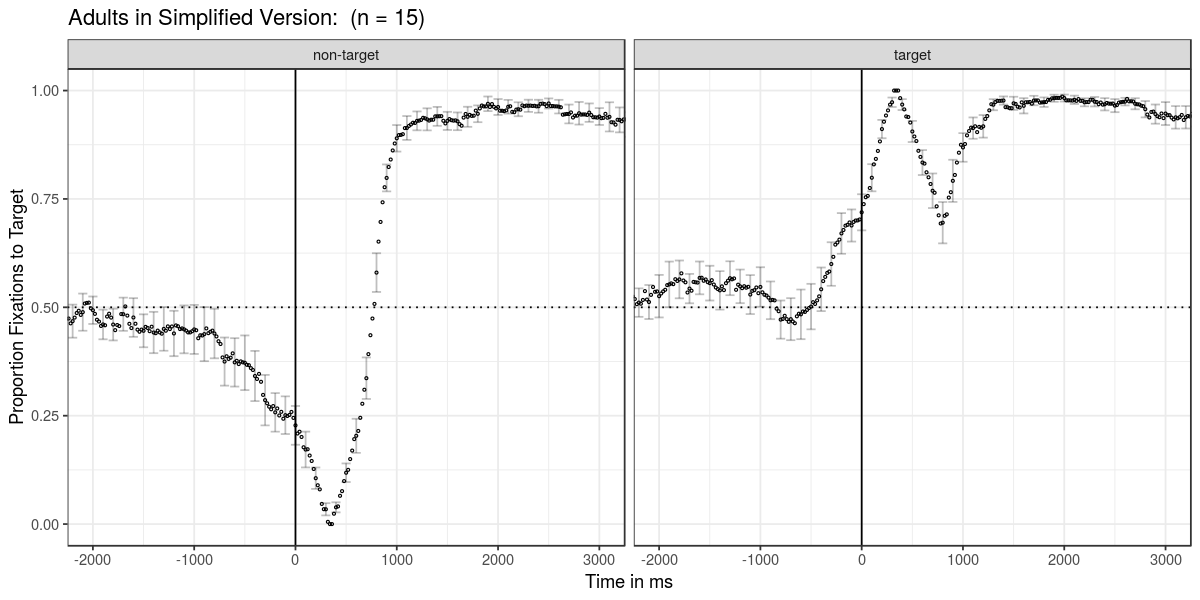

[1] "facet clause:"
[1] "target ~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target+first3"
[1] "figures/type=='adult'&expt_version=='redblue'_nullgroup_target~first3.pdf"
[1] "facet clause:"
[1] "~ novelty"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + novelty"


Warning message:
“Ignoring unknown parameters: shape”

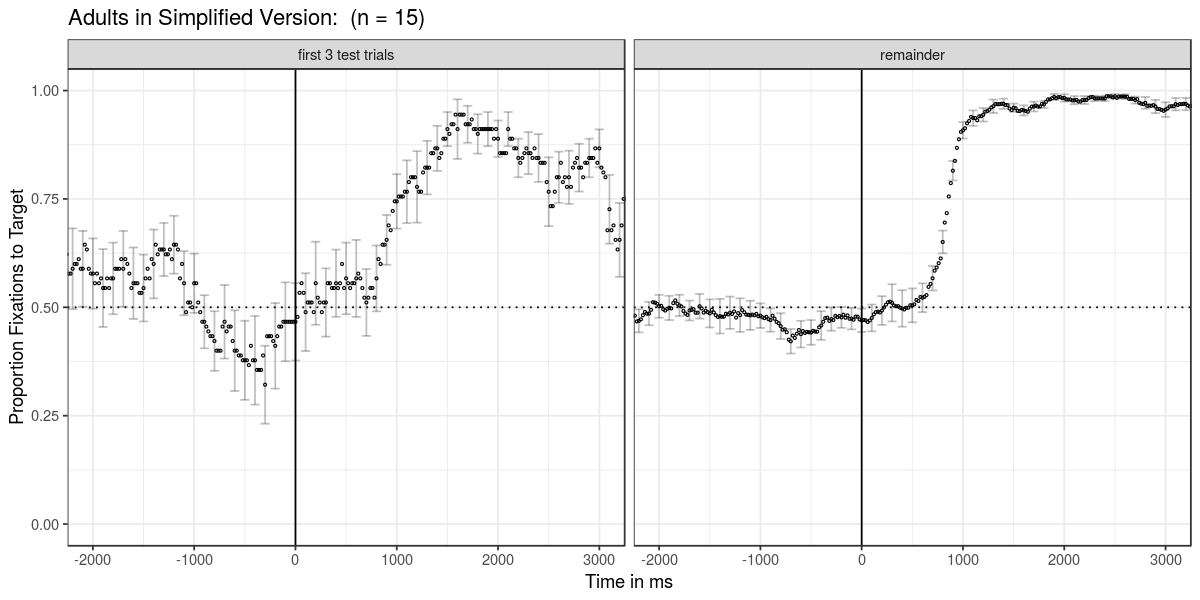

[1] "figures/type=='adult'&expt_version=='redblue'_target_~novelty.pdf"


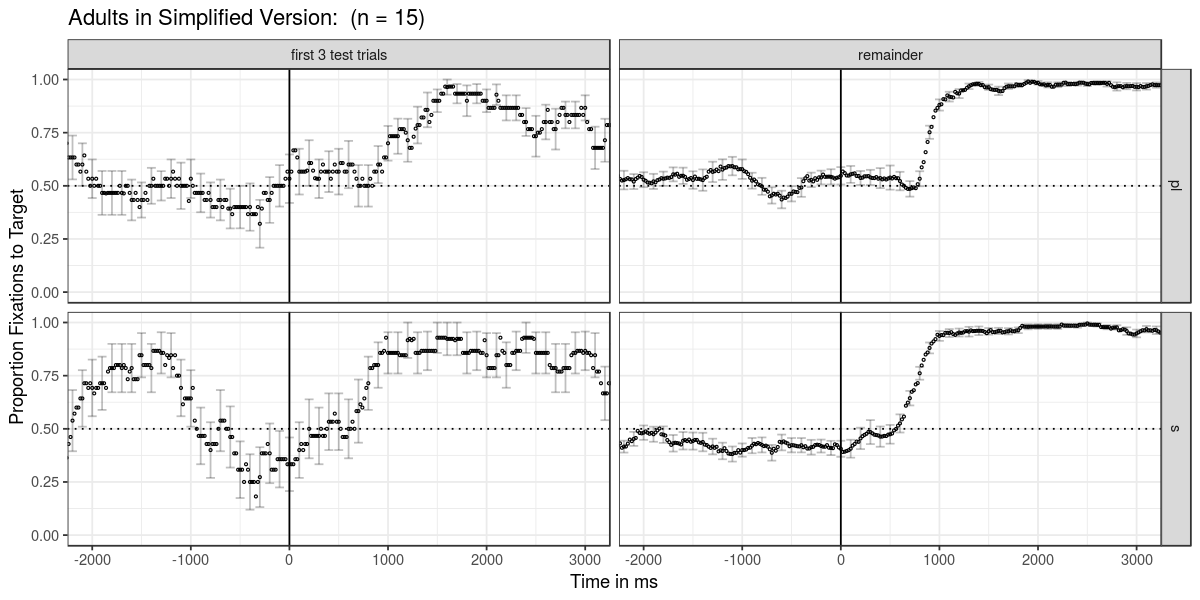

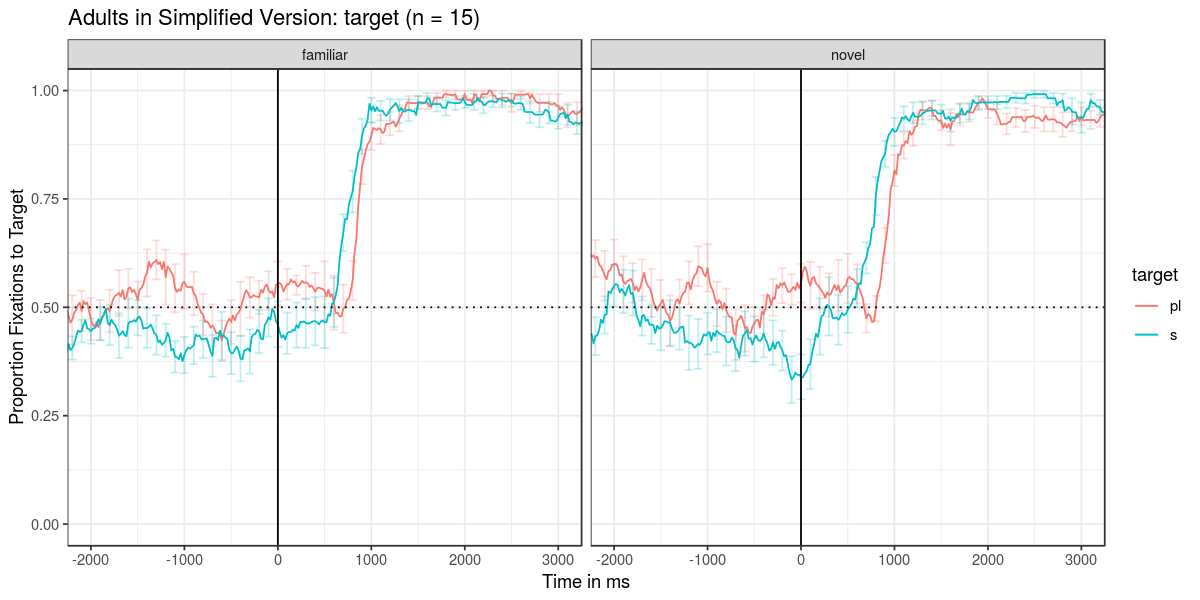

In [163]:
source('PLEARN_analysis_helper.R')
options(repr.plot.width=6, repr.plot.height=6)
getGroupPlots(ed_df, filter_clause = "type == 'adult' & expt_version == 'redblue'",
    mean_pp_duration = NULL, group_title = 'Adults in Simplified Version', save_plot=T)

[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target"


Warning message:
“Ignoring unknown parameters: shape”

[1] "figures/type=='child'&expt_version=='redblue'_target_.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + novelty + target"


Warning message:
“Ignoring unknown parameters: shape”

[1] "figures/type=='child'&expt_version=='redblue'_novelty_~target.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + voicing + target"


Warning message:
“Ignoring unknown parameters: shape”

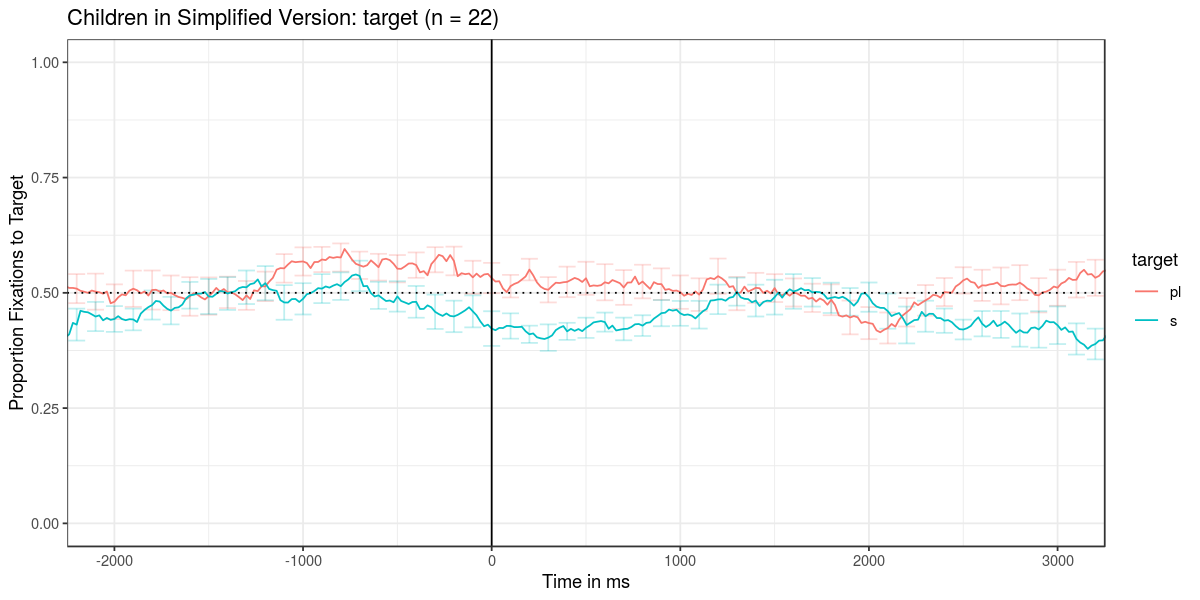

[1] "figures/type=='child'&expt_version=='redblue'_voicing_~target.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + animacystatus + target"


Warning message:
“Ignoring unknown parameters: shape”

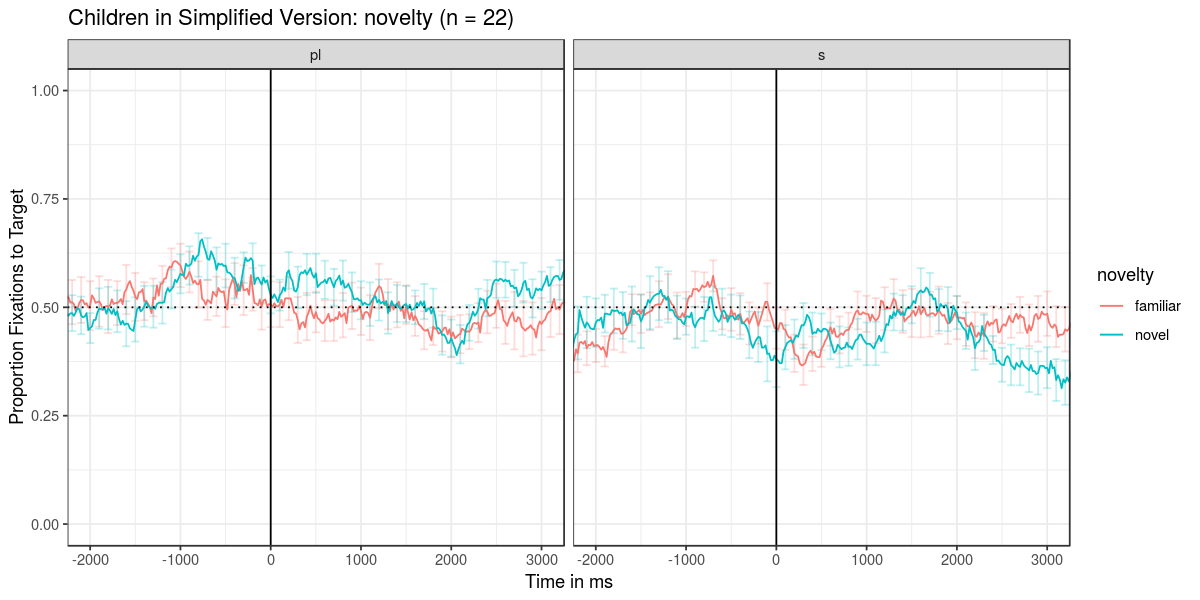

[1] "figures/type=='child'&expt_version=='redblue'_animacystatus_~target.pdf"


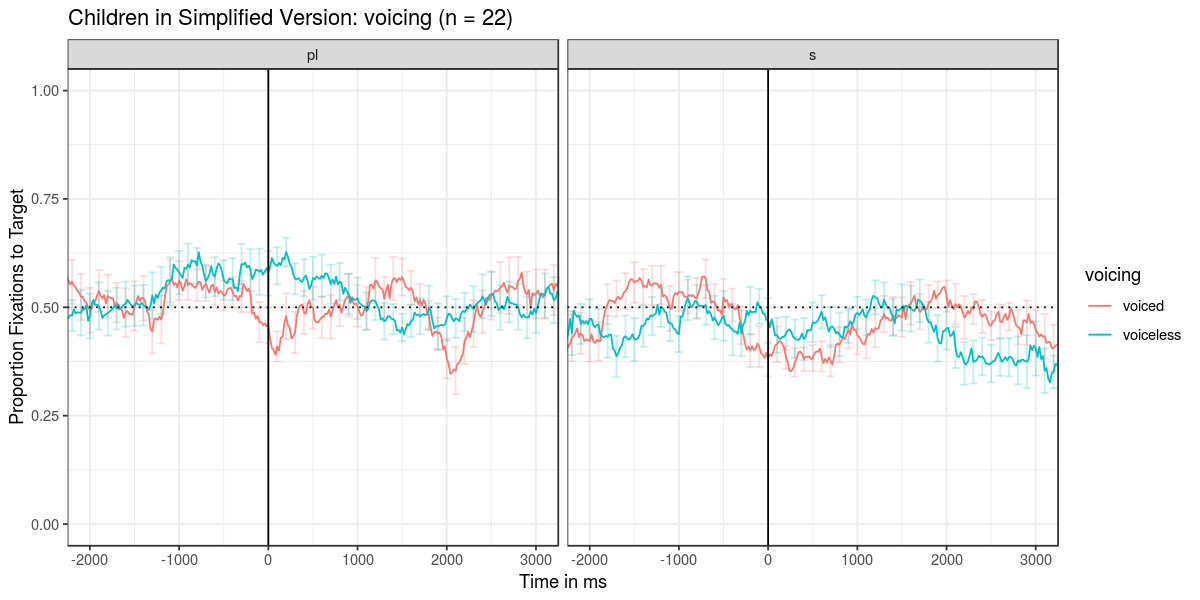

[1] "facet clause:"
[1] "~ label_at_onset"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + label_at_onset"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='redblue'_nullgroup_~label_at_onset.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

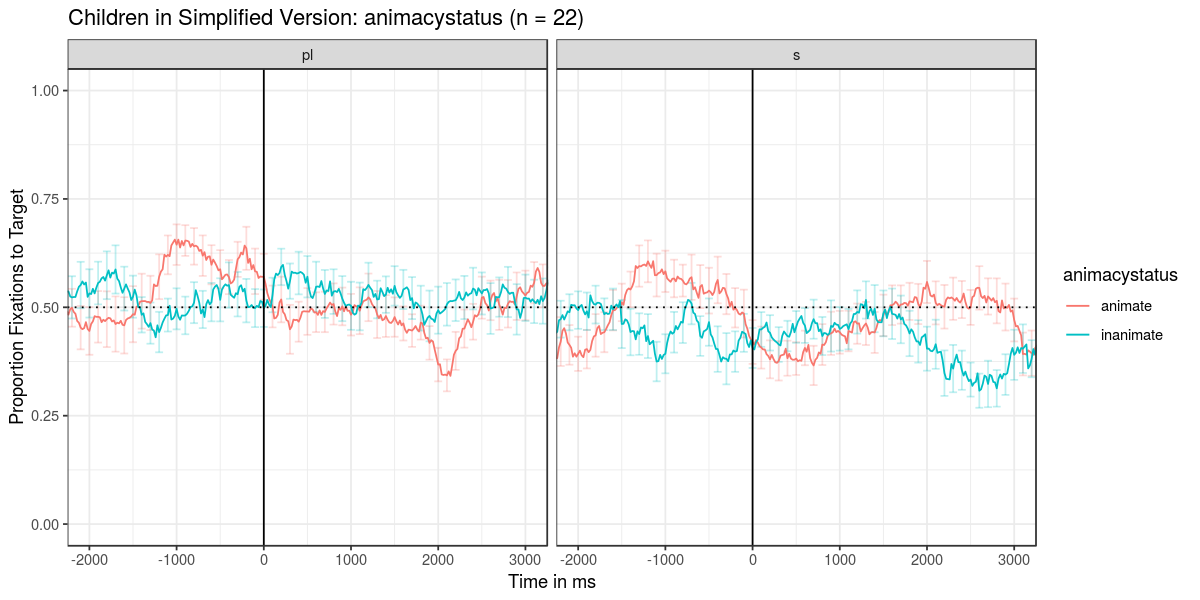

[1] "facet clause:"
[1] "~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + first3"
[1] "figures/type=='child'&expt_version=='redblue'_nullgroup_~first3.pdf"


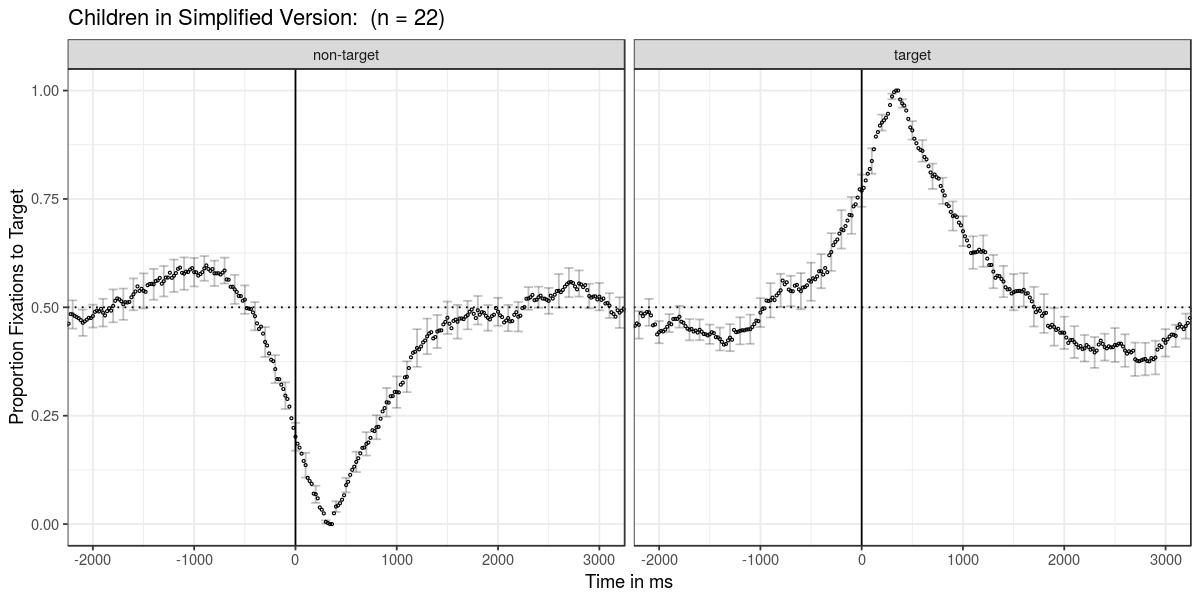

[1] "facet clause:"
[1] "target ~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target+first3"
[1] "figures/type=='child'&expt_version=='redblue'_nullgroup_target~first3.pdf"
[1] "facet clause:"
[1] "~ novelty"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + novelty"


Warning message:
“Ignoring unknown parameters: shape”

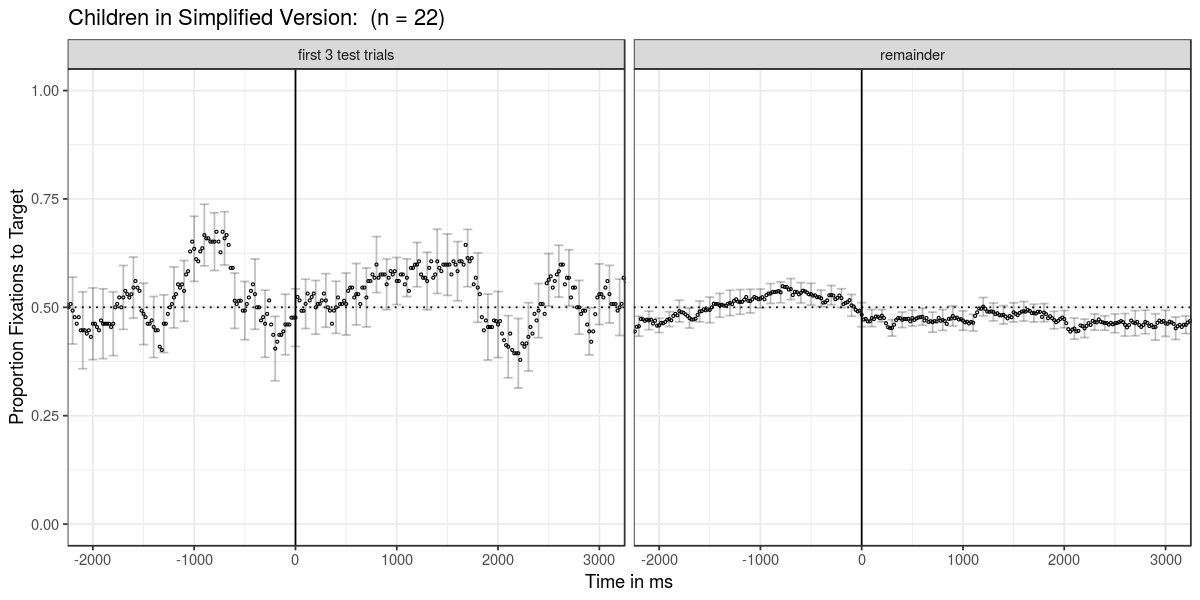

[1] "figures/type=='child'&expt_version=='redblue'_target_~novelty.pdf"


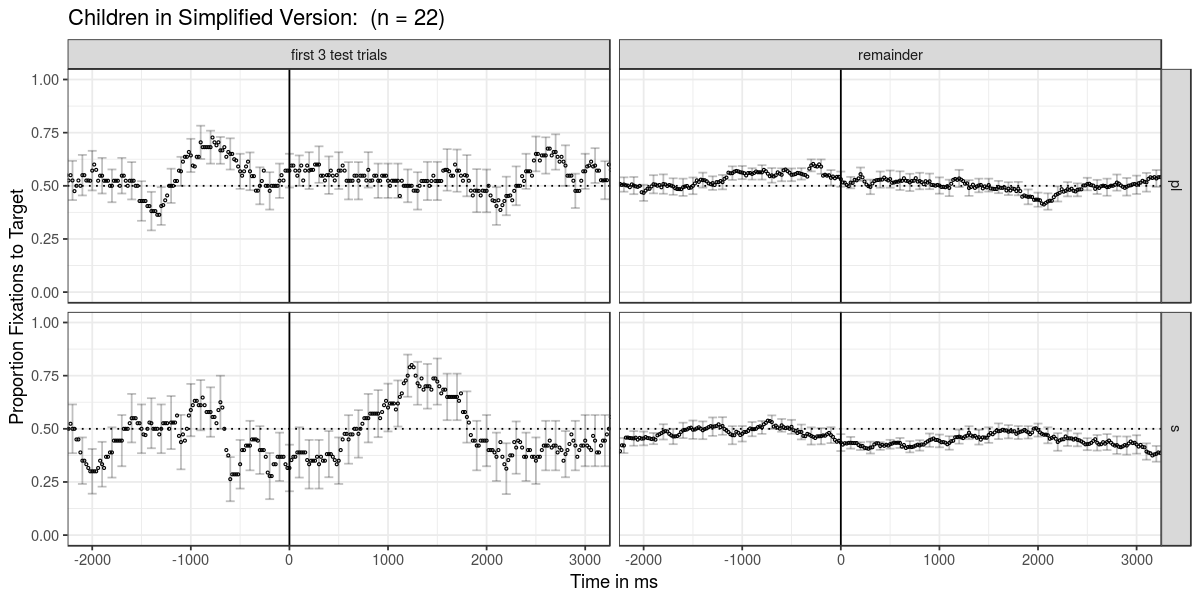

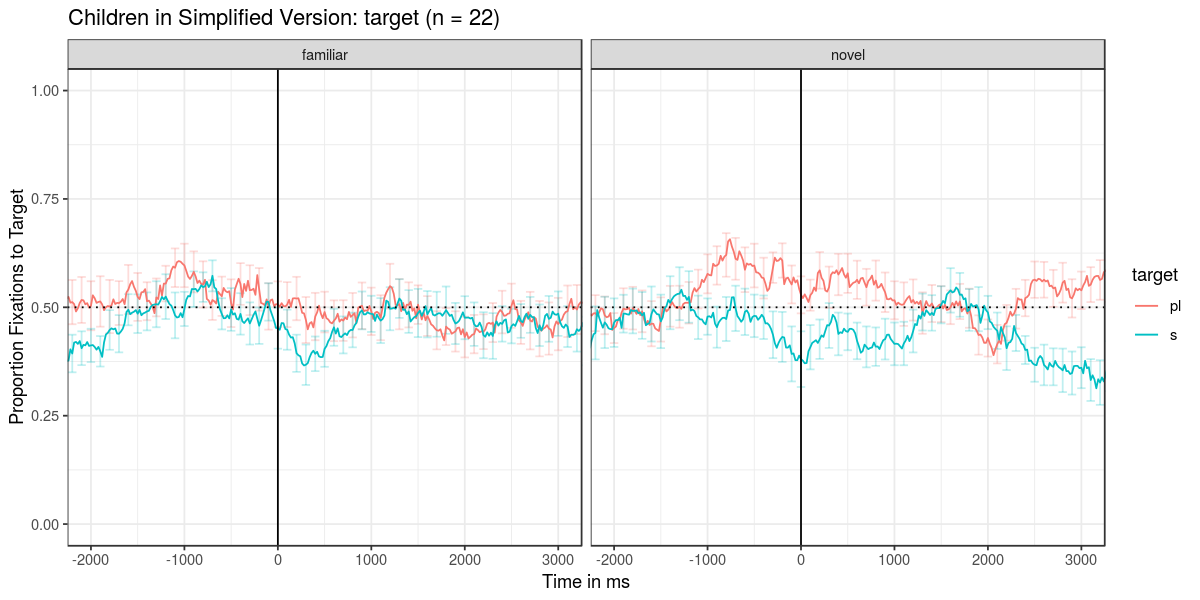

In [167]:
source('PLEARN_analysis_helper.R')
options(repr.plot.width=6, repr.plot.height=6)
getGroupPlots(ed_df, filter_clause = "type == 'child' & expt_version == 'redblue'",
    mean_pp_duration = NULL, group_title = 'Children in Simplified Version', save_plot=T)

[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target"


Warning message:
“Ignoring unknown parameters: shape”

[1] "figures/type=='child'&age_in_days>=915&expt_version=='redblue'_target_.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + novelty + target"


Warning message:
“Ignoring unknown parameters: shape”

[1] "figures/type=='child'&age_in_days>=915&expt_version=='redblue'_novelty_~target.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + voicing + target"


Warning message:
“Ignoring unknown parameters: shape”

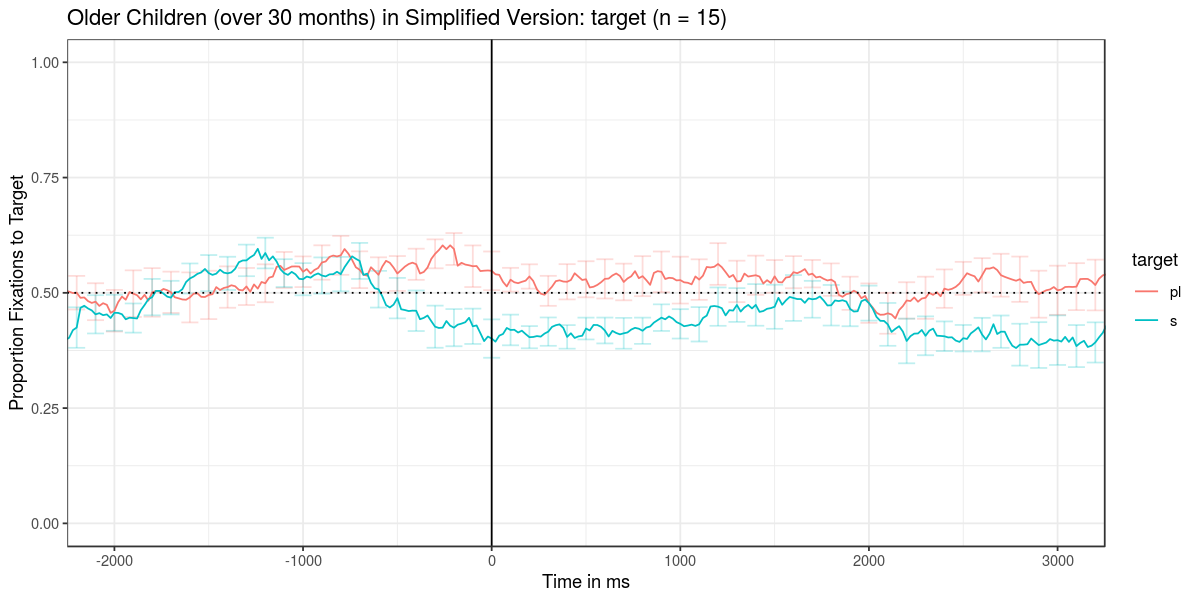

[1] "figures/type=='child'&age_in_days>=915&expt_version=='redblue'_voicing_~target.pdf"
[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + animacystatus + target"


Warning message:
“Ignoring unknown parameters: shape”

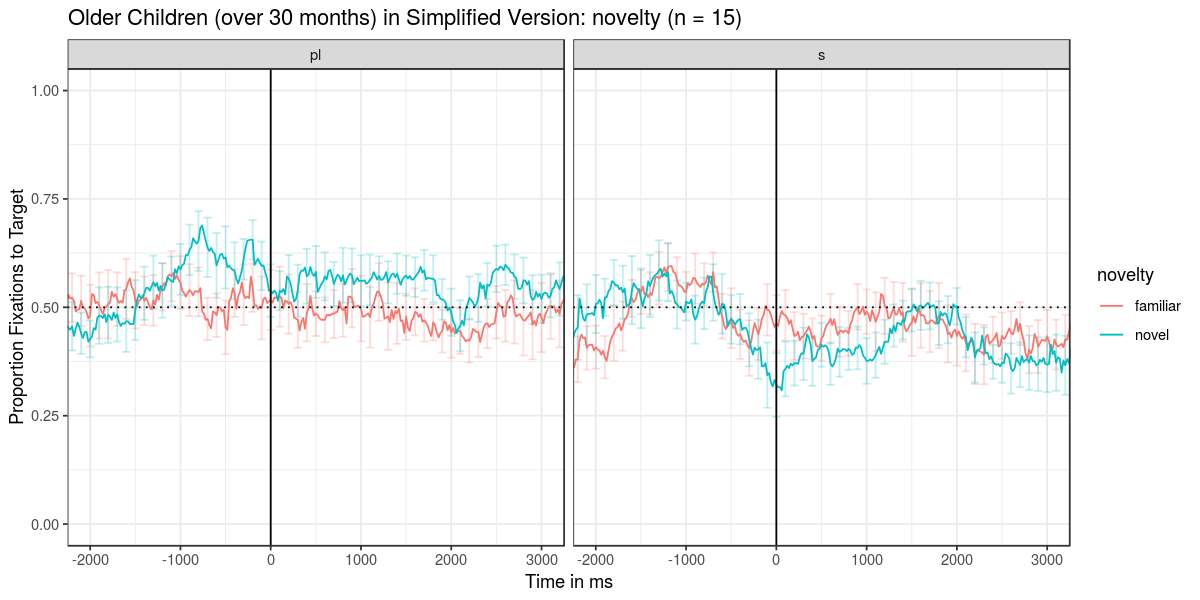

[1] "figures/type=='child'&age_in_days>=915&expt_version=='redblue'_animacystatus_~target.pdf"


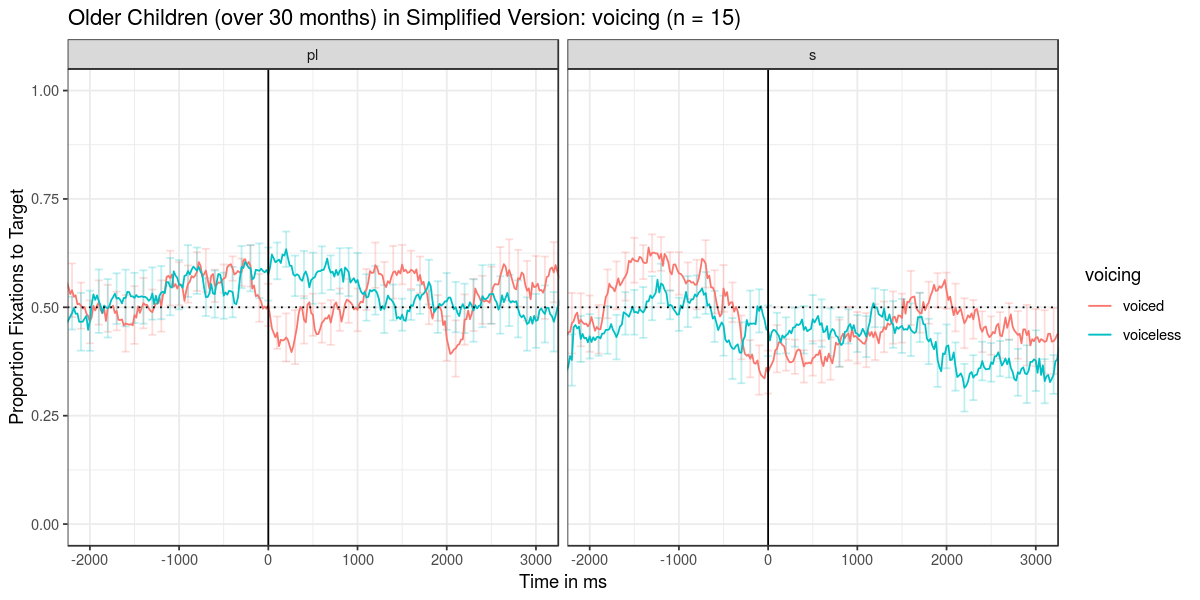

[1] "facet clause:"
[1] "~ label_at_onset"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + label_at_onset"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&age_in_days>=915&expt_version=='redblue'_nullgroup_~label_at_onset.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

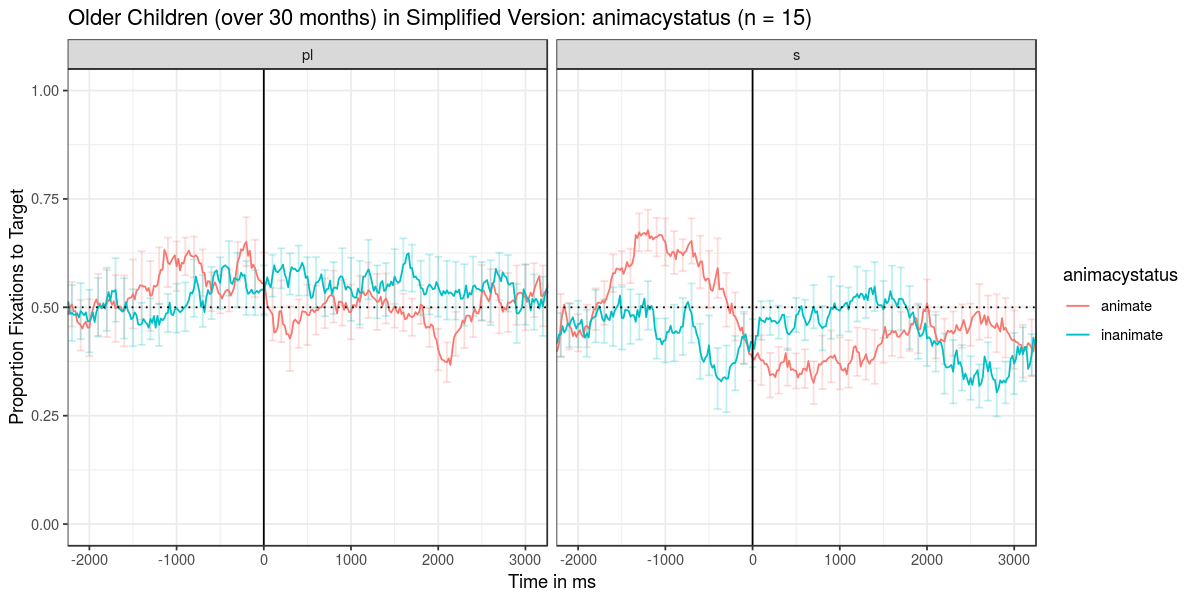

[1] "facet clause:"
[1] "~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + first3"
[1] "figures/type=='child'&age_in_days>=915&expt_version=='redblue'_nullgroup_~first3.pdf"


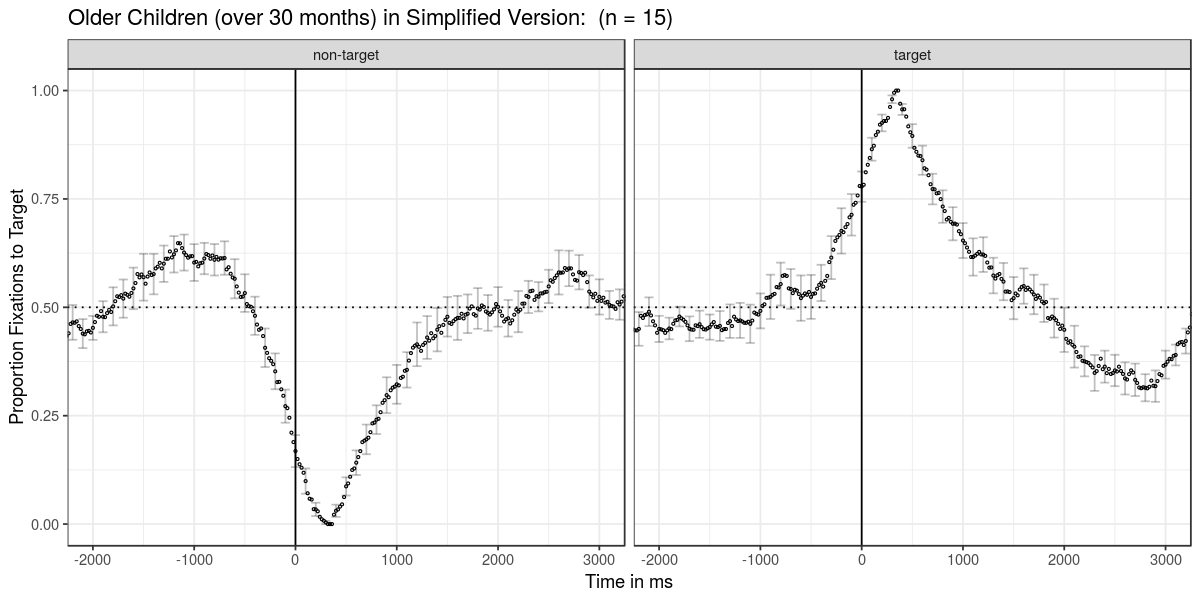

[1] "facet clause:"
[1] "target ~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target+first3"
[1] "figures/type=='child'&age_in_days>=915&expt_version=='redblue'_nullgroup_target~first3.pdf"
[1] "facet clause:"
[1] "~ novelty"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + novelty"


Warning message:
“Ignoring unknown parameters: shape”

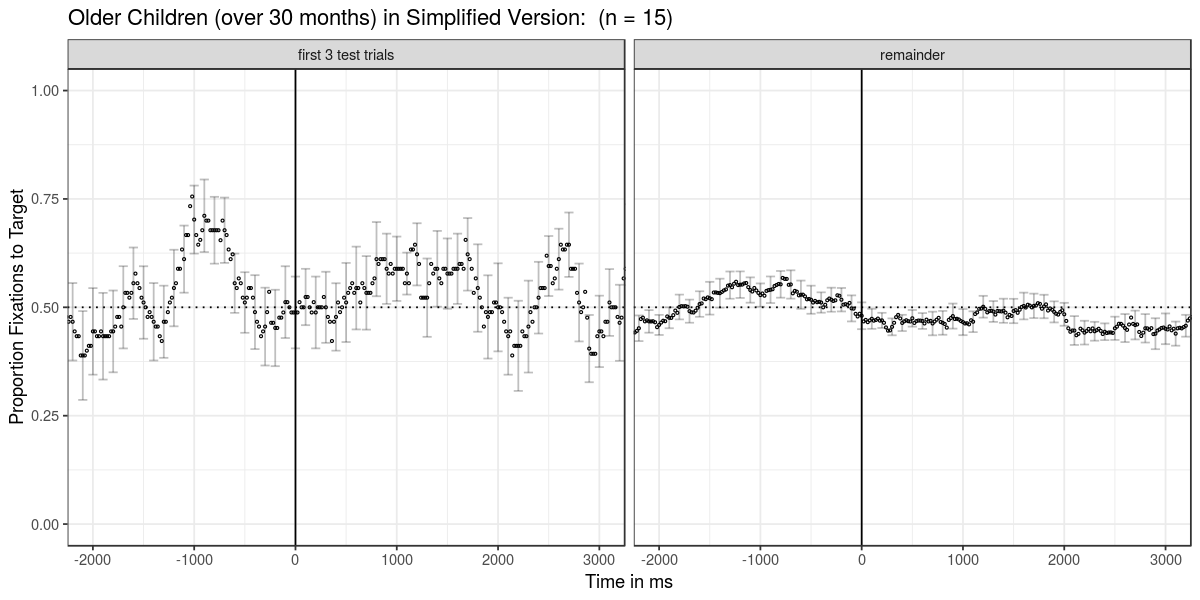

[1] "figures/type=='child'&age_in_days>=915&expt_version=='redblue'_target_~novelty.pdf"


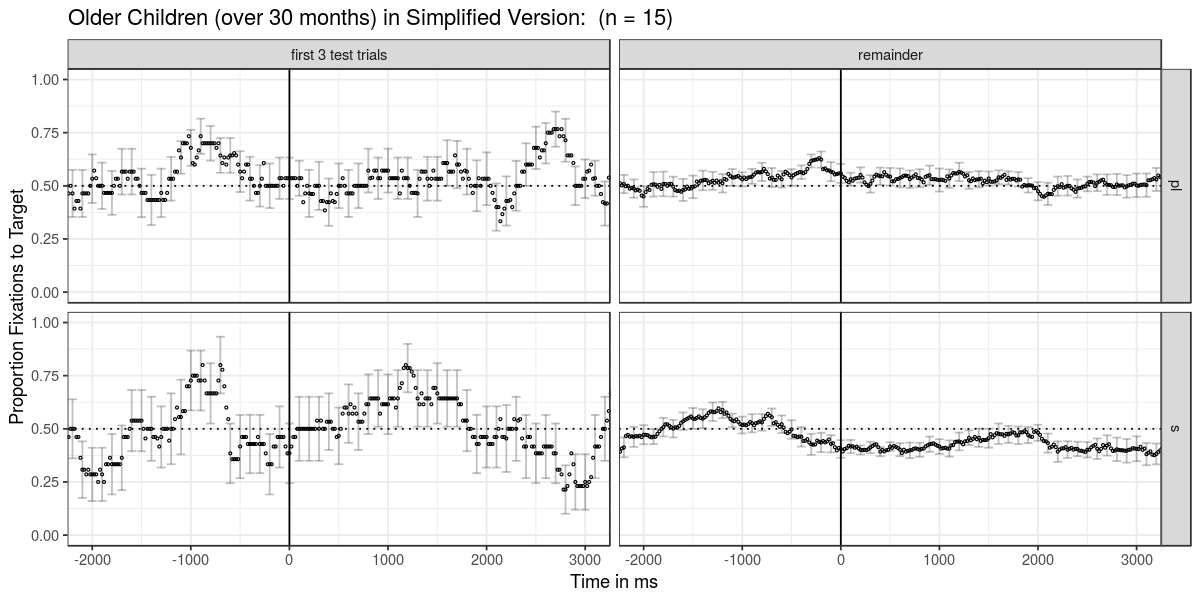

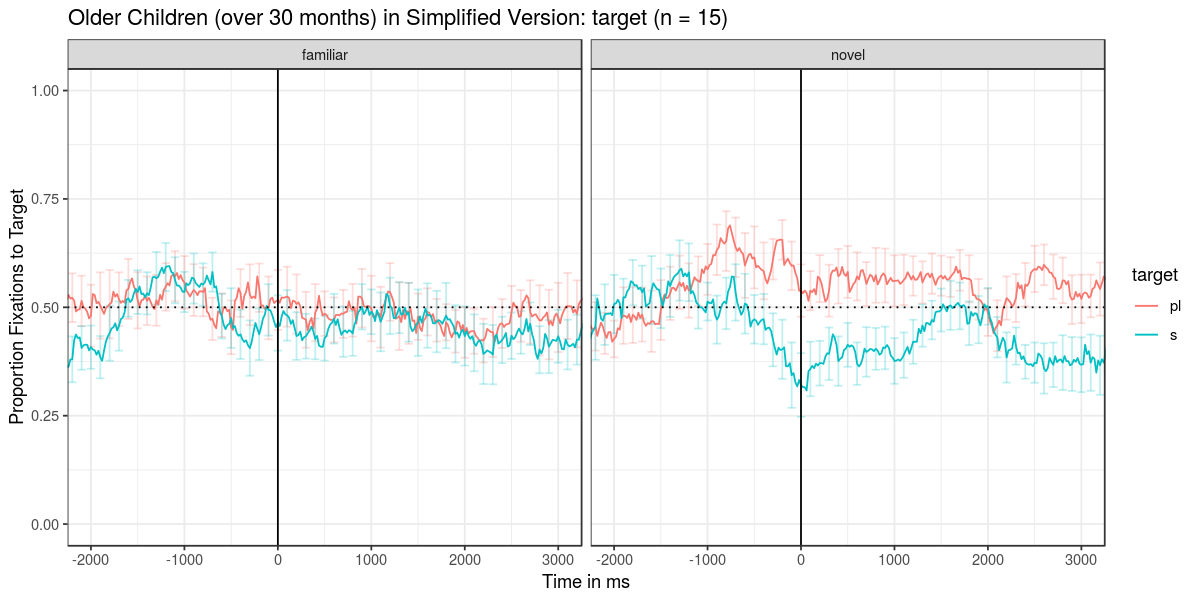

In [168]:
source('PLEARN_analysis_helper.R')
getGroupPlots(ed_df, filter_clause = "type == 'child' & age_in_days >= 915 & expt_version == 'redblue'",
    mean_pp_duration = NULL, 
              group_title = 'Older Children (over 30 months) in Simplified Version',
             save_plot=T)

[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='redblue'&\nbroad_score>.5_target_.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + novelty + target"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='redblue'&\nbroad_score>.5_novelty_~target.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + voicing + target"


Warning message:
“Ignoring unknown parameters: shape”

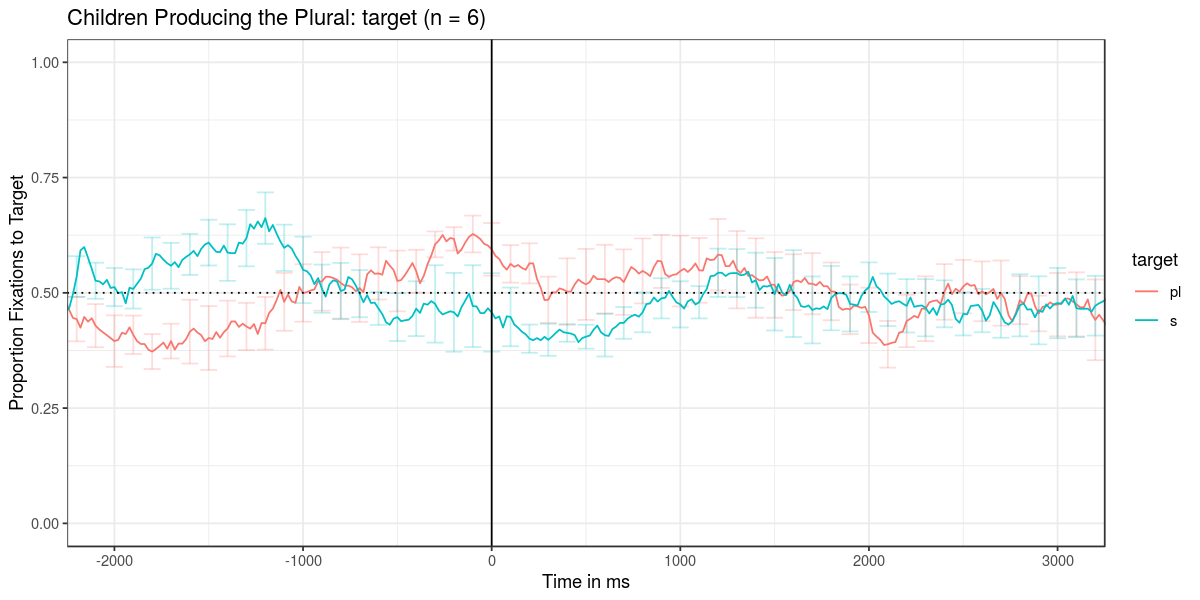

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='redblue'&\nbroad_score>.5_voicing_~target.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + animacystatus + target"


Warning message:
“Ignoring unknown parameters: shape”

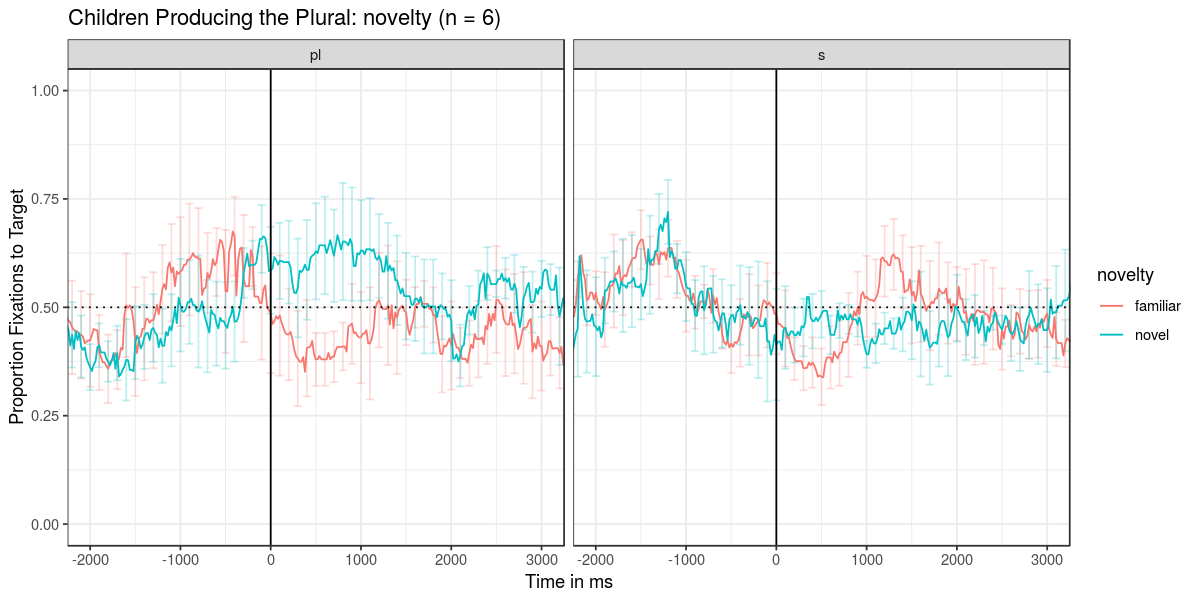

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='redblue'&\nbroad_score>.5_animacystatus_~target.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

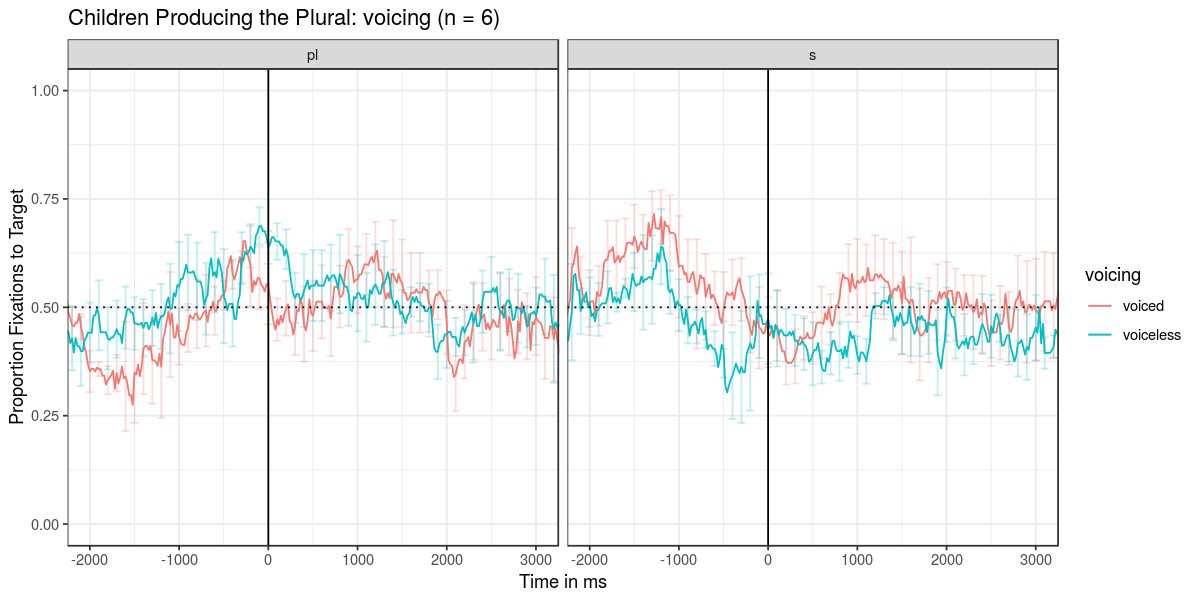

[1] "facet clause:"
[1] "~ label_at_onset"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + label_at_onset"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='redblue'&\nbroad_score>.5_nullgroup_~label_at_onset.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

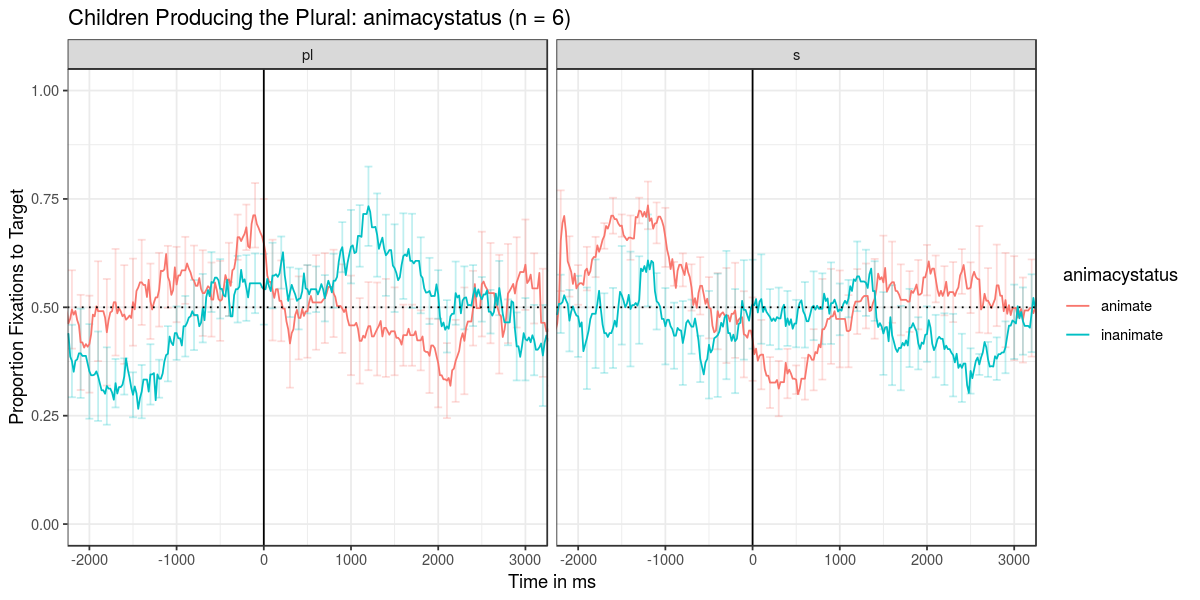

[1] "facet clause:"
[1] "~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + first3"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='redblue'&\nbroad_score>.5_nullgroup_~first3.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

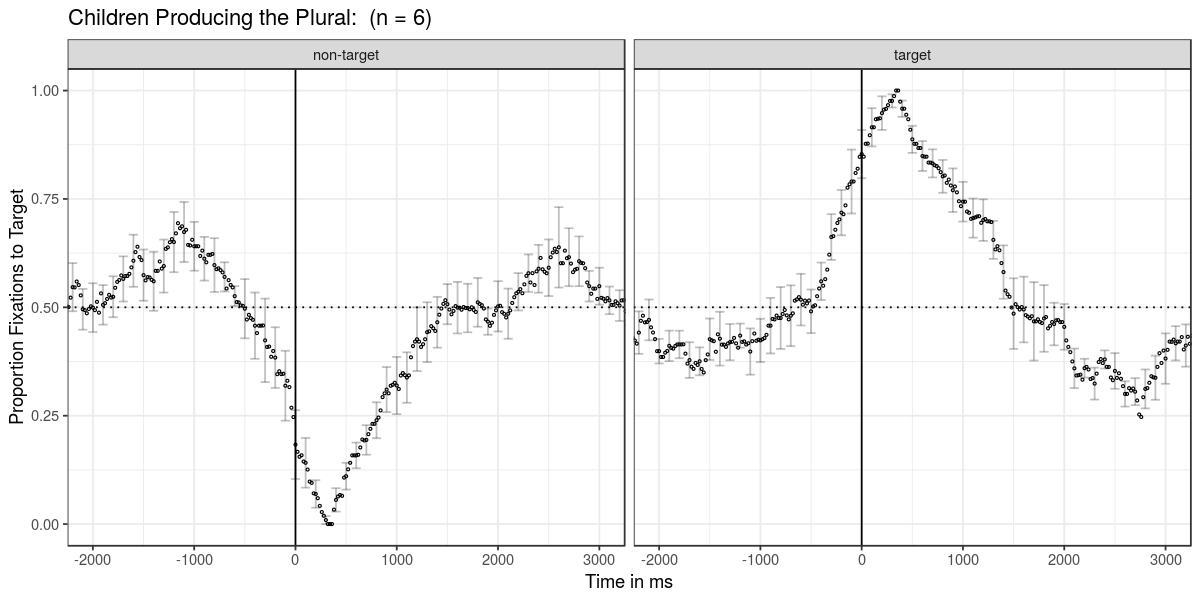

[1] "facet clause:"
[1] "target ~ first3"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target+first3"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='redblue'&\nbroad_score>.5_nullgroup_target~first3.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "facet clause:"
[1] "~ novelty"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + novelty"


Warning message:
“Ignoring unknown parameters: shape”

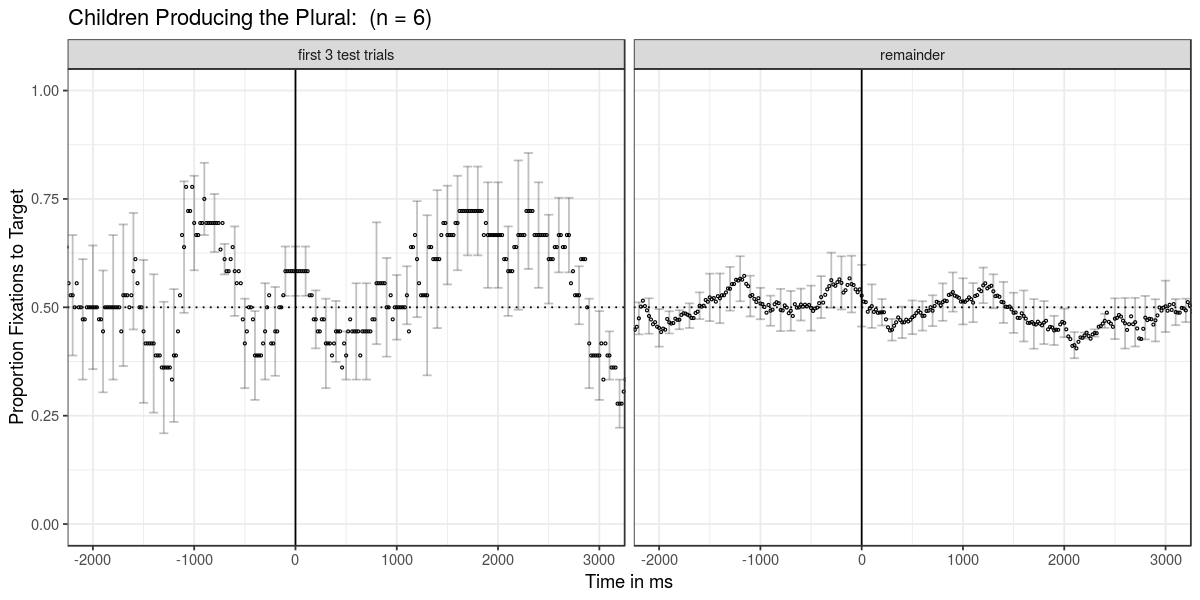

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'&expt_version=='redblue'&\nbroad_score>.5_target_~novelty.pdf"


Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

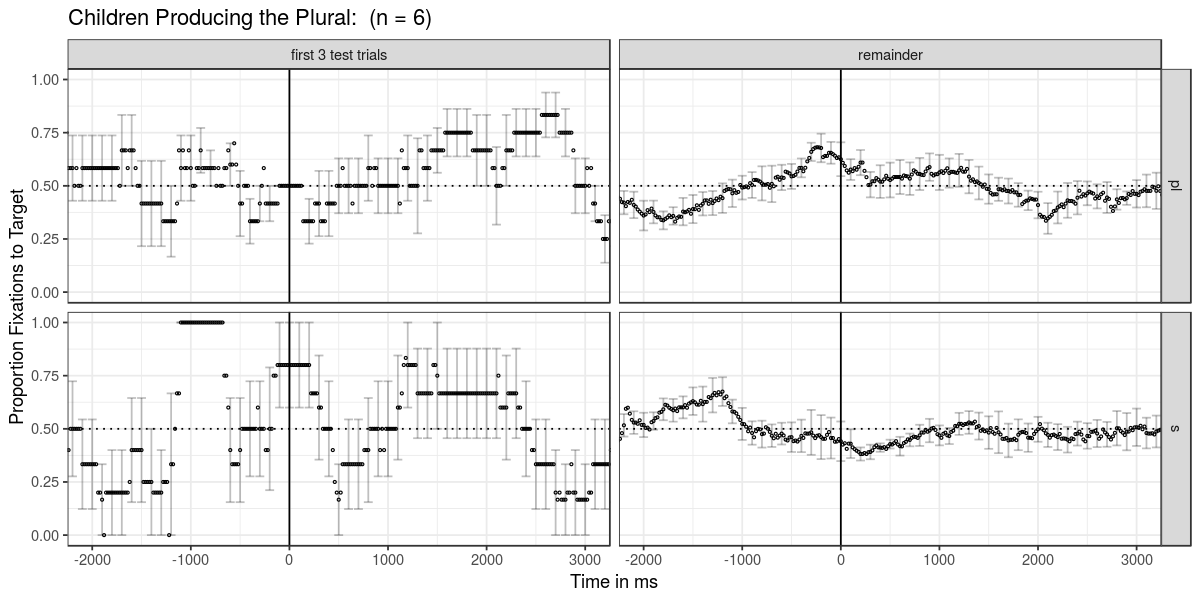

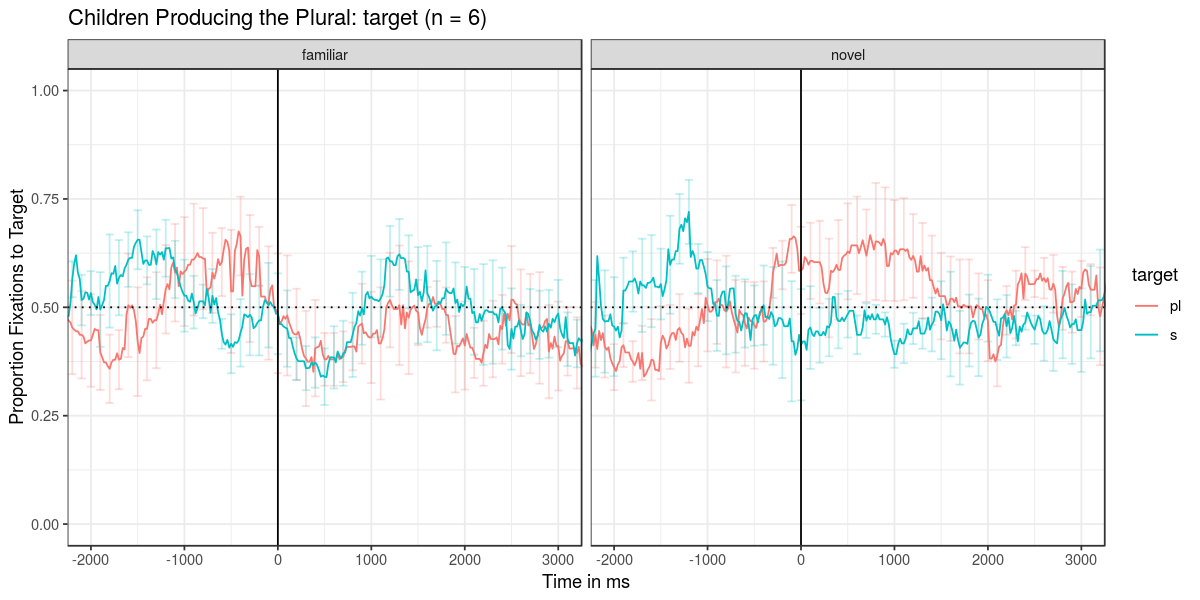

In [169]:
## source('PLEARN_analysis_helper.R')
options(repr.plot.width=6, repr.plot.height=6)
getGroupPlots(ed_df, filter_clause = "type == 'child' & expt_version == 'redblue' &
broad_score > .5",
    mean_pp_duration = NULL, group_title = 'Children Producing the Plural', save_plot=T)

# Comparison Between Experiments

[1] "facet clause:"
[1] "~ target"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + expt_version + target"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='adult'_expt_version_~target.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

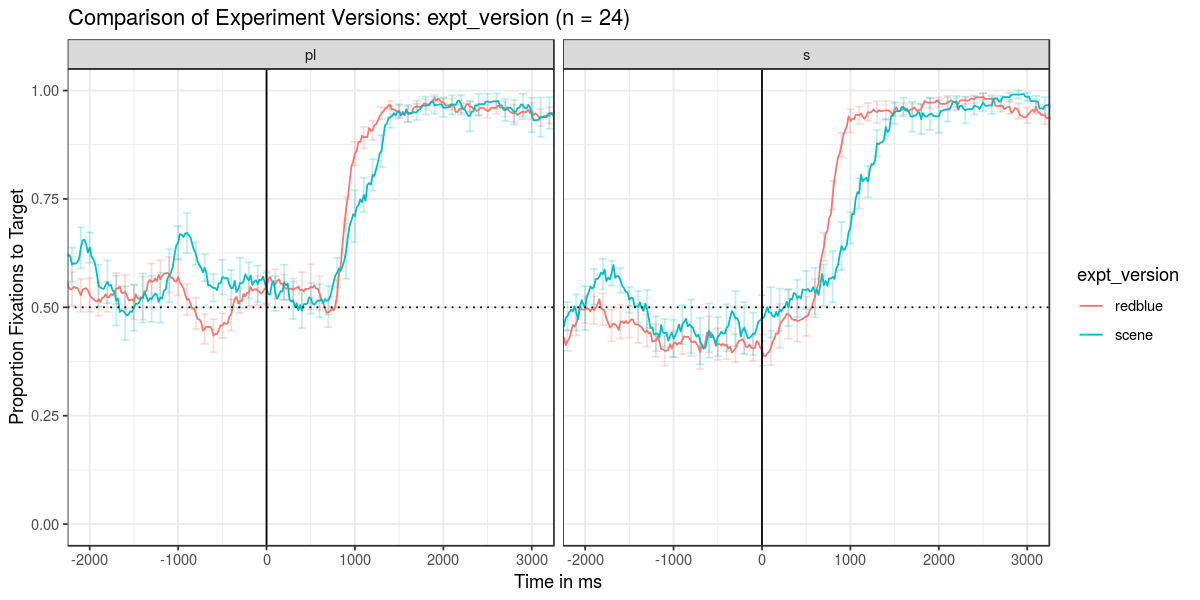

In [170]:
getGroupPlot(ed_df, 
        grouping_var = 'expt_version',
        filter_clause = "type == 'adult'",             
        facet_clause = '~ target',
        facet_type = 'wrap',
        loessSpan=.2, 
        x_start = -2000,
        x_end = 3000,
        mean_pp_duration= NULL,
        delay_ms= 367, 
        group_title = "Comparison of Experiment Versions",
        save_plot=T)

[1] "facet clause:"
[1] "~ expt_version"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + expt_version"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='adult'_target_~expt_version.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

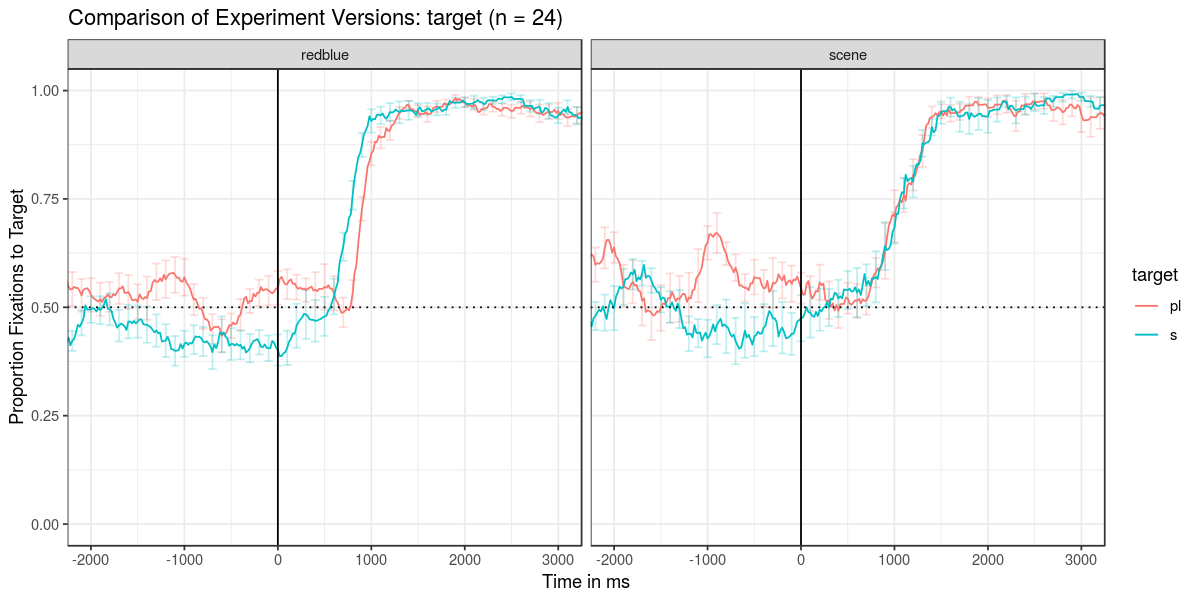

In [171]:
getGroupPlot(ed_df, 
        grouping_var = 'target',
        filter_clause = "type == 'adult'",             
        facet_clause = '~ expt_version',
        facet_type = 'wrap',
        loessSpan=.2, 
        x_start = -2000,
        x_end = 3000,
        mean_pp_duration= NULL,
        delay_ms= 367, 
        group_title = "Comparison of Experiment Versions",
        save_plot=T)

[1] "facet clause:"
[1] "~ expt_version"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + expt_version"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

[1] "figures/type=='child'_target_~expt_version.pdf"


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

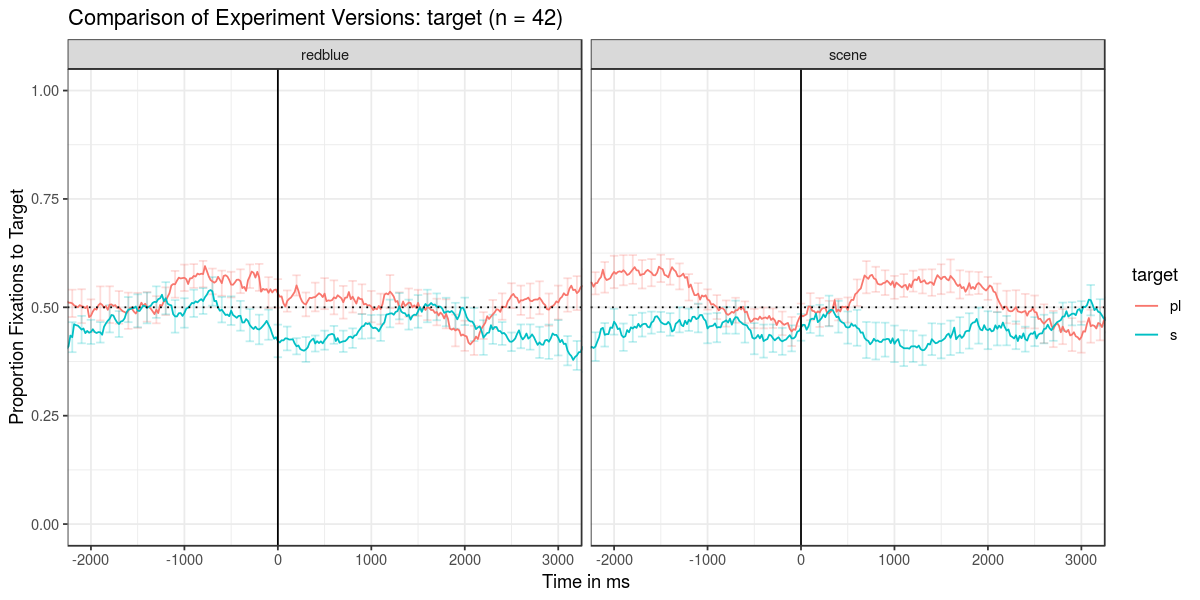

In [172]:
getGroupPlot(ed_df, 
        grouping_var = 'target',
        filter_clause = "type == 'child'",             
        facet_clause = '~ expt_version',
        facet_type = 'wrap',
        loessSpan=.2, 
        x_start = -2000,
        x_end = 3000,
        mean_pp_duration= NULL,
        delay_ms= 367, 
        group_title = "Comparison of Experiment Versions",
        save_plot=T)

In [173]:
ed_df$expt_version = factor(ed_df$expt_version, c('scene','redblue'))

[1] "facet clause:"
[1] "~ expt_version"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + type + expt_version"


Warning message:
“Ignoring unknown parameters: shape”Warning message:
“Removed 35 rows containing missing values (geom_errorbar).”

[1] "figures/_target_~expt_version.pdf"


Warning message:
“Removed 35 rows containing missing values (geom_errorbar).”

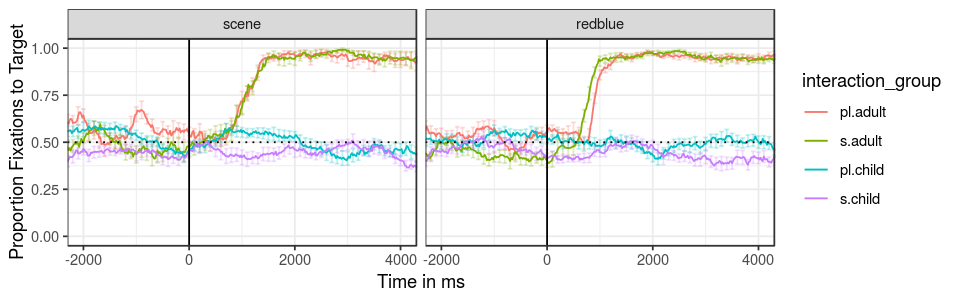

In [174]:
source('PLEARN_analysis_helper.R')
getGroupPlot(ed_df, 
        grouping_var = 'target',
        linetype_var = 'type',
        facet_clause = '~ expt_version',
        facet_type = 'wrap',
        loessSpan=.2, 
        x_start = -2000,
        x_end = 4000,
        mean_pp_duration= NULL,
        delay_ms= 367, 
        group_title = NULL,
        save_plot=T,
        plot_size = c(8,2.5))

In [175]:
length(unique(subset(ed_df, type == 'child' & expt_version == 'redblue')$participant_name))
length(unique(subset(ed_df, type == 'child' & expt_version == 'scene')$participant_name))

[1] 22

[1] 20

# Trial Level Data

In [176]:
source('PLEARN_analysis_helper.R')
ed_df_include = subset(ed_df, !exclude_trial) #exclude trials here
by_participant = split(ed_df_include, ed_df_include$filename)
trial_scores = do.call('rbind.fill', lapply(by_participant, function(fixbin_df){
        test_participant_receptive_knowledge(fixbin_df, 
            normalizeMethod="preceding", end_analysis_window= 4000, return_type = 'ltt')
}))    
#[ ] trial level results are yielded BEFORE yoking; should stop on that param combination
trial_scores$expt_index = as.numeric(trial_scores$expt_index)

In [177]:
trial_scores[1,]

expt_index novelty  voicing   animacystatus dummy s_form participant_type
1 10         familiar voiceless inanimate     1     plate  adult           
  target expt_version participant_name is_looking_at_target_after
1 s      redblue      adultpl01        0.8603352                 
  is_looking_at_distractor is_looking_at_target_before is_looking_at_target
1 0.1396648                0.4255319                   0.4348033           
  thresholded
1 FALSE

In [178]:
binarize = function(x, levels=NULL){ 
    if (is.null(levels)){
        x = factor(x)
    } else {
        x = factor(x, levels=levels)
    }
    bins = levels(as.factor(x))
    print(bins)
    rv = -1
    rv[x == bins[1]] = -1
    rv[x == bins[2]] = 1
    return(rv)
}

In [179]:
study1_lm_data = subset(trial_scores, participant_type == "child" & expt_version=='scene')
study1_lm_data$novelty = binarize(study1_lm_data$novelty,c('familiar','novel'))
study1_lm_data$voicing = binarize(study1_lm_data$voicing,c('voiceless','voiced'))
study1_lm_data$animacystatus = binarize(study1_lm_data$animacystatus, c('inanimate',
    'animate'))
study1_lm_data$target = binarize(study1_lm_data$target, c('s','pl'))
# https://stats.stackexchange.com/questions/242109/model-failed-to-converge-warning-in-lmer
# per-subject random slopes for novelty etc: each child has a different proposensity for
# the two classes, which is drawn for a Gaussian

[1] "familiar" "novel"   
[1] "voiceless" "voiced"   
[1] "inanimate" "animate"  
[1] "s"  "pl"


In [180]:
head(study1_lm_data)

expt_index novelty voicing animacystatus dummy s_form participant_type
631 10         -1      -1      -1            1     plate  child           
632 11         -1      -1       1            1     ant    child           
633 12          1       1       1            1     kib    child           
634 13          1      -1      -1            1     nop    child           
635 14         -1       1       1            1     frog   child           
636 15          1       1      -1            1     pib    child           
    target expt_version participant_name is_looking_at_target_after
631 -1     scene        pl00             0.2413793                 
632  1     scene        pl00             0.0000000                 
633  1     scene        pl00             0.4078212                 
634 -1     scene        pl00             0.5872093                 
635 -1     scene        pl00             1.0000000                 
636  1     scene        pl00             0.9550562                 
    is_looking_at_distractor is_looking_at_target_before is_looking_at_target
631 0.75862069               0.5317919                   -0.29041260         
632 1.00000000               0.5822785                   -0.58227848         
633 0.59217877               0.5796178                   -0.17179661         
634 0.41279070               0.9371069                   -0.34989762         
635 0.00000000               0.1180124                    0.88198758         
636 0.04494382               0.8944099                    0.06064624         
    thresholded
631 FALSE      
632 FALSE      
633 FALSE      
634 FALSE      
635  TRUE      
636 FALSE

In [181]:
study1_lm = glmer(is_looking_at_target ~ novelty * voicing + animacystatus 
                  + target + expt_index +
    ( novelty * voicing + animacystatus + target || participant_name)
   + (target || s_form),
    data= study1_lm_data,
    REML = FALSE)

summary(study1_lm)

Warning message in glmer(is_looking_at_target ~ novelty * voicing + animacystatus + :
“calling glmer() with family=gaussian (identity link) as a shortcut to lmer() is deprecated; please call lmer() directly”Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: is_looking_at_target ~ novelty * voicing + animacystatus + target +  
    expt_index + ((1 | participant_name) + (0 + novelty | participant_name) +  
    (0 + voicing | participant_name) + (0 + animacystatus | participant_name) +  
    (0 + target | participant_name) + (0 + novelty:voicing |  
    participant_name)) + ((1 | s_form) + (0 + target | s_form))
   Data: study1_lm_data

     AIC      BIC   logLik deviance df.resid 
   453.9    522.6   -210.9    421.9      525 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.68042 -0.66155 -0.00853  0.69925  2.80605 

Random effects:
 Groups             Name            Variance  Std.Dev.
 s_form             target          0.0000000 0.00000 
 s_form.1           (Intercept)     0.0000000 0.00000 
 participant_name   novelty:voicing 0.0000000 0.00000 
 participant_name.1 target          0.0051478 0.07175 
 participant_name.2 animacystatus   0.0006358 0.02522

In [182]:
study2_lm_data = subset(trial_scores, participant_type == "child" & expt_version=='redblue')
study2_lm_data$novelty = binarize(study2_lm_data$novelty,c('familiar','novel'))
study2_lm_data$voicing = binarize(study2_lm_data$voicing,c('voiceless','voiced'))
study2_lm_data$animacystatus = binarize(study2_lm_data$animacystatus, c('inanimate',
    'animate'))
study2_lm_data$target = binarize(study2_lm_data$target,c('s','pl'))

study2_lm = glmer(is_looking_at_target ~ novelty * voicing + animacystatus 
                  + target + expt_index +
    ( novelty * voicing + animacystatus + target || participant_name)
   + (target || s_form),
    data= study2_lm_data,
    REML = FALSE)

summary(study2_lm)

[1] "familiar" "novel"   
[1] "voiceless" "voiced"   
[1] "inanimate" "animate"  
[1] "s"  "pl"


Warning message in glmer(is_looking_at_target ~ novelty * voicing + animacystatus + :
“calling glmer() with family=gaussian (identity link) as a shortcut to lmer() is deprecated; please call lmer() directly”

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: is_looking_at_target ~ novelty * voicing + animacystatus + target +  
    expt_index + ((1 | participant_name) + (0 + novelty | participant_name) +  
    (0 + voicing | participant_name) + (0 + animacystatus | participant_name) +  
    (0 + target | participant_name) + (0 + novelty:voicing |  
    participant_name)) + ((1 | s_form) + (0 + target | s_form))
   Data: study2_lm_data

     AIC      BIC   logLik deviance df.resid 
   324.2    394.2   -146.1    292.2      568 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.81628 -0.60641  0.02233  0.60413  2.88803 

Random effects:
 Groups             Name            Variance  Std.Dev.
 s_form             target          0.0000000 0.00000 
 s_form.1           (Intercept)     0.0000000 0.00000 
 participant_name   novelty:voicing 0.0008302 0.02881 
 participant_name.1 target          0.0005010 0.02238 
 participant_name.2 animacystatus   0.0015370 0.03921

In [184]:
recoverIntercept = function(lm){
    df = tidy(lm) 
    intercept = df[1,]
    intercept$term = 'Intercept'
    df = rbind(df, intercept)
    return(df)
}
study1_lm_aug = recoverIntercept(study1_lm) %>% mutate(model = "Study 1")
study2_lm_aug = recoverIntercept(study2_lm) %>% mutate(model = "Study 2")

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

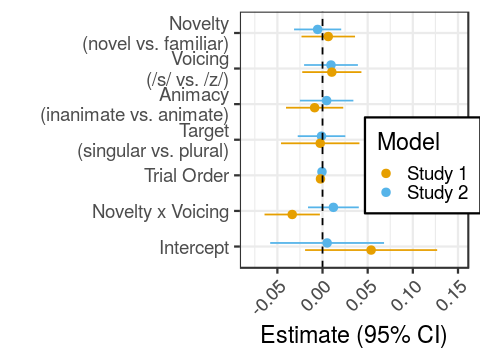

In [188]:
options(repr.plot.width=4, repr.plot.height=3)
regression_df = subset(rbind(study1_lm_aug, study2_lm_aug), group =="fixed")
regression_df$panel = sapply(regression_df$term, function(x){
    if (x == 'Intercept'){
        'intercept'
    } else {
        'betas'
    }
})

scales_x <- list(
  `betas` = scale_x_continuous(limits = c(-.1, .1), breaks = seq(-1, .1, .05)),
  `intercept` = scale_x_continuous(limits = c(.4, .6), breaks = seq(.4, .6, .05))
)

p1 = dwplot(regression_df, conf.level = .95, dot_args = list(size=2))  + geom_vline(
    xintercept=0, lty=2) 

p1 = p1 %>% relabel_predictors(c(
    novelty = "Novelty\n(novel vs. familiar)",
    voicing = "Voicing\n(/s/ vs. /z/)",
    animacystatus = "Animacy\n(inanimate vs. animate)",
    target = "Target\n(singular vs. plural)",
    expt_index = "Trial Order",
    `novelty:voicing` = "Novelty x Voicing"
))
print(p1 + theme_bw(base_size=14) + theme(
    legend.key.size = unit(.4, "cm"),
    legend.position = c(.8,.4), 
    legend.background = element_rect(fill="white", linetype="solid", 
                                  colour ="black"),
    axis.text.x = element_text(angle = 45, hjust = 1)
    )  + geom_vline(xintercept=0, lty=2
)  +
      labs(color = "") + scale_color_manual(values=c("#E69F00", "#56B4E9")
) + labs(
     color = "Model"
) + coord_cartesian(xlim=c(-.08, .15)) + xlab('Estimate (95% CI)'))
#  + facet_grid_sc(cols = vars(panel), scales=list(x= scales_x)))+ geom_vline(xintercept=.5, lty=2, color='red')
      

ggsave('figures/eyetracking_lmem.pdf', width=5,height=3.2) 

In [ ]:
# https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/#DEVIATION
# sum contrasts: deviations from th egran mean
# has an effect like contrasting
# http://people.linguistics.mcgill.ca/~morgan/book/practical-regression-topics-1-multi-level-factors-contrast-coding-interactions.html
#for adults:
#novel singular  .3 + 1*-.01 + 1*-.05
#familiar plural  .3 + -1*-.01 + -1*-.05
#b12 * x_1 * x_2, seems weird 

# Participant Receptive Scores

In [269]:
source('PLEARN_analysis_helper.R')
normalizeMethods = c('none','yoked','preceding')
all_scores = do.call('rbind.fill', lapply(normalizeMethods, function(normalizeMethod){
    do.call('rbind.fill', lapply(by_participant, function(fixbin_df){
        test_participant_receptive_knowledge(fixbin_df, normalizeMethod, end_analysis_window= 4000)
    }))    
}))

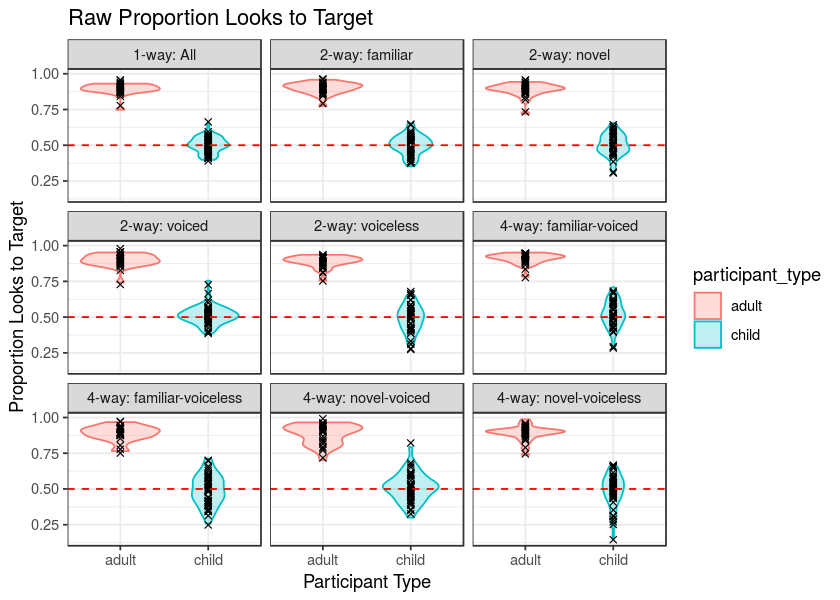

In [267]:
options(repr.plot.width=7, repr.plot.height=5)
ggplot(subset(all_scores, normalizeMethod == 'none')) + geom_violin(
aes(y=prop_looks_to_target, x = participant_type,
colour = participant_type, fill = participant_type), alpha=.25) +
geom_point(aes(x=participant_type, y=prop_looks_to_target), colour ='black',
shape = 4, position=position_jitter(height=.03, width=0)) + facet_wrap(
~partition_name) + theme_bw() + geom_hline(yintercept=.5, 
linetype = 'dashed', colour='red') + ggtitle('Raw Proportion Looks to Target'
) + xlab('Participant Type') + ylab('Proportion Looks to Target') 

The reason to do it this way is to check if a particuar subset of items is above chance, e.g. familiar voicless

In [191]:
# adults first
adult_scores = subset(all_scores, normalizeMethod == 'preceding' & participant_type=='adult' & 
       contrast_type=='1-way')$prop_looks_to_target
shapiro.test(adult_scores)
# Adults are not normal per shapiuro test; not enough to rely on law of large numbers
# so using a non-parametric test
wilcox.test(adult_scores, mu = 0, alternative = "two.sided")


	Shapiro-Wilk normality test

data:  adult_scores
W = 0.94523, p-value = 0.2131



	Wilcoxon signed rank test

data:  adult_scores
V = 300, p-value = 1.192e-07
alternative hypothesis: true location is not equal to 0


In [192]:
# Wilcoxon rank sum test of the difference between the two experiments
#!!! this includes kids outside the age rnage
preceding_scores = subset(all_scores, normalizeMethod == 'preceding' & participant_type=='child' & 
       contrast_type=='1-way')
wt = wilcox.test(subset(preceding_scores, expt_version == 'scene')$prop_looks_to_target,
            subset(preceding_scores, expt_version == 'redblue')$prop_looks_to_target)
# t.test(subset(yoked_scores, expt_version == 'scene')$prop_looks_to_target,
#            subset(yoked_scores, expt_version == 'redblue')$prop_looks_to_target)
tvc = update_texvar_cache(tvc, paste0('combineEyetrackingWilcoxonStatistic'),wt$statistic)
tvc = update_texvar_cache(tvc, paste0('combineEyetrackingWilcoxonPvalue'), wt$p.value)
writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

In [193]:
tvc$combineEyetrackingWilcoxonPvalue

[1] 0.87

This test suggests that we can combine across the two receptive experiments

In [194]:
getEyetrackingStudyStats = function(yoked_scores, expt_vers, tvc){
    # these are subject means? 
    df = subset(yoked_scores, expt_version == expt_vers)
    #update_texvar_cache(cache, var, value)
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresGt0'), sum(df$prop_looks_to_target > 0))
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresN'),nrow(df))
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresMean'),
                              mean(df$prop_looks_to_target), digits=3)
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresSD'),
                              sd(df$prop_looks_to_target))
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresMin'),
                              min(df$prop_looks_to_target))
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresMax'),
                              max(df$prop_looks_to_target))
    t_test = t.test(df$prop_looks_to_target, mu=0)
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresTStatisistic'),
                             t_test$statistic)
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresTdf'),
                             t_test$parameter)
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresPvalue'),
                             t_test$p.value)
    return(tvc)
}

In [195]:
tvc = getEyetrackingStudyStats(preceding_scores, 'scene',tvc)
tvc = getEyetrackingStudyStats(preceding_scores, 'redblue',tvc)
writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

In [196]:
tvc

$totalN
[1] 52

$sceneN
[1] 24

$redblueN
[1] 28

$redblueNExclusions
[1] 6

$sceneNExclusions
[1] 4

$redBlueAdultN
[1] 15

$sceneAdultN
[1] 9

$nStorybookExclusions
[1] 4

$percentFem
[1] 55.77

$meanAge
[1] 30.22

$sdAge
[1] 3.99

$numFem
[1] 29

$numStorybookTrialsExcluded
[1] 12

$numChildrenWithTrialsExcludedFromStorybook
[1] 8

$productionWilcoxonStat
[1] 234.5

$productionWilcoxonP
[1] 0.4

$nChildrenWithExcludedTrials
[1] 36

$nTrialsExcludedByFilter
[1] 170

$percentExcludedEyetrackingTrials
[1] 13

$nEyetrackingSubjExcludedByDataFilter
[1] 0

$combineEyetrackingWilcoxonStatistic
  W 
227 

$combineEyetrackingWilcoxonPvalue
[1] 0.87

$sceneDiffScoresGt0
[1] 10

$sceneDiffScoresN
[1] 20

$sceneDiffScoresMean
[1] 0.004

$sceneDiffScoresSD
[1] 0.06

$sceneDiffScoresMin
[1] -0.14

$sceneDiffScoresMax
[1] 0.08

$sceneDiffScoresTStatisistic
   t 
0.31 

$sceneDiffScoresTdf
df 
19 

$sceneDiffScoresPvalue
[1] 0.76

$redblueDiffScoresGt0
[1] 12

$redblueDiffScoresN
[1] 22

$redblueDiffScoresMean
[1] -0.005

$redblueDiffScoresSD
[1] 0.08

$redblueDiffScoresMin
[1] -0.18

$redblueDiffScoresMax
[1] 0.15

$redblueDiffScoresTStatisistic
    t 
-0.28 

$redblueDiffScoresTdf
df 
21 

$redblueDiffScoresPvalue
[1] 0.78

In [197]:
# Get pair-level data
source('PLEARN_analysis_helper.R')
ltts = do.call('rbind', lapply(by_participant, function(fixbin_df){
        test_participant_receptive_knowledge(fixbin_df, 'yoked',
                    end_analysis_window= 4000, return_type="ltt")
}))    

In [198]:
names(ltts)

[1] "expt_index"                         "novelty"                           
 [3] "voicing"                            "animacystatus"                     
 [5] "dummy"                              "s_form"                            
 [7] "participant_type"                   "participant_name"                  
 [9] "expt_version"                       "is_looking_at_target"              
[11] "is_looking_at_distractor"           "prop_looks_to_item_when_distractor"
[13] "corrected_looks_to_target"

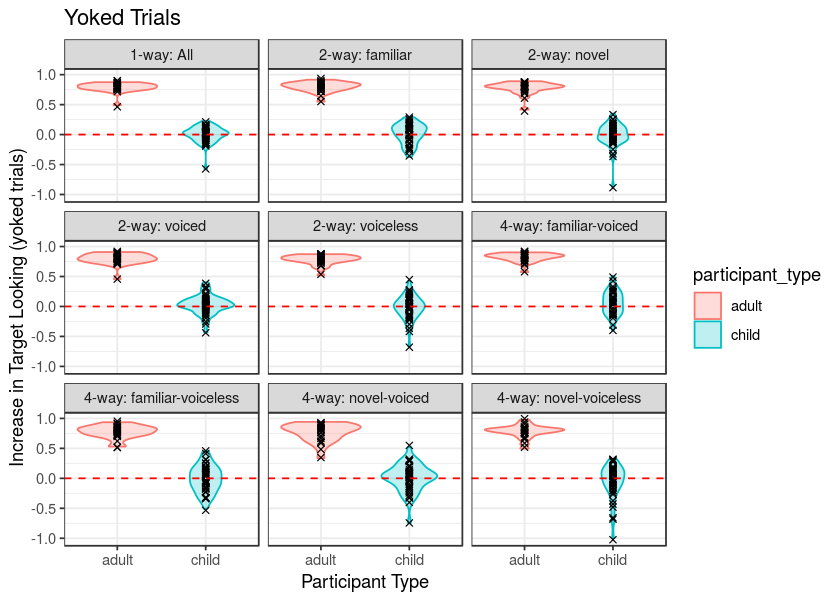

In [199]:
options(repr.plot.width=7, repr.plot.height=5)
ggplot(subset(all_scores, normalizeMethod == 'yoked')) + geom_violin(
aes(y=prop_looks_to_target, x = participant_type,
colour = participant_type, fill = participant_type), alpha=.25) +
geom_point(aes(x=participant_type, y=prop_looks_to_target), colour ='black',
shape = 4, position=position_jitter(height=.03, width=0)) + facet_wrap(
~partition_name) + theme_bw() + geom_hline(yintercept=0, 
linetype = 'dashed', colour='red') + ggtitle('Yoked Trials'
) + xlab('Participant Type') + ylab('Increase in Target Looking (yoked trials)') 

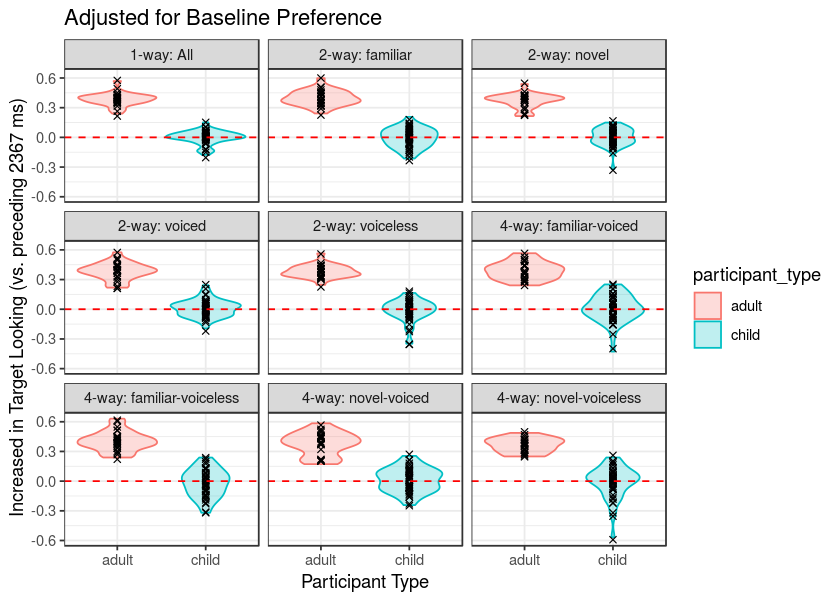

In [200]:
options(repr.plot.width=7, repr.plot.height=5)
ggplot(subset(all_scores, normalizeMethod == 'preceding')) + geom_violin(
aes(y=prop_looks_to_target, x = participant_type,
colour = participant_type, fill = participant_type), alpha=.25) +
geom_point(aes(x=participant_type, y=prop_looks_to_target), position=position_jitter(
height=.03, width=0), colour ='black', shape = 4) + facet_wrap(
~partition_name) + theme_bw() + geom_hline(yintercept=0, 
linetype = 'dashed', colour='red') + ggtitle('Adjusted for Baseline Preference'
) + xlab('Participant Type') + ylab('Increased in Target Looking (vs. preceding 2367 ms)') 

# Expressive Scores vs. Receptive Scores

In [201]:
child_receptive_scores = subset(all_scores, normalizeMethod == 'yoked' & 
                                contrast_type == '1-way')
exre = subset(merge(subject_info[,c('participant_name','age_in_months','broad_score','narrow_score')], subset(child_receptive_scores, participant_type =='child')
    , by='participant_name'), age_in_months > 20 &age_in_months <40)
head(exre)
wilcox.test(exre$prop_looks_to_target ~ exre$expt_version)

participant_name age_in_months broad_score narrow_score participant_type
1 pl00             25.21311             NA          NA    child           
2 pl01             25.83607      0.1666667   1.0000000    child           
3 pl03             26.55738      0.1000000   1.0000000    child           
4 pl09             26.09836      0.0000000         NaN    child           
5 pl10             29.40984      0.1333333   0.1333333    child           
6 pl11             25.96721             NA          NA    child           
  contrast_type prob      prop_looks_to_target
1 1-way         0.9937295  0.03698783         
2 1-way         1.0000000 -0.17748875         
3 1-way         0.9892578  0.14743932         
4 1-way         0.9995439  0.01942082         
5 1-way         1.0000000 -0.08482689         
6 1-way         0.9999275  0.02099046         
  thresholded                        partition_name normalizeMethod
1 Does not demonstrate RK! (p > .33) 1-way: All     yoked          
2 Does not demonstrate RK! (p > .33) 1-way: All     yoked          
3 Does not demonstrate RK! (p > .33) 1-way: All     yoked          
4 Does not demonstrate RK! (p > .33) 1-way: All     yoked          
5 Does not demonstrate RK! (p > .33) 1-way: All     yoked          
6 Does not demonstrate RK! (p > .33) 1-way: All     yoked          
  expt_version
1 scene       
2 scene       
3 scene       
4 scene       
5 scene       
6 scene


	Wilcoxon rank sum test

data:  exre$prop_looks_to_target by exre$expt_version
W = 240, p-value = 0.6268
alternative hypothesis: true location shift is not equal to 0


In [203]:
length(exre$prop_looks_to_target) 

[1] 42

This means no difference in yoked difference scores given the version of the experiment

In [204]:
library('grDevices')

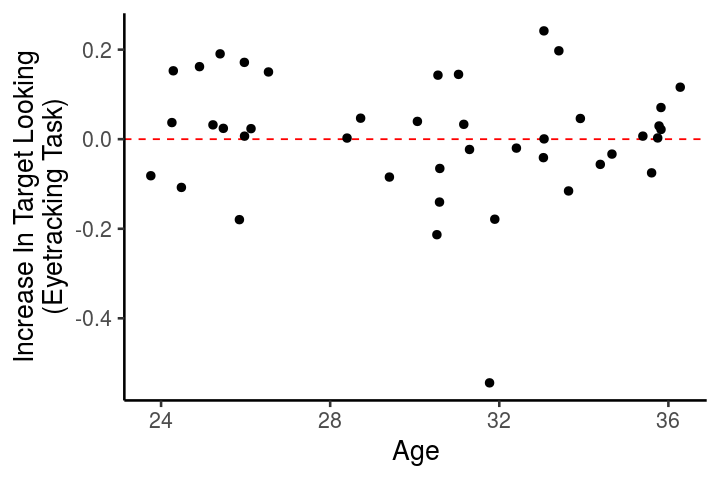

In [205]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(subset(exre, age_in_months > 20 & age_in_months < 40)) + geom_hline(yintercept=0,  
color = 'red', linetype = 'dashed') + geom_jitter(
aes(x=age_in_months, y=prop_looks_to_target), alpha = 1,
    colour="black", size=2, width = .03, height =.03
)  + theme_classic(
    base_size = 16
) + xlab(
    'Age') + ylab(
    'Increase In Target Looking\n(Eyetracking Task)') 

#+ coord_cartesian(xlim=c(0,1),    ylim =c(-.3,.3))

#ggsave('figures/expressive_vs_receptive.pdf', width=6, height=4)

In [259]:
library('ggExtra')

Warning message:
“Ignoring unknown aesthetics: id”Warning message:
“Removed 4 rows containing missing values (geom_point).”

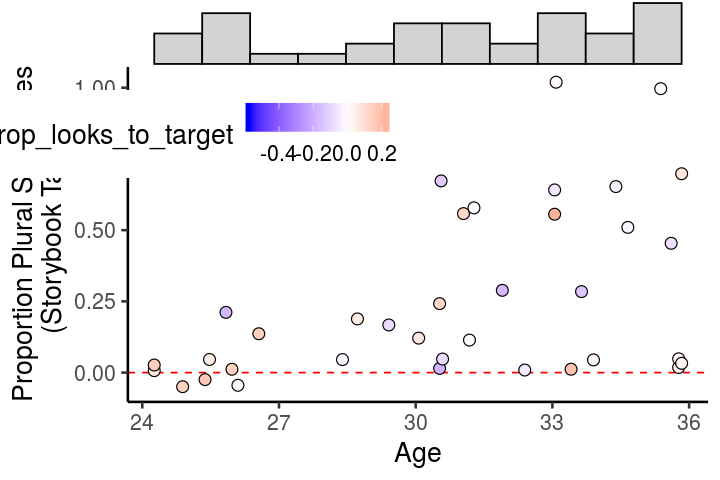

In [260]:
options(repr.plot.width=6, repr.plot.height=4)
mid<-mean(exre$prop_looks_to_target)

p1 = ggplot(subset(exre, age_in_months >= 24 & age_in_months <= 36)) + geom_hline(yintercept=0,  
color = 'red', linetype = 'dashed') + geom_jitter(
aes(x=age_in_months, y=broad_score, fill=prop_looks_to_target,
   id=prop_looks_to_target), alpha = 1, 
    size=3, width = 0, height =.05, pch=21, colour="black"
)  + theme_classic(
    base_size = 16
) + theme(legend.position = c(0.1, 0.8), legend.direction = 'horizontal') + xlab(
    'Age') + ylab(
    'Proportion Plural Successes\n(Storybook Task)') +scale_fill_gradient2(midpoint=mid, 
    low="blue", mid="white",high="red", space ="Lab" )

p1 = ggMarginal(p1, type = "histogram", margins="x", color="black",
    fill = "lightgray", xparams = list(bins=12))
ggsave('figures/expressive_vs_age.pdf', plot = p1, width=4, height=4)
p1

In [262]:
print(mid)

[1] 0.0001087171


Warning message:
“Removed 5 rows containing missing values (geom_point).”

Warning message:
“Removed 5 rows containing missing values (geom_point).”

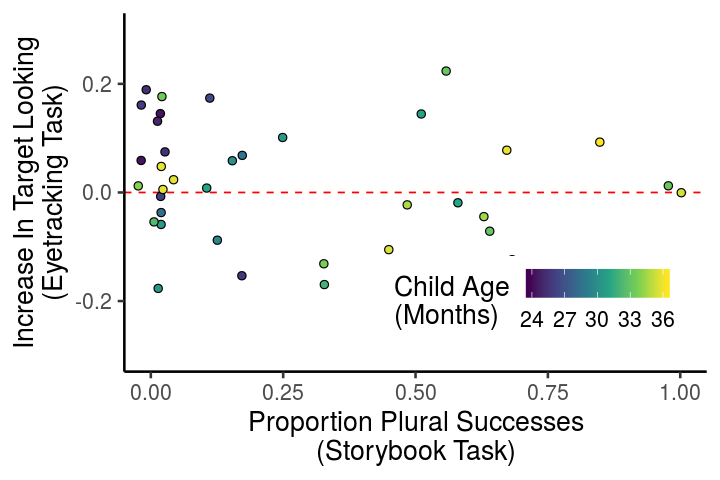

In [258]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(subset(exre, age_in_months > 20 & age_in_months < 40)) + geom_hline(yintercept=0,  
color = 'red', linetype = 'dashed') + geom_jitter(
aes(x=broad_score, y=prop_looks_to_target, fill=age_in_months), alpha = 1,
    colour="black",pch=21, size=3, width = .03, height =.03
) + scale_fill_continuous(type = "viridis", name = "Child Age\n(Months)") + theme_classic(
    base_size = 16
)+ theme(legend.position = c(0.7, 0.2), legend.direction = 'horizontal') + xlab(
    'Proportion Plural Successes\n(Storybook Task)') + ylab(
    'Increase In Target Looking\n(Eyetracking Task)') + coord_cartesian(xlim=c(0,1), 
    ylim =c(-.3,.3))

ggsave('figures/expressive_vs_receptive.pdf', width=4, height=4)

In [261]:
spearboot = function(dat, var1, var2, cor_method, R = 2500){
    N <- nrow(dat)
    cor.boot = mat.or.vec(1,R)
    for (i in 1:R) {
      idx <- sample.int(N, N, replace = TRUE) 
      cor.boot[i] <- cor(dat[idx,var1],dat[idx,var2], method=cor_method,
                        use='pairwise.complete.obs')
    }
    return(cor.boot)
}

getSpearmanStats = function(exre, var1, var2, varTitle, tvc){
    cor_test = cor.test(exre[[var1]], exre[[var2]], use='pairwise.complete.obs',
       method = "spearman")
    
    boot_estimate = spearboot(exre, var1, var2,
    'spearman')
    
    boot_ci = quantile(boot_estimate, c(.025,.975))    
    #print(unname(cor_test$estimate)[1])
    tvc = update_texvar_cache(tvc, paste0(varTitle,'Cor'), unname(cor_test$estimate)[1], digits=3)
    #print(unname(cor_test$p.value)[1])
    tvc = update_texvar_cache(tvc, paste0(varTitle,'CorP'), unname(cor_test$p.value)[1], digits=3)
    #print(boot_ci[['2.5%']][1])
    tvc = update_texvar_cache(tvc, paste0(varTitle, 'CorLow'), boot_ci[['2.5%']][1], digits=3)
    tvc = update_texvar_cache(tvc, paste0(varTitle, 'CorHigh'), boot_ci[['97.5%']][1], digits=3)    
    return(tvc)    
}

In [ ]:
tvc = getSpearmanStats(exre, 'prop_looks_to_target', 'broad_score', 'expRec', tvc)
tvc = getSpearmanStats(exre, 'age_in_months', 'broad_score', 'expAge', tvc)
tvc = getSpearmanStats(exre, 'age_in_months', 'prop_looks_to_target', 'recAge', tvc)
tvc = getSpearmanStats(exre, 'prop_looks_to_target', 'broad_score', 'expRec', tvc)
print(tvc)
#tvc = writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(exre) + geom_hline(yintercept=0,  color = 'red', linetype = 'dashed') + geom_jitter(
aes(x=broad_score, y=prop_looks_to_target, colour=age_in_months)
) + scale_colour_continuous(type = "viridis") + theme_classic() + ggtitle('No normalization')

In [ ]:
child_receptive_scores = subset(all_scores, normalizeMethod == 'preceding' & contrast_type == '1-way')
exre = merge(subject_info, child_receptive_scores, by='participant_name')
head(exre)

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(exre) + geom_hline(yintercept=0,  color = 'red', linetype = 'dashed') + geom_jitter(
aes(x=broad_score, y=prop_looks_to_target, colour=age_in_months)
) + scale_colour_continuous(type = "viridis") + theme_classic() + ggtitle('Normalized by Preceding')

# Logistic Regression Models for Production

In [ ]:
p_coded$s_success = NA 
p_coded$s_success[p_coded$Singular.Code %in% c(5)] = 1
p_coded$s_success[p_coded$Singular.Code %in% seq(1,4)] = 0
p_coded$pl_success = NA 
p_coded$pl_success[p_coded$Plural.Code %in% c(7,8)] = 1
p_coded$pl_success[p_coded$Plural.Code %in% seq(1,6)] = 0

## Singular Production

In [ ]:
table(p_coded$s_success)

In [ ]:
tvc

In [ ]:
numTrialsInSingularLM = nrow(p_coded)
tvc = update_texvar_cache(tvc, 'numTrialsInSingularLM', numTrialsInSingularLM)
writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

In [ ]:
singular_lm_data = p_coded
singular_lm_data$novelty = binarize(singular_lm_data$novelty,c('familiar','novel'))
singular_lm_data$voicing = binarize(singular_lm_data$voicing,c('voiceless','voiced'))
singular_lm_data$animacyStatus = binarize(singular_lm_data$animacy,c('inanimate','animate'))

In [ ]:
singular_lm = glmer(s_success~novelty * voicing + animacyStatus + 
    (novelty * voicing + animacyStatus | child) +(1|itemId), family=binomial, 
    data= singular_lm_data,
 control = glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=100000)))
summary(singular_lm)

## Plural Production

In [ ]:
table(subset(p_coded, Singular.Code ==5)$pl_success)

In [ ]:
numTrialsInPluralLM = nrow(subset(p_coded, Singular.Code ==5))
numTrialsInPluralLM
tvc = update_texvar_cache(tvc, 'numTrialsInPluralLM', numTrialsInPluralLM)
writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

In [ ]:
print(p_coded[1,])

In [ ]:
plural_lm_data = subset(p_coded, Singular.Code ==5)
plural_lm_data$novelty = binarize(plural_lm_data$novelty,c('familiar','novel'))
plural_lm_data$voicing = binarize(plural_lm_data$voicing,c('voiceless','voiced'))
plural_lm_data$animacyStatus = binarize(plural_lm_data$animacy,c('inanimate','animate'))


plural_lm = glmer(pl_success ~ novelty * voicing + animacyStatus + 
    (novelty * voicing + animacyStatus|child) +(1|itemId), family=binomial, 
    data=plural_lm_data,
 control = glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=100000)))
summary(plural_lm)

In [ ]:
get_texvar_from_beta = function(lm, targetVar, tvc_varname, tvc) {

    coefs = data.frame(summary(lm)$coefficients)
    coefs$var = rownames(coefs)
    tv = subset(coefs, var == targetVar)
    if (round(tv$Pr...z..[1], digits = 3) == 0){
         pval = paste0("p < .001")   
    } else {
        pval = paste0("p = ", round(tv$Pr...z..[1], digits=3))
    }

   tvc[[tvc_varname]] =  paste0("$\\beta$ = ", round(tv$Estimate[1], digits=3),", ",
     "SE = ", round(tv$Std..Error[1], digits=3), ", ",
      pval
     )
    
return(tvc)
}


In [ ]:
tvc = get_texvar_from_beta(plural_lm, 'novelty','pluralLMnovelty', tvc)
tvc = get_texvar_from_beta(singular_lm, 'novelty','singularLMnovelty', tvc)

In [ ]:
# augment the results so that dwplot can produce them correctly
singular_lm_aug = recoverIntercept(singular_lm) %>% mutate(model = "Singular")
plural_lm_aug = recoverIntercept(plural_lm) %>% mutate(model = "Plural")

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)
dwplot(subset(rbind(singular_lm_aug, plural_lm_aug), group == 'fixed'), 
       effects="fixed"
    ) %>%  relabel_predictors(c(
    novelty = "Novelty\n(novel vs. familiar)",
    voicing = "Voicing\n(/s/ vs. /z/)",
    animacyStatus = "Animacy\n(inanimate vs. animate)",
    expt_index = "Trial Order",
    `novelty:voicing` = "Novelty x Voicing"
))  + geom_vline(xintercept=0, lty=2
) + theme_bw(base_size=14) + theme(legend.position = c(.8,.8), 
    legend.background = element_rect(fill="lightgray", 
                                  size=0.5, linetype="solid")
)  + theme(
    legend.key.size = unit(.4, "cm"),
    legend.position = c(.8,.4), 
    legend.background = element_rect(fill="white", linetype="solid", 
                                  colour ="black"),
    )  + geom_vline(xintercept=0, lty=2
) + labs(color = "")  + labs(
     color = "Model"
) + xlab('Log Odds Ratio (95% CI)')

ggsave('figures/production_model.pdf', width=5,height=3)

In [ ]:
# can I plot the logits as probits? No because I need to combine them
logit2prob <- function(logit){
  odds <- exp(logit)
  prob <- odds / (1 + odds)
  return(prob)
}
logit2prob(-2.5)
#https://sebastiansauer.github.io/convert_logit2prob/

In [ ]:
# [ ] get probabilities of succcess for worst and best scenarios

# Age vs. Plural Knowledge

In [ ]:
code_counts_with_age = merge(subject_info, code_counts, by.x='id', by.y='child')
code_counts_with_age = merge(code_counts_with_age, codes)
head(code_counts_with_age)

In [ ]:
children_in_age_range = subset(code_counts_with_age, type == 'child' & in_study)

In [ ]:
cor(children_in_age_range$broad_score,children_in_age_range$age_in_days, 
    use="pairwise.complete.obs")

In [ ]:
length(unique(children_in_age_range$participant_name))

In [ ]:
#code_counts_with_age is much less than subject_info
length(unique(subset(children_in_age_range, !is.na(narrow_score))$participant_name))
# it is the age range filtering and the absence of narrow scores

In [ ]:
# this is superseded below by collapsing across kids within each age range
options(repr.plot.width=8, repr.plot.height=6)
ggplot(children_in_age_range) + geom_bar(
aes(x=age_in_months, y=count, fill=description),
stat="identity",  width = 0.2, position="fill"
) + scale_fill_manual(values = rep(c("white", "palegreen3", "palegreen2", "palegreen1",
"palegreen", "peachpuff1", "peachpuff2", "steelblue1","steelblue2"), 2)) + facet_wrap(~s_pl, nrow=2) + xlab('Age in Months') + ylab('Count'
) + theme_classic() 

In [ ]:
# simplify the coloration of the above
remap = list()
remap[['0']] = 'No Data'
remap[['1']] = 'No Response / Not Relevant'
remap[['2']] = 'No Response / Not Relevant'
remap[['3']] = 'No Response / Not Relevant'
remap[['4']] = 'No Response / Not Relevant'
remap[['5']] = 'Singular'
remap[['6']] = 'Non-Conventional Plural'
remap[['7']] = 'Plural'
remap[['8']] = 'Plural'

children_in_age_range$recode =
sapply(children_in_age_range$code, function(x){remap[[as.character(x)]]})
children_in_age_range$recode = factor(children_in_age_range$recode,
    levels = c('No Data', 'No Response / Not Relevant', 'Singular',
               'Non-Conventional Plural','Plural'))

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot(children_in_age_range) + geom_bar(
aes(x=age_in_months, y=count, fill=recode),
stat="identity",  width = 0.2, position="fill"
) + facet_wrap(~s_pl, nrow=2) + xlab('Age in Months') + ylab('Count'
) + theme_classic() + scale_fill_manual(values = rep(c("white", "palegreen2", 
 "salmon1", "peachpuff2","steelblue1"), 2)
) + scale_y_continuous('Count', breaks=seq(from=0, to=1, by=.25), 
    labels=seq(from=0, to=16, by=4))


In [ ]:
# aggreagate each category within each 4-month group; mean + sd; two kinds of lines
# mean + sd for each
# median for each? in many cases, it will 
# familiars and plurals as two separate panels

In [ ]:
subset(subject_info, participant_name == 'pl04')

In [ ]:
subject_info$age_group = sapply(subject_info$age_in_months,
    function(x){
        if (is.na(x)){
            return('No age')
        } else {
            if (x < 28){
                return('24-28')
            } else if (x < 32){
                return('28-32')
            } else {
                return('32-36')
            }
        }
    })

In [ ]:
names(children_in_age_range)
# need to aggregaye split by novelty

In [ ]:
p_coded_aug = merge(p_coded, subject_info[,c('id','age_group')], by.x='child', by.y='id')

In [ ]:
head(p_coded_aug)

In [ ]:
p_coded_aug$singular_recode =
sapply(p_coded_aug$Singular.Code, function(x){remap[[as.character(x)]]})
p_coded_aug$singular_recode = factor(p_coded_aug$singular_recode,
    levels = c('No Data', 'No Response / Not Relevant', 'Singular',
               'Non-Conventional Plural','Plural'))

p_coded_aug$plural_recode =
sapply(p_coded_aug$Plural.Code, function(x){remap[[as.character(x)]]})
p_coded_aug$plural_recode = factor(p_coded_aug$plural_recode,
    levels = c('No Data', 'No Response / Not Relevant', 'Singular',
               'Non-Conventional Plural','Plural'))

In [ ]:
sing_counts = aggregate(itemId ~ singular_recode + novelty + age_group, p_coded_aug, length)
names(sing_counts)[1] = 'code'
names(sing_counts)[length(names(sing_counts))] = 'count'
sing_counts$s_pl = 'Singular Trials'
pl_counts = aggregate(itemId ~ plural_recode + novelty  + age_group, p_coded_aug, length)
names(pl_counts)[1] = 'code'
names(pl_counts)[length(names(pl_counts))] = 'count'
pl_counts$s_pl = 'Plural Trials'
code_counts = rbind(sing_counts,pl_counts)
code_counts$novelty = as.character(code_counts$novelty)
code_counts$novelty[code_counts$novelty == 'familiar'] = 'Familiar Object Words'
code_counts$novelty[code_counts$novelty == 'novel'] = 'Novel Object Words'
head(code_counts)

In [ ]:
# recompute these as proportions
non_missing_code_counts = subset(code_counts, code != 'No Data')

code_props = do.call('rbind', lapply(split(non_missing_code_counts, list(non_missing_code_counts$novelty,
    non_missing_code_counts$age_group, non_missing_code_counts$s_pl)), function(df){
    total = sum(df$count)
    df$prop = df$count / total
    return(df)
}))
subset(code_props, s_pl == 'Plural Trials' & novelty == 'Novel Object Words' & age_group == '24-28')

In [ ]:
library(ggplot2)
options(repr.plot.width=4, repr.plot.height=5)

code_props$s_pl = factor(code_props$s_pl, levels = c('Singular Trials','Plural Trials'))

ggplot(code_props) + geom_bar(
aes(x=age_group, y=prop, fill=code, label=count),
stat="identity", position="stack"
) + facet_grid(s_pl~novelty) + xlab('Age Group (Months)') + ylab('Proportion of Responses'
) + theme_classic() + scale_fill_manual(values = rep(c("palegreen2", 
 "salmon1", "peachpuff2","steelblue1"), 2)
) + geom_text(size=3, aes(x=age_group, y=prop, fill=code, label=count),
          position = position_stack(vjust = 0.5)) + theme(legend.position="bottom",
    legend.title = element_blank(), legend.direction='vertical', legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,-5,-5,-5)) + guides(fill=guide_legend(ncol=2))
ggsave('figures/production_props.pdf', height=5, width=4)

In [ ]:
code_props$s_pl_by_novelty = paste0(code_props$s_pl,":\n ", code_props$novelty)
code_props$s_pl_by_novelty = factor(code_props$s_pl_by_novelty)
code_props$s_pl_by_novelty = factor(code_props$s_pl_by_novelty, levels = rev(levels(code_props$s_pl_by_novelty)))

options(repr.plot.width=8, repr.plot.height=3)
ggplot(code_props) + geom_bar(
aes(x=age_group, y=prop, fill=code, label=count),
stat="identity", position="stack"
) + facet_wrap(~s_pl_by_novelty, nrow=1) + xlab('Age Group (Months)') + ylab('Proportion of Responses'
) + theme_classic() + scale_fill_manual(values = rep(c("palegreen2", 
 "salmon1", "peachpuff2","steelblue1"), 2)
) + geom_text(size=3, aes(x=age_group, y=prop, fill=code, label=count),
          position = position_stack(vjust = 0.5)) + theme(legend.position="bottom",
    legend.title = element_blank(), legend.direction='vertical', legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,-5,-5,-5)) + guides(fill=guide_legend(ncol=4))
ggsave('figures/production_props.pdf', height=2.5, width=8)

In [ ]:
# expect ~400 in each category
sum(subset(code_props, s_pl == 'Plural Trials' & novelty == 'Novel Object Words')$count)

In [ ]:
#  [] try to add the number of kids (omitting the smallest ones) in parentheticals
# [ ] may need to nudge these up

In [ ]:
length(unique(subset(children_in_age_range, code %in% c(7,8) & type =='child')$id))
length(unique(subset(children_in_age_range, code %in% c(1:8)  & type =='child')$id))

In [ ]:
aggregate(count ~ participant_name, subset(code_counts_with_age, code %in% c(7,8)
                                          & s_pl == 'plural'), sum)

In [ ]:
nrow(subset(aggregate(count ~ participant_name, subset(children_in_age_range, code %in% c(7,8)
                                          & s_pl == 'plural'), sum), count > 8)) 

In [ ]:
# drop backe to p_coded 
p_coded_incl = subset(p_coded, child %in% children_in_age_range$id)
names(p_coded_incl)

In [ ]:
nProducingAPlural = length(unique(subset(p_coded_incl, Plural.Code %in% c(7,8))$child))
nProducingAPlural
tvc = update_texvar_cache(tvc, 'nProducingAPlural', nProducingAPlural)

In [ ]:
# Number of participants with production data
storybookNwithProductions = length(unique(p_coded_incl$child))
storybookNwithProductions
tvc = update_texvar_cache(tvc, 'storybookNwithProductions', storybookNwithProductions)

In [ ]:
# Number that produced one or more novel plurals
nProducingNovelPlurals = length(unique(subset(p_coded_incl, Plural.Code %in% c(7,8) & novelty == 'novel' )$child))
tvc = update_texvar_cache(tvc, 'nProducingNovelPlurals', nProducingNovelPlurals)

writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

In [ ]:
# Number that produced one or more novel singulars
nNovelSingulars = length(unique(subset(p_coded_incl, Singular.Code %in% c(5) & novelty == 'novel' )$child))
nNovelSingulars
tvc = update_texvar_cache(tvc, 'nNovelSingulars', nNovelSingulars)

In [ ]:
# Number that produced non-conventional plurals
nNonconventionalPlurals = length(unique(subset(p_coded_incl, Plural.Code %in% c(6) & novelty == 'novel' )$child))
nNonconventionalPlurals
tvc = update_texvar_cache(tvc, 'nNonconventionalPlurals', nNonconventionalPlurals)

In [ ]:
names(subject_info)

In [ ]:
fam = aggregate(Plural.Code ~ child, subset(p_coded_incl, Plural.Code %in% c(7,8) & novelty == 'familiar'),
          length)
names(fam) = c('child','fam_pl')
nov = aggregate(Plural.Code ~ child, subset(p_coded_incl, Plural.Code %in% c(7,8) & novelty == 'novel'),
          length)
names(nov) = c('child','nov_pl')
combined = merge(fam, nov, all=T)
combined = merge(combined, subject_info[,c('participant_name','age_in_months','age_group')],
     by.x='child', by.y='participant_name')
nrow(combined)

combined[is.na(combined)] = 0
options(repr.plot.width=4, repr.plot.height=4)
ggplot(combined) + geom_jitter(aes(x=fam_pl, y=nov_pl, color=factor(age_group)
), width=.5, height=.5, size=4) + theme_classic(base_size=16
) + xlab('# Familiar Plurals') + ylab('# Novel Plurals') + coord_cartesian(xlim=c(-1,8.5),
    ylim=c(-1,8.5)) + geom_abline(yintercept=0, slope=1, linetype = 'dashed', alpha=.5
) + theme(
    legend.key.size = unit(.4, "cm"),
    legend.position = c(.2,.9), 
    legend.background = element_rect(fill="white", linetype="solid", 
                                  colour ="white"),
    legend.title=element_blank()
    )

ggsave('figures/familiar_vs_novel_plurals.pdf', width = 4, height=4)

In [ ]:
fam_nov_cor = cor.test(combined$fam_pl, combined$nov_pl, method='spearman')

In [ ]:
fam_nov_cor$estimate

In [ ]:
fam_nov_cor$p.value

In [ ]:
fam_nov = spearboot(combined, 'fam_pl', 'nov_pl', cor_method='spearman' )
ggplot(data.frame(fam_nov= t(fam_nov))) + geom_density(aes(x=fam_nov))

In [ ]:
fam_nov_cor_boot_ci = quantile(t(fam_nov), c(0.025, 0.975))
fam_nov_cor_boot_ci[['2.5%']]
fam_nov_cor_boot_ci[['97.5%']]

In [ ]:
tvc = update_texvar_cache(tvc, 'famNovCor', fam_nov_cor$estimate, digits=3)
tvc = update_texvar_cache(tvc, 'famNovCorP', fam_nov_cor$p.value, digits=3)
tvc = update_texvar_cache(tvc, 'famNovCorUpper', fam_nov_cor_boot_ci[['97.5%']], digits=3)
tvc = update_texvar_cache(tvc, 'famNovCorLower', fam_nov_cor_boot_ci[['2.5%']], digits=3)
writeout_texvar_cache(tvc, 'texvars/pilot_analysis.tex',appendDate=T)

In [ ]:
numProducingHalfNovelPlurals = nrow(subset(nov, nov_pl >= 4))
tvc = update_texvar_cache(tvc, 'numProducingHalfNovelPlurals', numProducingHalfNovelPlurals)
numProducingHalfFamiliarPlurals= nrow(subset(fam, fam_pl>= 4))
tvc = update_texvar_cache(tvc, 'numProducingHalfFamiliarPlurals', numProducingHalfFamiliarPlurals)
combined$total_pl = combined$nov_pl + combined$fam_pl
subset(combined, total_pl > 8)

In [ ]:
nrow(subset(combined, nov_pl > 0))
nrow(combined)

In [ ]:
ggplot(subset(code_counts_with_age,age_in_months > 20 & age_in_months < 40 )
      ) + geom_histogram(aes(x=age_in_months)) + facet_wrap(~expt_version)

In [ ]:
names(code_counts_with_age)

In [ ]:
subj = aggregate(age_in_months ~ participant_name + expt_version, code_counts_with_age, unique)
head(subj)

In [ ]:
subj_in_age_range = subset(subj,age_in_months > 20 & age_in_months < 40)

proposed_base = rbind(subj_in_age_range,
                data.frame(participant_name='pl59', expt_version='redblue',
                            age_in_months = 32.99 ), 
                data.frame(participant_name='pl61', expt_version='redblue',
                            age_in_months = 24.0 
                        ),
                data.frame(participant_name='pl62', expt_version='redblue',
                            age_in_months = 34.0 ),
                data.frame(participant_name='pl63', expt_version='scene',
                            age_in_months = 32.0 ),
                data.frame(participant_name='pl64', expt_version='scene',
                            age_in_months = 32.0 ),
                data.frame(participant_name='pl56', expt_version='scene',
                            age_in_months = 34.0 ))
                 
proposed_scene = rbind(proposed_base,                      
                data.frame(participant_name='proposed_pl67', expt_version='scene',
                            age_in_months = 24.0 )) 

proposed_redblue = rbind(proposed_base,                      
                data.frame(participant_name='proposed_pl67', expt_version='redblue',
                            age_in_months = 24.0 ))          

In [ ]:
# are the ages for experiments 1 and 2 drawn from the same distribution?
wilcox.test(proposed_scene$age_in_months~proposed_scene$expt_version)
wilcox.test(proposed_redblue$age_in_months~proposed_redblue$expt_version)
#-- > go with redblue

Ages are not distinguished

In [ ]:
aggregate(age_in_months ~ expt_version, subj, length)

In [ ]:
subj_scores = aggregate(broad_score ~ participant_name + expt_version, 
    subset(code_counts_with_age,age_in_months > 20 & age_in_months < 40),  unique)
print(nrow(subj_scores))
wilcox.test(subj_scores$broad_score~subj_scores$expt_version)
# only 22 with defined narrow scores

This also provides evidence that we can combine across production tasks in redblue and background versions

In [ ]:
ggplot(subj_scores) + geom_violin(aes(x=expt_version, y=broad_score, fill=expt_version))

In [ ]:
# can combine, but marginal. Narrow score is the correct one.

Compare with existing studies: 

- Zapf and Smith (2007):
- Zapf and Ettlinger (2011): for 22-35 months (m=25.8): 52% correct plurals; 33% singulars, remainder are non-answers
Experimenter says "Can you tell Teddy to get ____" and point to the singulars or the plurals. Common familiar nouns. ****Teddy bear picks up things or not, i.e. there is reinforcement learning.****


# Vocabulary vs. Plural Knowledge

In [ ]:
# pull in CDI scores

# Response Time When Looking at Distractor

In [ ]:
metadata_cols = c('animacystatus', 'background_context','distractorimage',
'distractorloc', 'expt_index', 'full_carrier', 'novel_id', 'novelcolor',
'novelty', 'order', 'pl_carrier', 'pl_form', 'pl_punct', 'pl_sentence',
'pl_wav_index', 'practice', 's_carrier', 's_form', 's_punct',
's_sentence', 's_wav_index', 'simple_pl_stim', 'simple_s_stim', 'target',
'targetimage', 'targetloc', 'targetside', 'test_index', 'trial', 'voicing', 'vowel_carrier',
'RECORDING_SESSION_LABEL')

In [ ]:
names(ed_df)

In [ ]:
fixreports = split(ed_df, ed_df$filename)

In [ ]:
source('PLEARN_analysis_helper.R')
test_df = do.call('rbind',lapply(fixreports, function(fixreport){
    getParticipantRTs(380, fixreport, label_colname="CURRENT_FIX_INTEREST_AREA_LABEL", metadata_cols, include_non_roi_label=T)
})) 

In [ ]:
# 10/10/19: this is failing because of an edge case where we don't see any fixations before disambiguation

In [ ]:
getRTComparisonPlot = function(test_df, split_var, facet_var = NULL){
    
    agg_equation = paste("rt ~", split_var)
    if (!is.null(facet_var)){
        agg_equation = paste(agg_equation, "+", facet_var)
    }
    summary_df = do.call(data.frame, aggregate(as.formula(agg_equation), data = test_df, FUN = function(x)
        c(mean = mean(x), sd = sd(x))))
    print(names(summary_df))                   
    
    options(repr.plot.width=4, repr.plot.height=4)
    p1 = ggplot(test_df) + geom_violin(mapping=aes(y=rt, x=factor(test_df[[split_var
]]), colour=factor(test_df[[split_var]]))) + theme_bw(
) + geom_errorbar(data = summary_df, mapping=aes(x=factor(summary_df[[split_var
]]), ymin =  rt.mean - rt.sd, ymax = rt.mean + rt.sd), width = 0.1, alpha=.5) + geom_errorbar(data = summary_df, mapping=aes(x=factor(summary_df[[split_var
]]), ymin =  rt.mean, ymax = rt.mean)) + theme_bw(
) + geom_hline(yintercept=0, colour='black', linetype='dashed'
) + geom_hline(yintercept=367, colour='forestgreen') + coord_flip(
ylim= c(0,2000)) + xlab(split_var) + ylab(''
) + theme(legend.position="none")
    
    if (!is.null(facet_var)){
        options(repr.plot.width=4, repr.plot.height=8)
        p1 = p1 + facet_wrap(as.formula(paste('~', facet_var, sep='')), ncol=1)
    }
    print(p1)
                                               
    p2 = ggplot(test_df) + geom_histogram(mapping=aes(x=rt, fill=factor(test_df[[split_var]]))
    ) + theme_bw() + geom_errorbarh(data = summary_df, 
    mapping=aes(y=factor(summary_df[[split_var]]), xmin =  rt.mean - rt.sd, xmax = rt.mean + rt.sd),
    width = 0.1, alpha=.5) + geom_errorbarh(data = summary_df, mapping=aes(y=factor(summary_df[[split_var
    ]]), xmin =  rt.mean, xmax = rt.mean)) + theme_bw() + geom_vline(xintercept=0, 
    colour='black', linetype='dashed') + geom_vline(xintercept=367, colour='forestgreen'
    ) + coord_cartesian(xlim= c(0,2000)) + theme(legend.position="none")
    
    if (!is.null(facet_var)){
        options(repr.plot.width=4, repr.plot.height=8)
        p2 = p2 + facet_wrap(as.formula(paste('~', facet_var, '+', split_var, sep='')), ncol=1)
    } else {
        p2 = p2 + facet_wrap(as.formula(paste('~', split_var, sep='')), ncol=1)
    }
    #print(p2)                                  
                                               
                                               
}

In [ ]:
names(test_df)

In [ ]:
getRTComparisonPlot(test_df, split_var = 'RECORDING_SESSION_LABEL', facet_var='target')

In [ ]:
getRTComparisonPlot(test_df, split_var = 'target')

In [ ]:
getRTComparisonPlot(test_df, split_var = 'target', facet_var = 'RECORDING_SESSION_LABEL')

In [ ]:
getRTComparisonPlot(test_df,split_var = 'voicing', facet_var='target')

In [ ]:
getRTComparisonPlot(test_df,split_var = 'novelty', facet_var='target')

In [ ]:
getRTComparisonPlot(test_df,split_var = 'animacystatus', facet_var='target')

In [ ]:
names(test_df)

In [ ]:
library('lme4')
lm = lmer(rt ~ novelty + voicing + animacystatus + 
    (novelty + voicing + animacystatus | RECORDING_SESSION_LABEL) +(1|s_form), data=
 test_df, )
summary(lm)

# Preference Before Disambiguation

In [ ]:
beforeafter_disambig_df = subset(ed_df, 
    CURRENT_FIX_INTEREST_AREA_LABEL %in% c('TARGET','DISTRACTOR')) 
beforeafter_disambig_df$looking_at_plural = 0
beforeafter_disambig_df$looking_at_plural[
    beforeafter_disambig_df$CURRENT_FIX_INTEREST_AREA_LABEL == 'TARGET' & 
    beforeafter_disambig_df$target == 'pl'] = 1
beforeafter_disambig_df$looking_at_plural[
    beforeafter_disambig_df$CURRENT_FIX_INTEREST_AREA_LABEL == 'DISTRACTOR' & 
    beforeafter_disambig_df$target == 's'] = 1
beforeafter_disambig_df$beforeafter = 'After Disambiguation'
beforeafter_disambig_df$beforeafter[beforeafter_disambig_df$Time < 367] = 'Before Disambiguation'
beforeafter_disambig_preference = aggregate(looking_at_plural ~ participant_name +
    type + beforeafter + TRIAL_INDEX, 
    beforeafter_disambig_df, mean)

beforeafter_disambig_by_subject = do.call(data.frame, aggregate(looking_at_plural ~ participant_name + type +  beforeafter, beforeafter_disambig_preference, FUN = function(x){c(mean=mean(x), sd = sd(x))}))                                       

print(beforeafter_disambig_by_subject)

In [ ]:
beforeafter_disambig_by_subject$looking_at_plural_low = 
    beforeafter_disambig_by_subject$looking_at_plural.mean - beforeafter_disambig_by_subject$looking_at_plural.sd
beforeafter_disambig_by_subject$looking_at_plural_high = 
    beforeafter_disambig_by_subject$looking_at_plural.mean + beforeafter_disambig_by_subject$looking_at_plural.sd

In [ ]:
#options(repr.plot.width=4, repr.plot.height=4)
ggplot(subset(beforeafter_disambig_by_subject, beforeafter == "Before Disambiguation" &
type == 'adult')) + geom_errorbar(aes(x=participant_name, ymin= looking_at_plural_low,
 ymax= looking_at_plural_high), color='red') + geom_point(aes(x=participant_name, 
y=looking_at_plural.mean)) + theme_classic() + geom_hline(yintercept=.5, linetype = 'dashed'
) + xlab('Participant') + ylab('Mean Proportion Looks to Plural\n Before Disambiguation (SD)'
) + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + facet_wrap(~type)

In [ ]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(subset(beforeafter_disambig_by_subject, beforeafter == "Before Disambiguation" &
type == 'child')) + geom_errorbar(aes(x=participant_name, ymin= looking_at_plural_low,
 ymax= looking_at_plural_high), color='red') + geom_point(aes(x=participant_name, 
y=looking_at_plural.mean)) + theme_classic() + geom_hline(yintercept=.5, linetype = 'dashed'
) + xlab('Participant') + ylab('Mean Proportion Looks to Plural\n Before Disambiguation (SD)'
) + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + facet_wrap(~type)

In [ ]:
# should the last fix before disambig be excluded
#[X] Confirm that 0 is the point of disambig for everyone
#[X] propagate the information about the trials
#[X] Make sure that my ordering is doing the right thing
#[X] how to account for the 200 ms exclusion
#[X] have a bit of a buffer on either side of 0 in case there’s an NA instead of a 0/1 in that exact timebin
#    -- so far this is just looking backwards
#[ ] need to recompute wrt the beginning of the /s/ or /z/ segment, not the end

# Experimental Visualizations + Analyses 

## Binomial Test for Receptive Knowledge

In [ ]:
# requires updating since refactoring

In [ ]:
pl06_fixbins$is_looking_at_target  = as.numeric(pl06_fixbins$CURRENT_FIX_INTEREST_AREA_LABEL == 'TARGET')

In [ ]:
rlist = getPlotForMethod(fixbin_dfs, adult_fixbin_dfs, 'none')
options(repr.plot.width=10, repr.plot.height=5)
print(rlist$p1)
ggsave('figures/binomialTest_nopreprocessing.pdf', width=20, height=10)

In [ ]:
print(rlist$p2)

False negative rate around .1 on 2-way contrasts when halfway between adult-like knowledge and zero knowledge

False positve rate of around .02 on 1-way contrasts when zero-knowledge

In [ ]:
# takes a long time to run because of the bootstrapping
sim_yoked = getPlotForMethod(fixbin_dfs,adult_fixbin_dfs, 'yoked')
options(repr.plot.width=10, repr.plot.height=5)
print(sim_yoked$p1)
ggsave('figures/binomialTest_yoked.pdf', width=20, height=10)

In [ ]:
sim_yoked$p2

In [ ]:
# takes a long time to run because of the bootstrapping
sim_preceding = getPlotForMethod(fixbin_dfs,adult_fixbin_dfs, 'preceding')
options(repr.plot.width=10, repr.plot.height=5)
print(sim_preceding$p1)
ggsave('figures/binomialTest_preceding.pdf', width=20, height=10)

In [ ]:
sim_preceding$p2

## Gaze Stickiness Plot

In [ ]:
fixreport_path = 'results/smflip3_fixreport.txt'
participant_name = gsub('.txt','',tail(strsplit(fixreport_path, '/')[[1]]))[2]

In [ ]:
gaze = blabr::fixations_report(fixreport_path)
gaze = merge(gaze, audio_timings[,c('audiotarget','disambig_time')])
gaze$CURRENT_FIX_END = gaze$CURRENT_FIX_END - gaze$disambig_time
gaze$CURRENT_FIX_START = gaze$CURRENT_FIX_START - gaze$disambig_time

In [ ]:
fixbins = binifyFixations(gaze, keepCols=c("RECORDING_SESSION_LABEL",
"CURRENT_FIX_INTEREST_AREA_LABEL",
"RT",
"expt_index",
"target",
"s_form",
"novelty",
"animacystatus",
"voicing"))
subset(fixbins, Time==3200)

In [ ]:
ggplot(subset(fixbins, s_form =='mip')) + geom_point(aes(x=Time, y=CURRENT_FIX_INTEREST_AREA_LABEL)
) + facet_wrap(~s_form * target) + geom_vline(xintercept=0,
	colour='black')

In [ ]:
ggplot(subset(sm_fixbins, CURRENT_FIX_INTEREST_AREA_LABEL!='.')) + geom_point(aes(x=Time,
                                                                               y=s_form, colour=s_form)) + facet_wrap(CURRENT_FIX_INTEREST_AREA_LABEL ~ target) + geom_vline(xintercept=0, colour='black')

In [ ]:
ggplot(subset(pl00_fixbins, CURRENT_FIX_INTEREST_AREA_LABEL!='.')) + geom_point(aes(x=Time,
    y=s_form, colour=s_form)) + facet_wrap(CURRENT_FIX_INTEREST_AREA_LABEL ~ target) + geom_vline(xintercept=0, colour='black')


In [ ]:
ggplot(subset(pl01_fixbins, CURRENT_FIX_INTEREST_AREA_LABEL!='.')) + geom_point(aes(x=Time,
    y=s_form, colour=s_form)) + facet_wrap(CURRENT_FIX_INTEREST_AREA_LABEL ~ target) + geom_vline(xintercept=0, colour='black')


In [ ]:
ggplot(subset(pl03_fixbins, CURRENT_FIX_INTEREST_AREA_LABEL!='.')) + geom_point(aes(x=Time,
    y=s_form, colour=s_form)) + facet_wrap(CURRENT_FIX_INTEREST_AREA_LABEL ~ target) + geom_vline(xintercept=0, colour='black')